# Using Machine Learning to Estimate Ratings of Bangladeshi Restaurants from Reviews

## Data Exploration and Visualization

### Data and package importation

The dataset I will be working with is sourced from [Mendeley Data](https://data.mendeley.com/datasets/wc87kpk6ks/1), a reputable open-source data repository. 
This particular dataset consists of user reviews extracted from restaurants located in various places in the city of Dhaka

Key information such as the review text, user ratings, and the date of the review post were compiled.

In [1]:
# Import the packages that we will be using
import pandas as pd
import scipy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import emoji
import nltk
import timeit
import pydot
import gensim
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet

# Ensure that NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

2024-05-17 02:19:27.458271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoinem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Load the data from a CSV file
rws = pd.read_csv('data.csv')

### Data Vizualization

In the following step, I'm going to change the dataset to better suit my needs by removing columns that are not pertinent to our analysis. Additionally, I will assign more descriptive names to certain columns to enhance clarity and facilitate easier data handling.

In [3]:
# Drop the 'Unnamed: 0' and 'createdAt' columns from the dataframe 
rws = rws.drop(columns=['Unnamed: 0', 'createdAt', 'reviewerName',])

# Rename specific columns to more descriptive names:
rws.rename(columns={'text': 'review', 'ratingvalue': 'rating'}, inplace=True)

# Convert the 'rating' column to numeric
rws['rating'] = pd.to_numeric(rws['rating'], errors='coerce')

# Display the first 5 rows
print(rws.head())

                                              review  rating
0  To tell you the truth, they sell fried chicken...       1
1                                  Crispy was so bad       3
2  The restaurant provided leas items which I ord...       1
3  already send you a picture about my meal. tota...       1
4                                Excellent as before       5


In the following sections, we will explore the dataset in more detail. We'll begin by presenting a series of visualizations that will give us insights into the distribution, trends, and relationships within the data.

Let's dive into the visuals to better understand our dataset.

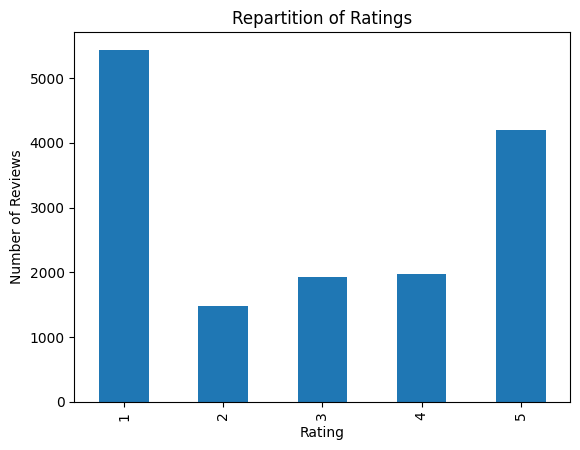

In [4]:
# Define the desired order of ratings
desired_order = [1, 2, 3, 4, 5]

# Calculate the counts of each rating
rating_counts = rws['rating'].value_counts()

# Reindex the rating_counts Series with the desired order
rating_counts = rating_counts.reindex(desired_order)

# Plot the repartition of ratings with the updated x-axis order
rating_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Repartition of Ratings')

# Show the plot
plt.show()


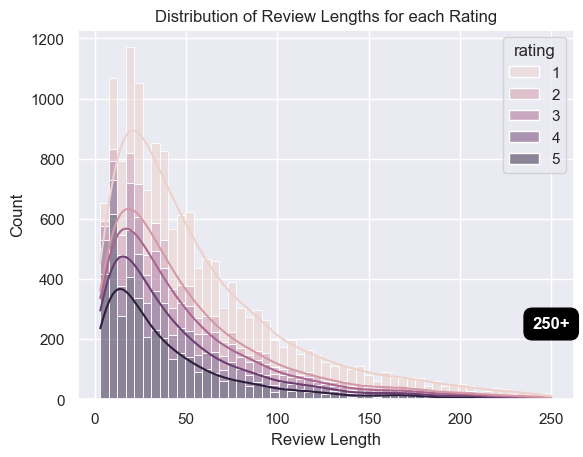

In [5]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the plot
sns.set(style="darkgrid")

# Calculate the length of reviews
rws['review_length'] = rws['review'].apply(len)

# Filter the review lengths greater than 250
filtered_rws = rws[rws['review_length'] <= 250]

# Plot the distribution of review lengths for each rating
sns.histplot(data=filtered_rws, x="review_length", hue="rating", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Review Lengths for each Rating")
plt.xlabel("Review Length")
plt.ylabel("Count")

# Add a label for review lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

In [6]:
# Define a function to preprocess the reviews
longest_review = rws.loc[rws['review_length'].idxmax(), 'review']

print(longest_review)

When the delivery man arrived at my house, he called me to let me know that he had sent the food upstairs with my guard. I asked him to kindly wait downstairs so that I can send him the money to which he replied said the food has been paid for. I was quite taken aback and said that's not possible because I had opted for COD payment, and he just said "achcha ami dekhtesi" and then he just hung up on my face " I mean? Excuse me? I obviously lost my temper, called him back and asked him what sort of nonsense is this and why he kept the phone on my face. He was dumbfounded and did not say a word. I asked him to wait downstairs while I send the guard with the payment. Once your delivery-man had received the payment, he had the audacity to call me back and ask why I said what I said. To recall the conversation, when he hung up on my face my exact words when I called him back were "apni amar mukher upor keno phone rakhlen? Faizlami peyechen apni? Ami toh bolchi cash eh payment hobe, apni nich

In [7]:
rws.drop('review_length', axis=1, inplace=True)

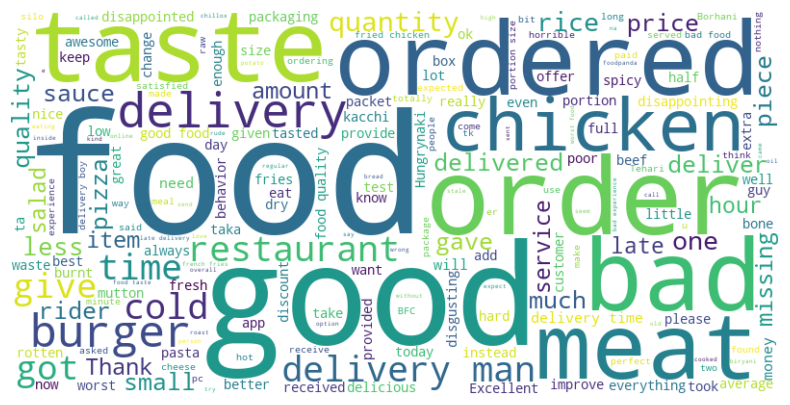

In [8]:
# Concatenate all the reviews into a single string
all_reviews = ' '.join(rws['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Data Categorization

### Data Categorization

I will create two categories for my reviews: Positive reviews, which are those with a rating strictly greater than 3, and Negative reviews, which include reviews with a rating strictly less than 3.

In [9]:
# Define a function that categorizes the rating
def categorize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 'Neutral'  # This handles ratings exactly equal to 3

# Apply the function to the 'rating' column
rws['rating'] = rws['rating'].apply(categorize_rating)

# Remove rows where the review_category is 'Neutral'
rws = rws[rws['rating'] != 'Neutral']

# Display the DataFrame to verify that 'Neutral' reviews have been removed
print(rws.head())

                                              review rating
0  To tell you the truth, they sell fried chicken...      0
2  The restaurant provided leas items which I ord...      0
3  already send you a picture about my meal. tota...      0
4                                Excellent as before      1
5  They forgot to include the beverages that were...      0


### Vizualization of the Categorization

Let's take a look at our newly categorized data to gain a clearer insight into how our future models will perform.

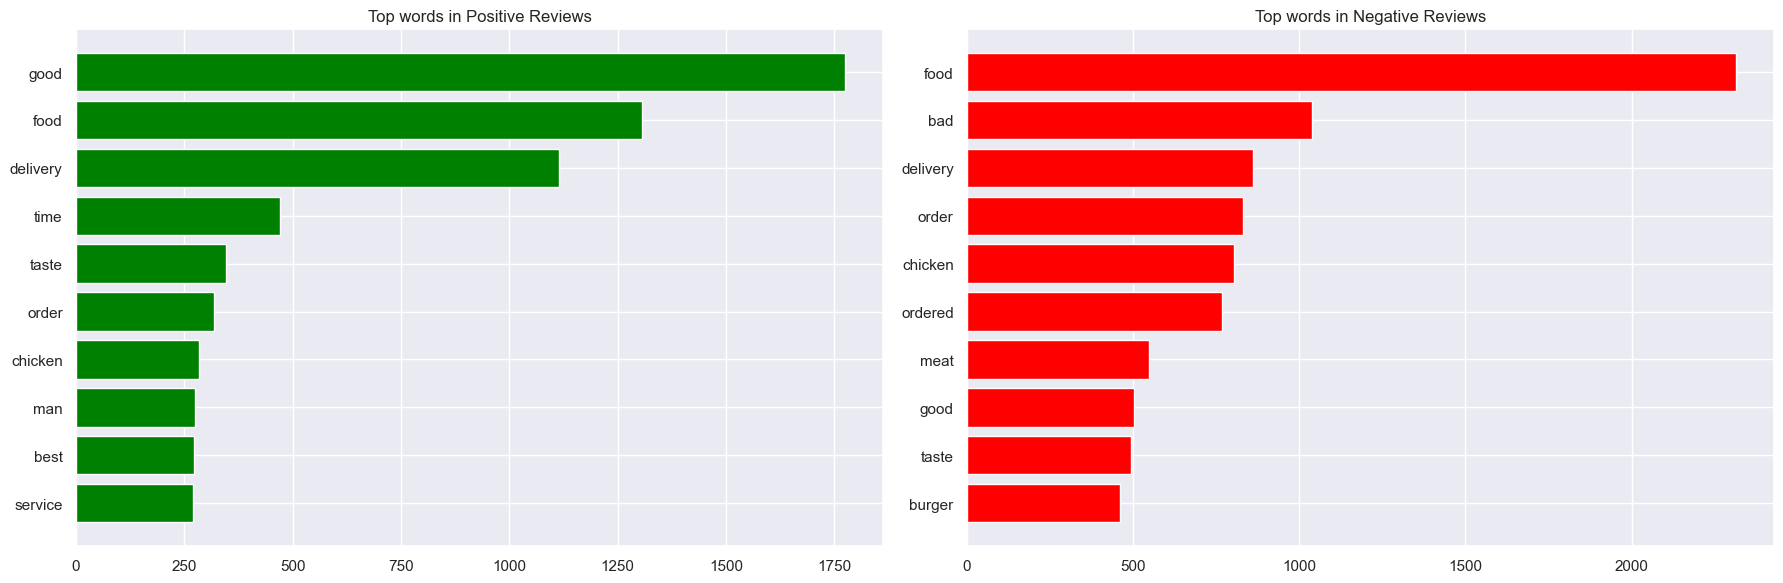

In [10]:
# Tokenize the reviews, remove stopwords, and count the word frequencies for positive and negative reviews separately.

# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Separate positive and negative reviews
positive_reviews = rws[rws['rating'] == 1]['review']
negative_reviews = rws[rws['rating'] == 0]['review']

# Apply the cleaning and tokenization function
positive_tokens = positive_reviews.apply(clean_tokenize).sum()
negative_tokens = negative_reviews.apply(clean_tokenize).sum()

# Count the frequencies of words
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

# Get the 10 most common words in positive and negative reviews
most_common_positive = positive_freq.most_common(10)
most_common_negative = negative_freq.most_common(10)

# Separate the words and their counts for the plot
positive_words, positive_counts = zip(*most_common_positive)
negative_words, negative_counts = zip(*most_common_negative)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot for positive reviews
ax[0].barh(positive_words, positive_counts, color='green')
ax[0].set_title('Top words in Positive Reviews')
ax[0].invert_yaxis()  # Labels read top-to-bottom

# Plot for negative reviews
ax[1].barh(negative_words, negative_counts, color='red')
ax[1].set_title('Top words in Negative Reviews')
ax[1].invert_yaxis()  # Labels read top-to-bottom

# Display the plot
plt.tight_layout()
plt.show()


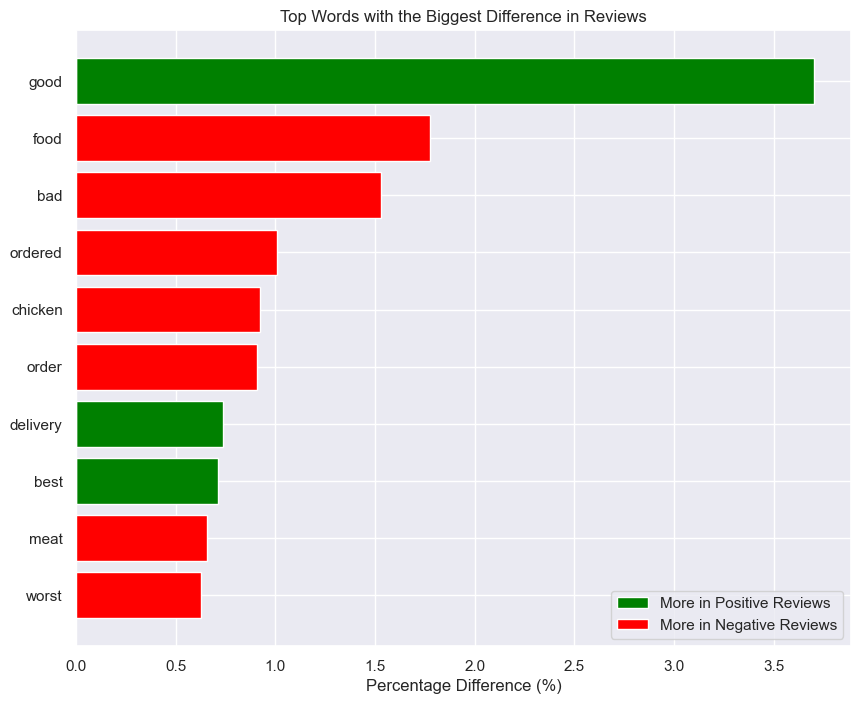

In [11]:
# Calculate the frequency difference for each word
frequency_diff = {word: positive_freq[word] - negative_freq[word] for word in set(positive_freq) | set(negative_freq)}

# Calculate the percentage difference for each word
total_pos_reviews = sum(positive_freq.values())
total_neg_reviews = sum(negative_freq.values())
percentage_diff = {word: (count / total_pos_reviews * 100 if count > 0 else count / total_neg_reviews * 100)
                   for word, count in frequency_diff.items()}

# Sort the words by the biggest absolute percentage difference
sorted_words = sorted(percentage_diff.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top words with the biggest difference
top_words = sorted_words[:10]  # Adjust the number as needed

# Split words and their percentage difference
words, differences = zip(*top_words)

# Split into positive and negative differences
pos_diffs = [percentage_diff[word] if percentage_diff[word] > 0 else 0 for word in words]
neg_diffs = [-percentage_diff[word] if percentage_diff[word] < 0 else 0 for word in words]

# Plotting
plt.figure(figsize=(10, 8))
y_pos = range(len(words))
plt.barh(y_pos, pos_diffs, color='green', label='More in Positive Reviews')
plt.barh(y_pos, neg_diffs, color='red', label='More in Negative Reviews')
plt.yticks(y_pos, words)
plt.xlabel('Percentage Difference (%)')
plt.title('Top Words with the Biggest Difference in Reviews')
plt.legend()
plt.gca().invert_yaxis()  # Highest percentages on top
plt.show()


### Text Preprocessing and Spliting

I will do text preprocessing in two distinct ways: 

**Large Cleaning Process :** This includes negation handling, emoji removal, lemmatization etc...

**Small Cleaning Process :** This maintaining more of the text's raw form.

*It will be beneficial to evaluate both versions with various models later on.*

Then I will also split the data into training and testing sets.

In [12]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def handle_negation(text):
    if text is None:
        return text
    # Pattern to detect negations followed by an alphanumeric word
    negation_pattern = re.compile(r'\b(not|no|never|none|nothing|nowhere|neither|nobody|cannot)\b[\s]*(\w+)')
    text = negation_pattern.sub(lambda x: f'{x.group(1)}_{x.group(2)}', text)
    return text

def full_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Handle negation
    text = handle_negation(text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # POS tagging
    nltk_pos_tagged = nltk.pos_tag(words)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_pos_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return ' '.join(lemmatized_words)

def raw_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

In [13]:
# Balance the dataset
# Separate the dataset into positives and negatives
positive_rws = rws[rws['rating'] == 1]
negative_rws = rws[rws['rating'] == 0]

# Downsample the majority class (positive reviews) to match the minority class (negative reviews)
min_count = min(len(positive_rws), len(negative_rws))
balanced_positive = positive_rws.sample(n=min_count, random_state=42)
balanced_negative = negative_rws.sample(n=min_count, random_state=42)

# Combine back to a single balanced dataframe
balanced_rws = pd.concat([balanced_positive, balanced_negative])

# Now perform a stratified split on the balanced dataset
train_rws, test_rws = train_test_split(balanced_rws, test_size=0.2, stratify=balanced_rws['rating'], random_state=42)

# Apply the thorough cleaning to the training and test sets
# Create new DataFrame for cleaned versions including ratings
cleaned_train = pd.DataFrame({
    'review': train_rws['review'].apply(full_clean_text),
    'rating': train_rws['rating']
})
cleaned_test = pd.DataFrame({
    'review': test_rws['review'].apply(full_clean_text),
    'rating': test_rws['rating']
})

# Apply the minimal cleaning to the training and test sets
# Create new DataFrame for raw versions including ratings
raw_train = pd.DataFrame({
    'review': train_rws['review'].apply(raw_clean_text),
    'rating': train_rws['rating']
})
raw_test = pd.DataFrame({
    'review': test_rws['review'].apply(raw_clean_text),
    'rating': test_rws['rating']
})

In [14]:
# Print the first two reviews from the cleaned training set
print("First two reviews from the Cleaned Training Set:")
print(cleaned_train['review'].iloc[0])
print(cleaned_train['review'].iloc[1])
print("\n")

# Print the first two reviews from the cleaned test set
print("First two reviews from the Cleaned Test Set:")
print(cleaned_test['review'].iloc[0])
print(cleaned_test['review'].iloc[1])
print("\n")

# Assuming the same indices can be used for the raw sets, since the split was stratified based on the rating
print("First two reviews from the Raw Training Set:")
print(raw_train['review'].iloc[0])
print(raw_train['review'].iloc[1])
print("\n")

print("First two reviews from the Raw Test Set:")
print(raw_test['review'].iloc[0])
print(raw_test['review'].iloc[1])

First two reviews from the Cleaned Training Set:
bhuna khichuri plenty meatbeef ittaste also good
delivery time


First two reviews from the Cleaned Test Set:
bad food cold soggy bag rip entire soda go waste no_cheese cheeseburger
please continue consistency pizza excellent taste really fresh also whole family could enjoy definitely order


First two reviews from the Raw Training Set:
Bhuna khichuri had plenty of meat ( Beef ) in it.Taste was also good .
delivery time


First two reviews from the Raw Test Set:
It was very bad . The food was cold and soggy . The bag ripped and my entire soda went to waste . And there was no cheese in my cheeseburger
Please continue this consistency ! The pizza is excellent ! It tasted really fresh ! Also my whole family could enjoy it . Definitely ordering again .


In [15]:
# Count the occurrences of each class in the 'rating' column for both training and test sets
count_train = Counter(cleaned_train['rating'])
count_test = Counter(cleaned_test['rating'])
count_raw_train = Counter(raw_train['rating'])
count_raw_test = Counter(raw_test['rating'])

print("Counts for Cleaned Training Set:", count_train)
print("Counts for Cleaned Test Set:", count_test)
print("Counts for Raw Training Set:", count_raw_train)
print("Counts for Raw Test Set:", count_raw_test)


Counts for Cleaned Training Set: Counter({1: 4942, 0: 4942})
Counts for Cleaned Test Set: Counter({0: 1236, 1: 1236})
Counts for Raw Training Set: Counter({1: 4942, 0: 4942})
Counts for Raw Test Set: Counter({0: 1236, 1: 1236})


## Modelling

### Naive Bayes

First, I will be evaluating a Multinomial Naive Bayes model as my baseline

#### Naive Bayes with cleaned data (TF-IDF)

In [16]:
# Convert ratings to numeric codes if they are categorical
cleaned_train['rating'] = cleaned_train['rating'].astype('category').cat.codes
cleaned_test['rating'] = cleaned_test['rating'].astype('category').cat.codes

cX_train = cleaned_train['review']
cy_train = cleaned_train['rating']
cX_test = cleaned_test['review']
cy_test = cleaned_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
cX_train_tfidf = tfidf_vectorizer.fit_transform(cX_train)
cX_test_tfidf = tfidf_vectorizer.transform(cX_test)

# Training a Multinomial Naive Bayes model
model_0cTI = MultinomialNB()
model_0cTI.fit(cX_train_tfidf, cy_train)

# Predicting the ratings
start_time = timeit.default_timer()
cy_pred = model_0cTI.predict(cX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate other metrics
m0cTI_accuracy = accuracy_score(cy_test, cy_pred)
m0cTI_precision = precision_score(cy_test, cy_pred, average='weighted')
m0cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m0cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0cTI_accuracy:.2%}", f"{m0cTI_precision:.3f}", f"{m0cTI_recall:.3f}", f"{m0cTI_f1:.3f}", f"{m0cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


Model Performance          Results
         accuracy           78.80%
        precision            0.793
           recall            0.788
         f1_score            0.787
    time/instance 0.000001 seconds


#### Naive Bayes with raw data (TF-IDF)

In [17]:
# Convert ratings to numeric codes if they are categorical
raw_train['rating'] = raw_train['rating'].astype('category').cat.codes
raw_test['rating'] = raw_test['rating'].astype('category').cat.codes

rX_train = raw_train['review']
ry_train = raw_train['rating']
rX_test = raw_test['review']
ry_test = raw_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
rX_train_tfidf = tfidf_vectorizer.fit_transform(rX_train)
rX_test_tfidf = tfidf_vectorizer.transform(rX_test)

# Training a Multinomial Naive Bayes model
model_0rTI = MultinomialNB()
model_0rTI.fit(rX_train_tfidf, ry_train)

# Predicting the ratings
start_time = timeit.default_timer()
ry_pred = model_0rTI.predict(rX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate other metrics
m0rTI_accuracy = accuracy_score(ry_test, ry_pred)
m0rTI_precision = precision_score(ry_test, ry_pred, average='weighted')
m0rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m0rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0rTI_accuracy:.2%}", f"{m0rTI_precision:.3f}", f"{m0rTI_recall:.3f}", f"{m0rTI_f1:.3f}", f"{m0rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

Model Performance          Results
         accuracy           78.92%
        precision            0.795
           recall            0.789
         f1_score            0.788
    time/instance 0.000000 seconds


#### Storing Results

In [18]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time per Instance'])

def store_results(model_name, accuracy, precision, recall, f1_score, time_per_instance):
    # Append the new results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': f"{accuracy:.2%}",
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1_score:.3f}",
        'Time per Instance': f"{time_per_instance:.6f} seconds"
    }

# Store the results for the cleaned text model with TF-IDF
store_results('Model_0cTI', m0cTI_accuracy, m0cTI_precision, m0cTI_recall, m0cTI_f1, m0cTI_time_per_instance)

# Store the results for the raw text model with TF-IDF
store_results('Model_0rTI', m0rTI_accuracy, m0rTI_precision, m0rTI_recall, m0rTI_f1, m0rTI_time_per_instance)

# View the consolidated results
print(results_df)


        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds


### FNN

My initial model is a Feedforward Neural Network (FNN) with 2 different vectorization (TF-IDF and Word2Vec)

#### FNN with cleaned data (TF-IDF)

In [19]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [20]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}


# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_tfidf, cy_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6837 - loss: 0.6471
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8206 - loss: 0.4377
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8608 - loss: 0.3493
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8761 - loss: 0.3085
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8967 - loss: 0.2776
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9024 - loss: 0.2612
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9047 - loss: 0.2435
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9116 - loss: 0.2321
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9183 - loss: 0.2287
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9159 - loss: 0.2139
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9236 - loss: 0.2113
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7060 - loss: 0.6477
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8318 - loss: 0.4279
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8670 - loss: 0.3442
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8832 - loss: 0.3033
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8979 - loss: 0.2710
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9029 - loss: 0.2555
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9088 - loss: 0.2399
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9146 - loss: 0.2244
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9135 - loss: 0.2196
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9171 - loss: 0.2161
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9218 - loss: 0.2004
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7174 - loss: 0.6424
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8302 - loss: 0.4320
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8679 - loss: 0.3385
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8843 - loss: 0.3037
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8994 - loss: 0.2671
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9068 - loss: 0.2444
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9143 - loss: 0.2264
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9192 - loss: 0.2170
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9203 - loss: 0.2098
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9196 - loss: 0.2028
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9199 - loss: 0.2037
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6868 - loss: 0.7104
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8013 - loss: 0.5451
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8119 - loss: 0.5207
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8273 - loss: 0.5113
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8306 - loss: 0.4957
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8392 - loss: 0.4947
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8393 - loss: 0.4822
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8444 - loss: 0.4836
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8510 - loss: 0.4787
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8537 - loss: 0.4672
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8525 - loss: 0.4652
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6850 - loss: 0.7127
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8092 - loss: 0.5445
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8132 - loss: 0.5223
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8270 - loss: 0.5021
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8380 - loss: 0.4944
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8419 - loss: 0.4895
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8520 - loss: 0.4788
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8434 - loss: 0.4768
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8395 - loss: 0.4832
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8510 - loss: 0.4686
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8544 - loss: 0.4612
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7080 - loss: 0.7108
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8135 - loss: 0.5405
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8206 - loss: 0.5085
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8310 - loss: 0.5018
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8351 - loss: 0.4827
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8402 - loss: 0.4812
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8440 - loss: 0.4725
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8506 - loss: 0.4651
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8508 - loss: 0.4628
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8709 - loss: 0.4455
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8606 - loss: 0.4541
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6712 - loss: 0.6201
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8407 - loss: 0.3785
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8789 - loss: 0.3072
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8978 - loss: 0.2615
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9027 - loss: 0.2477
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9008 - loss: 0.2416
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9087 - loss: 0.2189
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9161 - loss: 0.2084
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9208 - loss: 0.2034
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9175 - loss: 0.1970
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9232 - loss: 0.1918
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6989 - loss: 0.6185
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8563 - loss: 0.3652
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8854 - loss: 0.2930
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8924 - loss: 0.2603
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9062 - loss: 0.2416
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9046 - loss: 0.2264
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9162 - loss: 0.2060
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9182 - loss: 0.2078
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9187 - loss: 0.2030
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9186 - loss: 0.2006
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9206 - loss: 0.1947
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6664 - loss: 0.6181
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8493 - loss: 0.3707
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8875 - loss: 0.2939
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8963 - loss: 0.2576
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9074 - loss: 0.2329
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9175 - loss: 0.2095
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9281 - loss: 0.1970
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9245 - loss: 0.2008
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9284 - loss: 0.1884
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9227 - loss: 0.1952
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9225 - loss: 0.1848
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6803 - loss: 0.7552
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8172 - loss: 0.5333
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8429 - loss: 0.4982
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8448 - loss: 0.4921
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8604 - loss: 0.4846
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8607 - loss: 0.4754
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8697 - loss: 0.4664
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8710 - loss: 0.4531
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8656 - loss: 0.4598
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8758 - loss: 0.4337
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8769 - loss: 0.4370
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6658 - loss: 0.7552
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8241 - loss: 0.5182
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8354 - loss: 0.5054
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8543 - loss: 0.4865
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8482 - loss: 0.4857
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8680 - loss: 0.4640
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8728 - loss: 0.4664
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8766 - loss: 0.4448
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8730 - loss: 0.4512
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8761 - loss: 0.4402
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8811 - loss: 0.4306
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6890 - loss: 0.7526
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8175 - loss: 0.5291
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8477 - loss: 0.4919
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8509 - loss: 0.4885
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8572 - loss: 0.4770
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8634 - loss: 0.4578
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8712 - loss: 0.4504
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8753 - loss: 0.4432
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8745 - loss: 0.4576
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8814 - loss: 0.4221
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8865 - loss: 0.4216
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7097 - loss: 0.6321
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8277 - loss: 0.4079
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8594 - loss: 0.3441
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8826 - loss: 0.2967
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8974 - loss: 0.2636
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9080 - loss: 0.2395
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9078 - loss: 0.2344
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9150 - loss: 0.2132
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9155 - loss: 0.2109
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9220 - loss: 0.1952
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9266 - loss: 0.1926
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6872 - loss: 0.6304
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8421 - loss: 0.3978
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8669 - loss: 0.3389
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8918 - loss: 0.2814
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9020 - loss: 0.2506
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9034 - loss: 0.2452
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9156 - loss: 0.2169
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9128 - loss: 0.2196
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9227 - loss: 0.1988
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9258 - loss: 0.1921
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9188 - loss: 0.1989
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7124 - loss: 0.6295
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8447 - loss: 0.3889
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8798 - loss: 0.3198
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8963 - loss: 0.2795
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9012 - loss: 0.2535
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9116 - loss: 0.2260
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9223 - loss: 0.2178
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9221 - loss: 0.2034
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9272 - loss: 0.1922
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9279 - loss: 0.1922
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9304 - loss: 0.1847
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7199 - loss: 0.7503
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7981 - loss: 0.5482
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8155 - loss: 0.5193
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8228 - loss: 0.5172
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8293 - loss: 0.5035
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8284 - loss: 0.5196
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8255 - loss: 0.5157
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8352 - loss: 0.5091
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8414 - loss: 0.5015
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8374 - loss: 0.4960
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8402 - loss: 0.4986
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7248 - loss: 0.7500
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8036 - loss: 0.5383
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8161 - loss: 0.5238
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8314 - loss: 0.5068
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8287 - loss: 0.5049
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8354 - loss: 0.5041
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8467 - loss: 0.4832
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8408 - loss: 0.4957
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8416 - loss: 0.5043
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8500 - loss: 0.4842
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8549 - loss: 0.4828
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7103 - loss: 0.7466
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8160 - loss: 0.5239
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8278 - loss: 0.5117
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8289 - loss: 0.5068
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8358 - loss: 0.4940
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8441 - loss: 0.4876
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8388 - loss: 0.4949
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8468 - loss: 0.4838
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8517 - loss: 0.4773
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8485 - loss: 0.4849
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8629 - loss: 0.4716
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6769 - loss: 0.6002
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8502 - loss: 0.3674
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8856 - loss: 0.2918
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9006 - loss: 0.2634
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9101 - loss: 0.2355
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9094 - loss: 0.2270
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9117 - loss: 0.2156
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9185 - loss: 0.2000
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9147 - loss: 0.2036
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9209 - loss: 0.1886
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9268 - loss: 0.1827
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7040 - loss: 0.5969
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8544 - loss: 0.3626
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8826 - loss: 0.2937
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9125 - loss: 0.2402
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9137 - loss: 0.2204
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9092 - loss: 0.2220
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9187 - loss: 0.2087
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9166 - loss: 0.2016
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9241 - loss: 0.1950
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9209 - loss: 0.1945
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9237 - loss: 0.1887
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7206 - loss: 0.5921
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8540 - loss: 0.3608
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8917 - loss: 0.2844
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9088 - loss: 0.2374
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9149 - loss: 0.2283
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9115 - loss: 0.2172
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9235 - loss: 0.1949
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9253 - loss: 0.2009
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9243 - loss: 0.1843
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9218 - loss: 0.1895
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9307 - loss: 0.1772
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6570 - loss: 0.8211
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8173 - loss: 0.5301
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8347 - loss: 0.5204
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8397 - loss: 0.5051
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8497 - loss: 0.4940
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8533 - loss: 0.4900
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8549 - loss: 0.4778
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8598 - loss: 0.4606
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8720 - loss: 0.4494
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8828 - loss: 0.4386
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8827 - loss: 0.4413
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6750 - loss: 0.8220
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8230 - loss: 0.5297
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8365 - loss: 0.5103
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8514 - loss: 0.4904
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8525 - loss: 0.4973
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8589 - loss: 0.4736
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8705 - loss: 0.4689
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8669 - loss: 0.4526
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8803 - loss: 0.4398
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8781 - loss: 0.4475
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8898 - loss: 0.4232
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6889 - loss: 0.8188
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8213 - loss: 0.5235
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8386 - loss: 0.5094
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8523 - loss: 0.4857
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8630 - loss: 0.4730
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8618 - loss: 0.4666
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8751 - loss: 0.4537
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8707 - loss: 0.4460
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8841 - loss: 0.4365
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8817 - loss: 0.4314
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8909 - loss: 0.4181
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6036 - loss: 0.6901
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7894 - loss: 0.6723
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7968 - loss: 0.6474
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8153 - loss: 0.6165
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8266 - loss: 0.5820
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8270 - loss: 0.5470
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8308 - loss: 0.5164
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8349 - loss: 0.4864
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8414 - loss: 0.4628
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8348 - loss: 0.4475
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8472 - loss: 0.4344
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6376 - loss: 0.6892
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7921 - loss: 0.6713
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8188 - loss: 0.6451
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8186 - loss: 0.6137
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8289 - loss: 0.5783
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8403 - loss: 0.5449
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8384 - loss: 0.5155
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8439 - loss: 0.4865
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8459 - loss: 0.4601
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8532 - loss: 0.4453
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8633 - loss: 0.4208
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6251 - loss: 0.6897
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7919 - loss: 0.6722
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8126 - loss: 0.6457
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8246 - loss: 0.6117
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8220 - loss: 0.5790
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8284 - loss: 0.5437
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8441 - loss: 0.5054
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8443 - loss: 0.4812
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8444 - loss: 0.4593
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8535 - loss: 0.4370
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8553 - loss: 0.4214
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6186 - loss: 0.8640
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7936 - loss: 0.7094
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8011 - loss: 0.6684
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8068 - loss: 0.6398
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8128 - loss: 0.6149
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8060 - loss: 0.5962
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8071 - loss: 0.5768
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8135 - loss: 0.5597
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8204 - loss: 0.5443
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8184 - loss: 0.5338
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8165 - loss: 0.5296
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5972 - loss: 0.8648
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7886 - loss: 0.7102
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8060 - loss: 0.6702
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8008 - loss: 0.6446
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8106 - loss: 0.6174
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8142 - loss: 0.5968
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8008 - loss: 0.5825
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8094 - loss: 0.5628
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8099 - loss: 0.5512
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8137 - loss: 0.5426
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8177 - loss: 0.5379
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6134 - loss: 0.8643
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7917 - loss: 0.7098
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8073 - loss: 0.6687
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8117 - loss: 0.6407
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8074 - loss: 0.6160
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8170 - loss: 0.5903
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8246 - loss: 0.5707
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8203 - loss: 0.5573
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8233 - loss: 0.5442
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8250 - loss: 0.5315
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8256 - loss: 0.5230
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5824 - loss: 0.6916
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7920 - loss: 0.6731
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8117 - loss: 0.6032
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8145 - loss: 0.5058
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8314 - loss: 0.4343
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8414 - loss: 0.3941
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8554 - loss: 0.3664
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8567 - loss: 0.3599
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8654 - loss: 0.3362
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8696 - loss: 0.3336
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8866 - loss: 0.3036
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6198 - loss: 0.6907
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7805 - loss: 0.6697
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7999 - loss: 0.5989
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8322 - loss: 0.4950
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8383 - loss: 0.4311
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8501 - loss: 0.3922
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8662 - loss: 0.3547
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8683 - loss: 0.3481
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8767 - loss: 0.3204
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8823 - loss: 0.3105
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8940 - loss: 0.2795
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5970 - loss: 0.6912
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7695 - loss: 0.6729
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8168 - loss: 0.6048
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8330 - loss: 0.5034
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8422 - loss: 0.4301
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8457 - loss: 0.3972
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8609 - loss: 0.3708
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8747 - loss: 0.3286
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8793 - loss: 0.3181
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8805 - loss: 0.3121
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8905 - loss: 0.2968
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5649 - loss: 0.9443
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7767 - loss: 0.7707
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7925 - loss: 0.7131
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8015 - loss: 0.6455
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8138 - loss: 0.5887
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8214 - loss: 0.5458
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8269 - loss: 0.5202
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8311 - loss: 0.5101
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8402 - loss: 0.4983
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8462 - loss: 0.4873
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8512 - loss: 0.4709
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5852 - loss: 0.9439
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7862 - loss: 0.7701
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7973 - loss: 0.7096
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8071 - loss: 0.6382
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8247 - loss: 0.5711
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8299 - loss: 0.5346
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8369 - loss: 0.5243
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8485 - loss: 0.5015
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8437 - loss: 0.4994
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8517 - loss: 0.4809
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8522 - loss: 0.4761
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5791 - loss: 0.9413
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7807 - loss: 0.7673
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8121 - loss: 0.7083
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8126 - loss: 0.6425
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8175 - loss: 0.5756
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8325 - loss: 0.5361
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8382 - loss: 0.5132
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8409 - loss: 0.4946
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8504 - loss: 0.4876
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8580 - loss: 0.4738
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8560 - loss: 0.4732
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6272 - loss: 0.6886
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7827 - loss: 0.6617
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8165 - loss: 0.6232
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8162 - loss: 0.5758
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8258 - loss: 0.5323
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8243 - loss: 0.4927
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8391 - loss: 0.4554
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8469 - loss: 0.4315
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8400 - loss: 0.4208
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8503 - loss: 0.4008
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8519 - loss: 0.3847
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6211 - loss: 0.6887
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8057 - loss: 0.6620
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8271 - loss: 0.6226
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8278 - loss: 0.5761
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8312 - loss: 0.5281
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8450 - loss: 0.4855
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8549 - loss: 0.4558
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8565 - loss: 0.4313
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8548 - loss: 0.4053
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8618 - loss: 0.3885
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8658 - loss: 0.3777
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6208 - loss: 0.6890
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8053 - loss: 0.6641
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8098 - loss: 0.6257
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8283 - loss: 0.5735
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8266 - loss: 0.5305
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8442 - loss: 0.4849
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8421 - loss: 0.4549
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8478 - loss: 0.4308
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8576 - loss: 0.4054
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8563 - loss: 0.3930
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8599 - loss: 0.3820
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6272 - loss: 1.0260
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7860 - loss: 0.7243
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8017 - loss: 0.6568
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8079 - loss: 0.6183
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8031 - loss: 0.5902
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8085 - loss: 0.5659
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8145 - loss: 0.5469
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8140 - loss: 0.5362
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8243 - loss: 0.5186
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8254 - loss: 0.5152
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8169 - loss: 0.5130
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6272 - loss: 1.0266
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7934 - loss: 0.7255
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8064 - loss: 0.6580
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8074 - loss: 0.6225
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8062 - loss: 0.5926
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8152 - loss: 0.5645
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8210 - loss: 0.5464
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8231 - loss: 0.5336
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8249 - loss: 0.5232
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8178 - loss: 0.5286
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8247 - loss: 0.5148
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6332 - loss: 1.0261
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7919 - loss: 0.7234
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8054 - loss: 0.6569
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8209 - loss: 0.6141
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8155 - loss: 0.5833
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8156 - loss: 0.5652
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8275 - loss: 0.5405
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8172 - loss: 0.5300
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8292 - loss: 0.5158
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8260 - loss: 0.5149
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8365 - loss: 0.4967
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6158 - loss: 0.6896
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8004 - loss: 0.6389
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8215 - loss: 0.4987
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8271 - loss: 0.4183
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8430 - loss: 0.3759
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8668 - loss: 0.3417
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8704 - loss: 0.3187
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8826 - loss: 0.2990
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8916 - loss: 0.2804
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8936 - loss: 0.2712
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9001 - loss: 0.2543
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5914 - loss: 0.6905
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8013 - loss: 0.6456
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8203 - loss: 0.5067
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8500 - loss: 0.4090
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8601 - loss: 0.3624
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8631 - loss: 0.3489
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8722 - loss: 0.3154
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8887 - loss: 0.2939
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8928 - loss: 0.2754
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8897 - loss: 0.2763
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9014 - loss: 0.2647
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6437 - loss: 0.6887
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8078 - loss: 0.6312
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8278 - loss: 0.4929
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8484 - loss: 0.4055
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8660 - loss: 0.3540
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8707 - loss: 0.3355
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8836 - loss: 0.3035
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8930 - loss: 0.2871
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8922 - loss: 0.2896
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8941 - loss: 0.2636
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9107 - loss: 0.2443
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6111 - loss: 1.1789
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7733 - loss: 0.8202
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7954 - loss: 0.6904
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8064 - loss: 0.5945
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8266 - loss: 0.5363
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8337 - loss: 0.5156
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8376 - loss: 0.4945
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8491 - loss: 0.4881
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8447 - loss: 0.4842
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8559 - loss: 0.4694
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8603 - loss: 0.4617
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5879 - loss: 1.1803
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7780 - loss: 0.8210
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8050 - loss: 0.6860
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8150 - loss: 0.5845
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8295 - loss: 0.5364
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8397 - loss: 0.5063
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8501 - loss: 0.4933
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8577 - loss: 0.4794
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8554 - loss: 0.4734
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8640 - loss: 0.4690
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8596 - loss: 0.4601
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5955 - loss: 1.1797
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7899 - loss: 0.8190
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7991 - loss: 0.6882
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8200 - loss: 0.5851
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8259 - loss: 0.5417
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8333 - loss: 0.5083
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8500 - loss: 0.4867
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8488 - loss: 0.4869
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8552 - loss: 0.4755
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8556 - loss: 0.4697
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8652 - loss: 0.4514
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6579 - loss: 0.9783
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7846 - loss: 0.6779
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8109 - loss: 0.6141
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8041 - loss: 0.5757
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8032 - loss: 0.5493
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8104 - loss: 0.5315
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8054 - loss: 0.5222
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8129 - loss: 0.5112
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8191 - loss: 0.5036
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8268 - loss: 0.4960
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8294 - loss: 0.4946
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/ste

In [21]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793908 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.729461 (0.006915) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.782678 (0.010583) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.734014 (0.001852) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.767604 (0.002129) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.729865 (0.008956) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.777417 (0.008212) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.738769 (0.004908) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.766896 (0.003133) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.788243 (0.007041) with: {'learning_ra

In [22]:
# Extract the best parameters
best_params = grid_result.best_params_

In [23]:
# Create the final model using the best parameters
model_1cTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ (None, 256)            │     1,714,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,714,433 (6.54 MB)

 Trainable params: 1,714,433 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

None


python(85940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(85941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


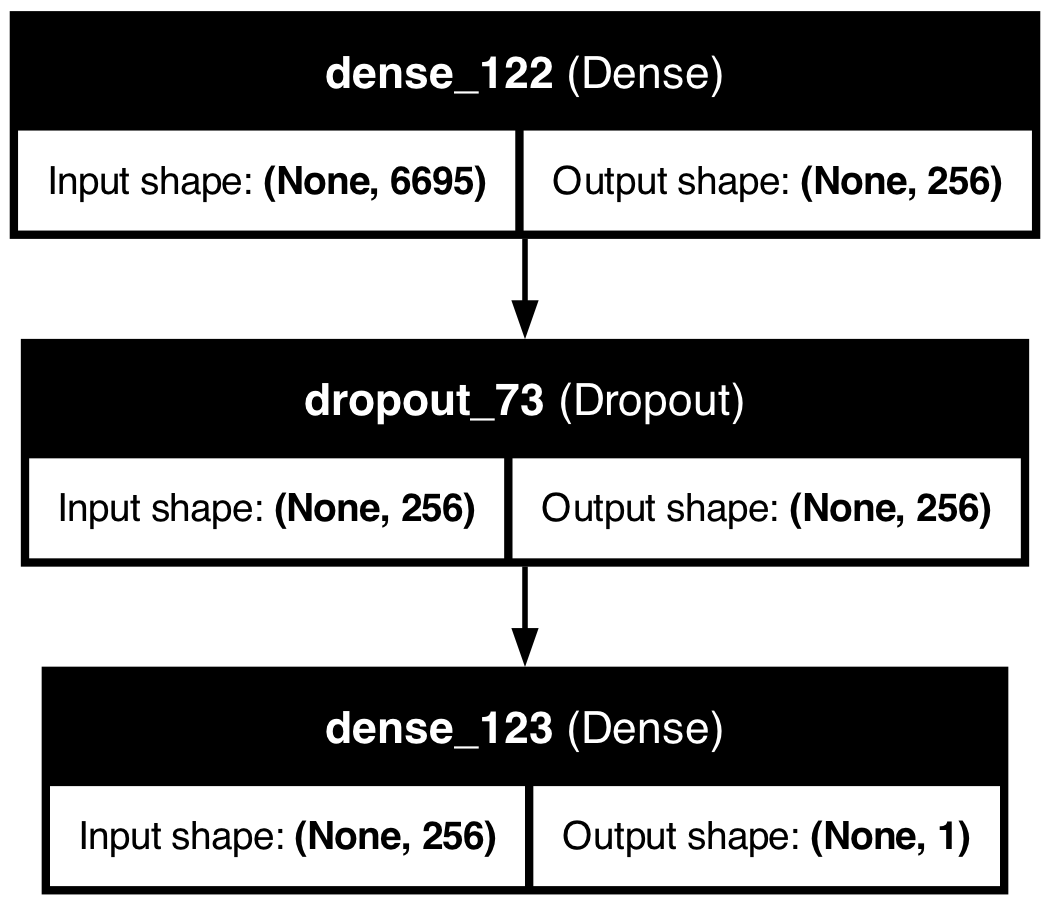

In [24]:
# Generate the plot
plot_model(model_1cTI, show_shapes=True, show_layer_names=True)

In [25]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cTI_history = model_1cTI.fit(
    cX_train_tfidf, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/300
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6355 - loss: 1.0068
Epoch 1: val_loss improved from inf to 0.73000, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6364 - loss: 1.0053 - val_accuracy: 0.7653 - val_loss: 0.7300 - learning_rate: 1.0000e-04
Epoch 2/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7990 - loss: 0.7031
Epoch 2: val_loss improved from 0.73000 to 0.65630, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7990 - loss: 0.7030 - val_accuracy: 0.7663 - val_loss: 0.6563 - learning_rate: 1.0000e-04
Epoch 3/300
245/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8072 - loss: 0.6393
Epoch 3: val_loss improved from 0.65630 to 0.61731, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8072 - loss: 0.6392 - val_accuracy: 0.7724 - val_loss: 0.6173 - learning_rate: 1.0000e-04
Epoch 4/300
245/248 ━━━━━━━━━━━━━━━━━━━━ 0s 13m

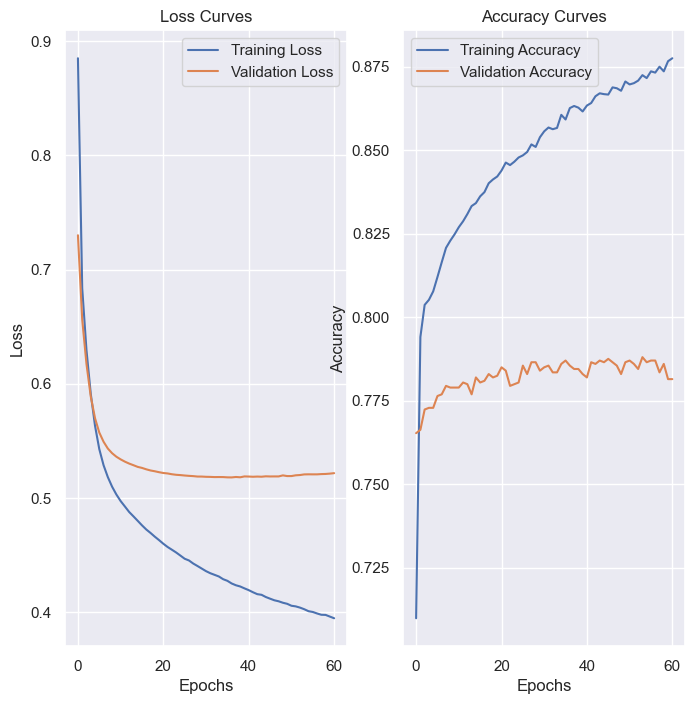

In [26]:
# Create a function to vizuualize the training and validation loss and accuracy
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
    history: TensorFlow History object.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Use the function with your model's history
plot_loss_curves(model_1cTI_history)

In [27]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cTI.predict(cX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cTI_accuracy = accuracy_score(cy_test, cy_pred)
m1cTI_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cTI_accuracy:.2%}", f"{m1cTI_precision:.3f}", f"{m1cTI_recall:.3f}", f"{m1cTI_f1:.3f}", f"{m1cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           78.28%
        precision            0.785
           recall            0.783
         f1_score            0.782
    time/instance 0.000226 seconds


In [28]:
store_results('Model_1cTI', m1cTI_accuracy, m1cTI_precision, m1cTI_recall, m1cTI_f1, m1cTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds


#### FNN with raw data (TF-IDF)

In [29]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [30]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_tfidf, ry_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6975 - loss: 0.6468
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8214 - loss: 0.4295
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8541 - loss: 0.3546
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8741 - loss: 0.3134
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8904 - loss: 0.2711
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9028 - loss: 0.2556
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9073 - loss: 0.2402
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9086 - loss: 0.2371
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9153 - loss: 0.2244
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9173 - loss: 0.2173
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9217 - loss: 0.2069
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7034 - loss: 0.6446
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8328 - loss: 0.4230
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8596 - loss: 0.3516
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8825 - loss: 0.2976
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8967 - loss: 0.2728
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9060 - loss: 0.2481
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9129 - loss: 0.2270
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9166 - loss: 0.2169
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9166 - loss: 0.2124
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9186 - loss: 0.2019
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9213 - loss: 0.1965
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6907 - loss: 0.6453
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8259 - loss: 0.4245
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8628 - loss: 0.3395
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8820 - loss: 0.3096
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8918 - loss: 0.2786
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9058 - loss: 0.2520
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9162 - loss: 0.2295
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9162 - loss: 0.2166
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9185 - loss: 0.2119
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9219 - loss: 0.1999
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9265 - loss: 0.1899
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6690 - loss: 0.7140
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7918 - loss: 0.5432
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8186 - loss: 0.5185
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8243 - loss: 0.5021
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8231 - loss: 0.4960
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8310 - loss: 0.4892
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8280 - loss: 0.4912
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8465 - loss: 0.4696
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8417 - loss: 0.4751
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8508 - loss: 0.4533
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8495 - loss: 0.4548
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7227 - loss: 0.7149
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7924 - loss: 0.5420
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8227 - loss: 0.5111
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8265 - loss: 0.5005
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8301 - loss: 0.4884
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8448 - loss: 0.4698
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8332 - loss: 0.4847
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8484 - loss: 0.4688
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8473 - loss: 0.4622
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8500 - loss: 0.4644
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8548 - loss: 0.4561
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7072 - loss: 0.7130
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8058 - loss: 0.5381
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8110 - loss: 0.5120
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8303 - loss: 0.4869
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8347 - loss: 0.4851
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8441 - loss: 0.4719
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8484 - loss: 0.4705
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8359 - loss: 0.4790
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8512 - loss: 0.4627
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8520 - loss: 0.4533
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8512 - loss: 0.4504
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6989 - loss: 0.6181
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8373 - loss: 0.3775
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8686 - loss: 0.3181
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8894 - loss: 0.2752
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9078 - loss: 0.2410
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9093 - loss: 0.2277
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9219 - loss: 0.2112
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9187 - loss: 0.2095
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9259 - loss: 0.2119
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9269 - loss: 0.1970
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9299 - loss: 0.1985
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6694 - loss: 0.6146
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8406 - loss: 0.3734
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8789 - loss: 0.2967
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9005 - loss: 0.2560
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9031 - loss: 0.2351
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9131 - loss: 0.2140
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9182 - loss: 0.2074
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9220 - loss: 0.1951
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9282 - loss: 0.1869
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9332 - loss: 0.1723
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9322 - loss: 0.1719
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7116 - loss: 0.6171
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8500 - loss: 0.3663
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8871 - loss: 0.2882
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9011 - loss: 0.2557
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9102 - loss: 0.2334
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9157 - loss: 0.2120
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9239 - loss: 0.2047
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9234 - loss: 0.1982
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9233 - loss: 0.1926
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9255 - loss: 0.1732
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9284 - loss: 0.1839
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6657 - loss: 0.7554
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8037 - loss: 0.5318
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8301 - loss: 0.4924
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8458 - loss: 0.4838
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8529 - loss: 0.4712
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8522 - loss: 0.4708
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8591 - loss: 0.4530
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8634 - loss: 0.4486
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8658 - loss: 0.4429
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8655 - loss: 0.4427
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8768 - loss: 0.4343
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6786 - loss: 0.7547
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8145 - loss: 0.5202
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8359 - loss: 0.4977
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8536 - loss: 0.4779
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8522 - loss: 0.4711
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8585 - loss: 0.4621
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8635 - loss: 0.4455
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8657 - loss: 0.4488
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8772 - loss: 0.4336
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8764 - loss: 0.4277
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8751 - loss: 0.4338
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6700 - loss: 0.7536
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8256 - loss: 0.5009
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8420 - loss: 0.4832
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8563 - loss: 0.4738
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8570 - loss: 0.4642
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8611 - loss: 0.4570
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8718 - loss: 0.4373
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8676 - loss: 0.4453
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8763 - loss: 0.4346
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8761 - loss: 0.4289
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8835 - loss: 0.4127
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6914 - loss: 0.6263
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8266 - loss: 0.4029
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8604 - loss: 0.3357
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8834 - loss: 0.2868
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8982 - loss: 0.2614
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9057 - loss: 0.2483
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9154 - loss: 0.2319
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9122 - loss: 0.2238
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9249 - loss: 0.1995
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9181 - loss: 0.2041
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9213 - loss: 0.1989
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7116 - loss: 0.6300
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8423 - loss: 0.3879
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8728 - loss: 0.3232
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8864 - loss: 0.2844
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9043 - loss: 0.2517
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9037 - loss: 0.2409
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9104 - loss: 0.2200
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9229 - loss: 0.1979
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9174 - loss: 0.2032
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9240 - loss: 0.1928
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9369 - loss: 0.1769
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7160 - loss: 0.6268
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8423 - loss: 0.3820
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8773 - loss: 0.3187
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8931 - loss: 0.2805
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9014 - loss: 0.2559
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9093 - loss: 0.2368
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9204 - loss: 0.2108
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9226 - loss: 0.2064
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9269 - loss: 0.1879
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9279 - loss: 0.1855
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9262 - loss: 0.1906
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7031 - loss: 0.7541
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7974 - loss: 0.5402
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8106 - loss: 0.5191
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8312 - loss: 0.5070
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8241 - loss: 0.5064
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8183 - loss: 0.5080
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8315 - loss: 0.4920
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8359 - loss: 0.4916
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8407 - loss: 0.4870
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8342 - loss: 0.4895
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8454 - loss: 0.4821
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6938 - loss: 0.7529
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8024 - loss: 0.5361
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8244 - loss: 0.5104
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8299 - loss: 0.4990
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8355 - loss: 0.5000
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8320 - loss: 0.4948
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8286 - loss: 0.5047
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8453 - loss: 0.4799
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8456 - loss: 0.4789
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8422 - loss: 0.4854
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8499 - loss: 0.4822
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7214 - loss: 0.7512
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8201 - loss: 0.5259
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8171 - loss: 0.5082
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8304 - loss: 0.5054
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8288 - loss: 0.5027
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8377 - loss: 0.4889
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8420 - loss: 0.4842
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8428 - loss: 0.4841
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8397 - loss: 0.4823
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8435 - loss: 0.4832
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8417 - loss: 0.4771
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6854 - loss: 0.5936
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8603 - loss: 0.3444
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8822 - loss: 0.2959
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8903 - loss: 0.2751
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9060 - loss: 0.2435
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9086 - loss: 0.2298
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9220 - loss: 0.2187
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9257 - loss: 0.1911
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9236 - loss: 0.1958
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9284 - loss: 0.1881
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9246 - loss: 0.1878
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6910 - loss: 0.5906
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8563 - loss: 0.3498
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8842 - loss: 0.2817
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9009 - loss: 0.2536
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9118 - loss: 0.2216
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9135 - loss: 0.2193
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9208 - loss: 0.2038
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9153 - loss: 0.2060
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9245 - loss: 0.1847
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9269 - loss: 0.1866
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9321 - loss: 0.1736
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6822 - loss: 0.5900
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8591 - loss: 0.3455
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8941 - loss: 0.2784
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9053 - loss: 0.2442
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9160 - loss: 0.2213
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9181 - loss: 0.2129
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9180 - loss: 0.2003
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9226 - loss: 0.2074
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9260 - loss: 0.1916
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9250 - loss: 0.1820
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9262 - loss: 0.1837
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6801 - loss: 0.8250
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8242 - loss: 0.5237
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8306 - loss: 0.5072
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8349 - loss: 0.5003
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8480 - loss: 0.4796
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8552 - loss: 0.4762
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8551 - loss: 0.4658
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8534 - loss: 0.4697
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8703 - loss: 0.4438
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8778 - loss: 0.4331
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8710 - loss: 0.4385
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6628 - loss: 0.8267
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8223 - loss: 0.5250
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8267 - loss: 0.5177
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8504 - loss: 0.4900
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8429 - loss: 0.4852
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8478 - loss: 0.4792
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8654 - loss: 0.4557
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8556 - loss: 0.4666
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8691 - loss: 0.4492
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8748 - loss: 0.4286
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8834 - loss: 0.4301
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6809 - loss: 0.8248
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8253 - loss: 0.5167
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8277 - loss: 0.5010
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8563 - loss: 0.4812
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8529 - loss: 0.4782
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8629 - loss: 0.4505
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8698 - loss: 0.4566
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8641 - loss: 0.4547
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8774 - loss: 0.4376
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8832 - loss: 0.4182
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8810 - loss: 0.4225
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6293 - loss: 0.6888
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7800 - loss: 0.6682
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7908 - loss: 0.6416
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7948 - loss: 0.6089
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8041 - loss: 0.5738
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8165 - loss: 0.5384
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8263 - loss: 0.5080
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8284 - loss: 0.4855
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8282 - loss: 0.4645
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8245 - loss: 0.4510
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8338 - loss: 0.4306
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6041 - loss: 0.6896
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7694 - loss: 0.6700
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8000 - loss: 0.6426
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8104 - loss: 0.6101
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8183 - loss: 0.5744
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8181 - loss: 0.5439
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8291 - loss: 0.5116
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8392 - loss: 0.4849
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8433 - loss: 0.4609
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8492 - loss: 0.4360
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8502 - loss: 0.4221
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6056 - loss: 0.6897
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7725 - loss: 0.6705
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7897 - loss: 0.6443
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7998 - loss: 0.6111
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8181 - loss: 0.5743
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8267 - loss: 0.5380
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8201 - loss: 0.5068
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8351 - loss: 0.4786
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8347 - loss: 0.4574
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8404 - loss: 0.4368
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8409 - loss: 0.4241
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6036 - loss: 0.8664
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7833 - loss: 0.7118
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7759 - loss: 0.6700
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7961 - loss: 0.6415
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7936 - loss: 0.6186
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8082 - loss: 0.5939
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7976 - loss: 0.5755
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8012 - loss: 0.5643
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7986 - loss: 0.5526
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8101 - loss: 0.5381
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8068 - loss: 0.5321
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6244 - loss: 0.8657
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7643 - loss: 0.7111
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7918 - loss: 0.6687
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7930 - loss: 0.6421
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7949 - loss: 0.6188
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8017 - loss: 0.5959
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8055 - loss: 0.5780
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8123 - loss: 0.5569
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8197 - loss: 0.5422
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8167 - loss: 0.5368
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8167 - loss: 0.5309
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6047 - loss: 0.8664
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7709 - loss: 0.7125
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7848 - loss: 0.6676
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7867 - loss: 0.6397
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7878 - loss: 0.6178
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7978 - loss: 0.5937
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7963 - loss: 0.5740
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8155 - loss: 0.5541
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8168 - loss: 0.5447
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8212 - loss: 0.5306
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8233 - loss: 0.5190
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6051 - loss: 0.6912
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7604 - loss: 0.6713
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7952 - loss: 0.6045
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8127 - loss: 0.5028
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8222 - loss: 0.4306
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8399 - loss: 0.3946
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8467 - loss: 0.3619
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8571 - loss: 0.3449
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8648 - loss: 0.3334
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8742 - loss: 0.3111
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8784 - loss: 0.3047
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5569 - loss: 0.6921
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7701 - loss: 0.6745
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7955 - loss: 0.6090
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8239 - loss: 0.5027
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8312 - loss: 0.4323
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8468 - loss: 0.3825
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8595 - loss: 0.3636
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8647 - loss: 0.3380
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8710 - loss: 0.3275
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8852 - loss: 0.3026
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8851 - loss: 0.3012
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6061 - loss: 0.6912
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7591 - loss: 0.6719
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7988 - loss: 0.5996
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8217 - loss: 0.4964
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8339 - loss: 0.4233
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8428 - loss: 0.3934
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8636 - loss: 0.3468
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8674 - loss: 0.3365
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8785 - loss: 0.3209
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8837 - loss: 0.2941
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8915 - loss: 0.2895
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5741 - loss: 0.9441
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7303 - loss: 0.7708
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7776 - loss: 0.7135
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7979 - loss: 0.6466
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8052 - loss: 0.5834
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8115 - loss: 0.5444
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8136 - loss: 0.5263
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8298 - loss: 0.5039
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8369 - loss: 0.4893
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8374 - loss: 0.4896
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8448 - loss: 0.4734
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6093 - loss: 0.9453
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7414 - loss: 0.7716
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7855 - loss: 0.7059
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8011 - loss: 0.6324
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8112 - loss: 0.5734
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8235 - loss: 0.5403
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8274 - loss: 0.5225
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8300 - loss: 0.5053
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8481 - loss: 0.4830
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8372 - loss: 0.4837
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8555 - loss: 0.4614
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5946 - loss: 0.9452
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7568 - loss: 0.7711
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7771 - loss: 0.7079
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7972 - loss: 0.6354
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8151 - loss: 0.5689
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8193 - loss: 0.5416
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8224 - loss: 0.5185
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8395 - loss: 0.4957
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8477 - loss: 0.4803
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8445 - loss: 0.4819
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8513 - loss: 0.4715
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6479 - loss: 0.6882
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7626 - loss: 0.6614
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7957 - loss: 0.6223
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7997 - loss: 0.5755
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8133 - loss: 0.5277
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8262 - loss: 0.4882
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8271 - loss: 0.4596
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8339 - loss: 0.4357
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8416 - loss: 0.4150
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8435 - loss: 0.3988
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8495 - loss: 0.3847
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6179 - loss: 0.6886
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7782 - loss: 0.6622
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8015 - loss: 0.6213
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8081 - loss: 0.5743
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8240 - loss: 0.5273
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8412 - loss: 0.4800
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8414 - loss: 0.4561
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8410 - loss: 0.4355
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8501 - loss: 0.4109
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8531 - loss: 0.4011
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8552 - loss: 0.3753
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6213 - loss: 0.6885
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7921 - loss: 0.6594
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8000 - loss: 0.6184
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8124 - loss: 0.5711
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8213 - loss: 0.5237
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8318 - loss: 0.4836
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8394 - loss: 0.4481
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8461 - loss: 0.4235
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8433 - loss: 0.4097
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8428 - loss: 0.3970
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8646 - loss: 0.3683
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6111 - loss: 1.0292
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7586 - loss: 0.7273
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7863 - loss: 0.6585
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7936 - loss: 0.6224
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7863 - loss: 0.5952
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7968 - loss: 0.5705
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8072 - loss: 0.5491
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8035 - loss: 0.5421
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8144 - loss: 0.5252
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8188 - loss: 0.5170
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8120 - loss: 0.5123
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6729 - loss: 1.0279
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7693 - loss: 0.7270
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7843 - loss: 0.6586
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7928 - loss: 0.6206
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8027 - loss: 0.5912
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8082 - loss: 0.5667
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8030 - loss: 0.5554
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8043 - loss: 0.5395
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8106 - loss: 0.5254
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8238 - loss: 0.5136
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8205 - loss: 0.5100
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6470 - loss: 1.0286
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7808 - loss: 0.7269
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7867 - loss: 0.6565
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7987 - loss: 0.6190
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8035 - loss: 0.5867
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8090 - loss: 0.5608
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8042 - loss: 0.5490
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8123 - loss: 0.5313
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8172 - loss: 0.5184
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8199 - loss: 0.5169
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8325 - loss: 0.4964
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6260 - loss: 0.6895
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7711 - loss: 0.6386
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8157 - loss: 0.4991
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8310 - loss: 0.4132
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8373 - loss: 0.3876
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8595 - loss: 0.3396
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8721 - loss: 0.3151
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8782 - loss: 0.3068
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8817 - loss: 0.2904
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8825 - loss: 0.2848
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8942 - loss: 0.2761
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6129 - loss: 0.6901
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7690 - loss: 0.6440
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8098 - loss: 0.4984
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8334 - loss: 0.4071
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8500 - loss: 0.3755
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8729 - loss: 0.3309
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8722 - loss: 0.3166
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8747 - loss: 0.3054
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8913 - loss: 0.2770
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8961 - loss: 0.2661
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9037 - loss: 0.2542
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6368 - loss: 0.6890
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7793 - loss: 0.6352
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8263 - loss: 0.4859
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8362 - loss: 0.4084
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8520 - loss: 0.3641
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8666 - loss: 0.3290
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8727 - loss: 0.3117
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8903 - loss: 0.2844
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8974 - loss: 0.2657
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8992 - loss: 0.2608
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9066 - loss: 0.2491
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6274 - loss: 1.1803
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7793 - loss: 0.8215
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7741 - loss: 0.6884
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8056 - loss: 0.5888
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8188 - loss: 0.5405
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8274 - loss: 0.5187
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8296 - loss: 0.4993
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8389 - loss: 0.4851
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8475 - loss: 0.4730
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8488 - loss: 0.4700
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8507 - loss: 0.4620
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6163 - loss: 1.1825
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7688 - loss: 0.8240
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7876 - loss: 0.6922
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8069 - loss: 0.5960
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8162 - loss: 0.5449
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8386 - loss: 0.5138
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8435 - loss: 0.4963
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8417 - loss: 0.4855
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8520 - loss: 0.4673
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8506 - loss: 0.4621
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8566 - loss: 0.4673
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5988 - loss: 1.1822
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7835 - loss: 0.8225
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7870 - loss: 0.6891
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8203 - loss: 0.5839
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8318 - loss: 0.5283
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8367 - loss: 0.5061
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8494 - loss: 0.4849
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8572 - loss: 0.4699
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8489 - loss: 0.4704
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8623 - loss: 0.4610
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8617 - loss: 0.4546
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6395 - loss: 0.8417
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7620 - loss: 0.6836
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7828 - loss: 0.6413
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7888 - loss: 0.6073
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7944 - loss: 0.5796
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8080 - loss: 0.5515
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7992 - loss: 0.5449
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8073 - loss: 0.5294
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8138 - loss: 0.5127
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8055 - loss: 0.5179
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8132 - loss: 0.5038
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy

In [31]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795629 using {'learning_rate': 0.0001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.741804 (0.006977) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.779442 (0.002432) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.745851 (0.007487) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.772966 (0.000677) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.735733 (0.010844) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.781668 (0.002352) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.744536 (0.003974) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.771550 (0.003079) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.790166 (0.001392) with: {'learning_ra

In [32]:
# Extract the best parameters
best_params = grid_result.best_params_

In [33]:
# Create the final model using the best parameters
model_1rTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)               │ (None, 128)            │       805,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,377 (3.07 MB)

 Trainable params: 805,377 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

None


python(87685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


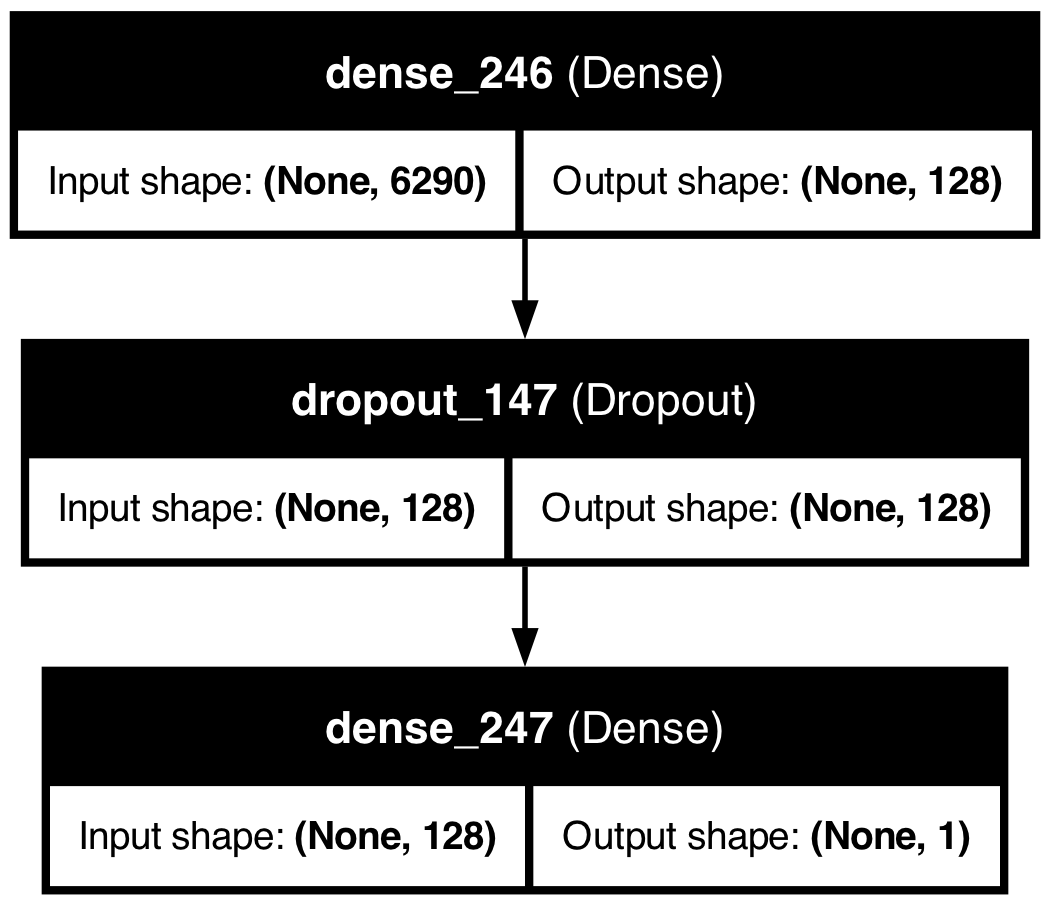

In [34]:
# Generate the plot
plot_model(model_1rTI, show_shapes=True, show_layer_names=True)

Epoch 1/300
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6335 - loss: 0.8556
Epoch 1: val_loss improved from inf to 0.71449, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6342 - loss: 0.8549 - val_accuracy: 0.7415 - val_loss: 0.7145 - learning_rate: 1.0000e-04
Epoch 2/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7721 - loss: 0.6977
Epoch 2: val_loss improved from 0.71449 to 0.66686, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7721 - loss: 0.6976 - val_accuracy: 0.7688 - val_loss: 0.6669 - learning_rate: 1.0000e-04
Epoch 3/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7894 - loss: 0.6551
Epoch 3: val_loss improved from 0.66686 to 0.63743, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7893 - loss: 0.6549 - val_accuracy: 0.7739 - val_loss: 0.6374 - learning_rate: 1.0000e-04
Epoch 4/300
243/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

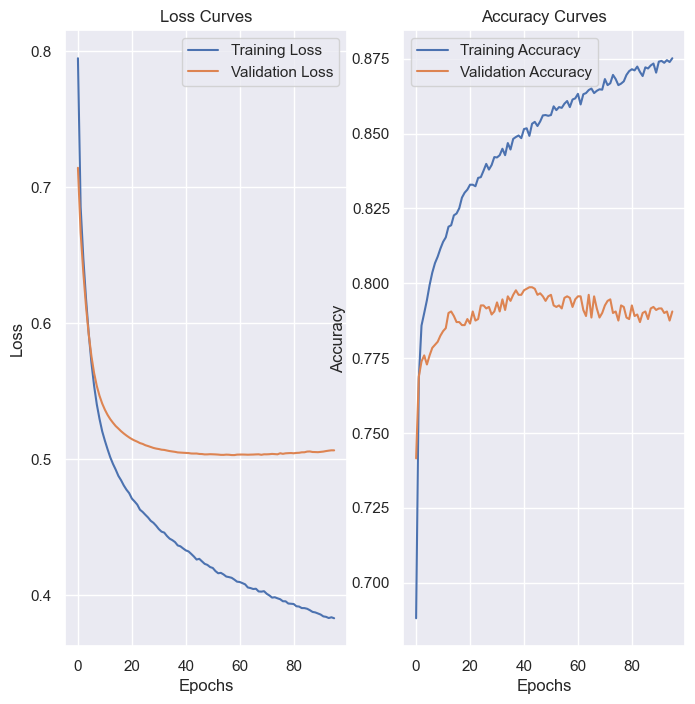

In [35]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1rTI_history = model_1rTI.fit(
    rX_train_tfidf, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_1rTI_history)

In [36]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rTI.predict(rX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rTI_accuracy = accuracy_score(ry_test, ry_pred)
m1rTI_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rTI_accuracy:.2%}", f"{m1rTI_precision:.3f}", f"{m1rTI_recall:.3f}", f"{m1rTI_f1:.3f}", f"{m1rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           79.37%
        precision            0.796
           recall            0.794
         f1_score            0.793
    time/instance 0.000206 seconds


In [37]:
store_results('Model_1rTI', m1rTI_accuracy, m1rTI_precision, m1rTI_recall, m1rTI_f1, m1rTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds


#### Word2Vec Vectorization

In [38]:
# Tokenize reviews
cleaned_train['tokenized_reviews'] = cleaned_train['review'].apply(gensim.utils.simple_preprocess)
cleaned_test['tokenized_reviews'] = cleaned_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_c = Word2Vec(sentences=cleaned_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
cX_train_vec = vectorize_reviews(cleaned_train['tokenized_reviews'], word2vec_model_c)
cX_test_vec = vectorize_reviews(cleaned_test['tokenized_reviews'], word2vec_model_c)

In [39]:
# Tokenize reviews
raw_train['tokenized_reviews'] = raw_train['review'].apply(gensim.utils.simple_preprocess)
raw_test['tokenized_reviews'] = raw_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_r = Word2Vec(sentences=raw_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
rX_train_vec = vectorize_reviews(raw_train['tokenized_reviews'], word2vec_model_r)
rX_test_vec = vectorize_reviews(raw_test['tokenized_reviews'], word2vec_model_r)

#### FNN with cleaned data (Word2Vec)

In [40]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [41]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_vec, cy_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5185 - loss: 0.6943
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5513 - loss: 0.6863
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5623 - loss: 0.6811
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5976 - loss: 0.6715
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5867 - loss: 0.6673
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6074 - loss: 0.6611
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 0.6522
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6214 - loss: 0.6448
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6217 - loss: 0.6460
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6533 - loss: 0.6278
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6419 - loss: 0.6335
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5038 - loss: 0.6944
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5405 - loss: 0.6883
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5666 - loss: 0.6843
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5904 - loss: 0.6758
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6015 - loss: 0.6662
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6096 - loss: 0.6558
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6026 - loss: 0.6554
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6326 - loss: 0.6464
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6432 - loss: 0.6401
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6519 - loss: 0.6291
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6343 - loss: 0.6380
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5116 - loss: 0.6944
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5542 - loss: 0.6853
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5826 - loss: 0.6748
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5862 - loss: 0.6748
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6244 - loss: 0.6601
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6142 - loss: 0.6565
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6280 - loss: 0.6465
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6469 - loss: 0.6401
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 0.6364
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6515 - loss: 0.6337
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6542 - loss: 0.6220
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5109 - loss: 0.8141
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5280 - loss: 0.7307
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5286 - loss: 0.7122
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5356 - loss: 0.7036
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5356 - loss: 0.6982
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5394 - loss: 0.6956
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5339 - loss: 0.6957
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5462 - loss: 0.6941
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5314 - loss: 0.6940
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5315 - loss: 0.6939
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5422 - loss: 0.6945
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5123 - loss: 0.8188
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5237 - loss: 0.7370
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5302 - loss: 0.7166
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5317 - loss: 0.7064
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5418 - loss: 0.7015
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5468 - loss: 0.6968
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5327 - loss: 0.6971
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5462 - loss: 0.6930
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5366 - loss: 0.6950
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5520 - loss: 0.6919
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5424 - loss: 0.6915
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4809 - loss: 0.8226
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5260 - loss: 0.7355
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5368 - loss: 0.7141
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5461 - loss: 0.7049
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5379 - loss: 0.7019
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5483 - loss: 0.6955
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5360 - loss: 0.6962
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 0.6903
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5490 - loss: 0.6936
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5406 - loss: 0.6926
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5419 - loss: 0.6917
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5004 - loss: 0.6970
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5286 - loss: 0.6915
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5518 - loss: 0.6867
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5777 - loss: 0.6779
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5931 - loss: 0.6711
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6123 - loss: 0.6576
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 0.6450
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6334 - loss: 0.6349
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 0.6324
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6541 - loss: 0.6224
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6591 - loss: 0.6228
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5143 - loss: 0.6946
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5196 - loss: 0.6915
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5446 - loss: 0.6880
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5743 - loss: 0.6818
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5909 - loss: 0.6670
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6072 - loss: 0.6570
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6374 - loss: 0.6402
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6414 - loss: 0.6349
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6628 - loss: 0.6277
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6490 - loss: 0.6223
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6534 - loss: 0.6169
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5027 - loss: 0.6955
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5322 - loss: 0.6907
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5518 - loss: 0.6850
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5907 - loss: 0.6751
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6091 - loss: 0.6641
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6252 - loss: 0.6495
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6287 - loss: 0.6350
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6601 - loss: 0.6251
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6607 - loss: 0.6170
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6646 - loss: 0.6157
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6802 - loss: 0.6054
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5001 - loss: 0.8795
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4939 - loss: 0.7447
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5002 - loss: 0.7140
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5025 - loss: 0.7026
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5143 - loss: 0.6974
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5179 - loss: 0.6957
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5083 - loss: 0.6945
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5108 - loss: 0.6938
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5052 - loss: 0.6939
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5176 - loss: 0.6935
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5080 - loss: 0.6934
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4991 - loss: 0.8702
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5261 - loss: 0.7334
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4970 - loss: 0.7097
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5127 - loss: 0.6998
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5121 - loss: 0.6964
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5075 - loss: 0.6961
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5092 - loss: 0.6945
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4984 - loss: 0.6945
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5027 - loss: 0.6941
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5124 - loss: 0.6940
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5138 - loss: 0.6933
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5003 - loss: 0.8738
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5221 - loss: 0.7388
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5096 - loss: 0.7116
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5001 - loss: 0.7017
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5129 - loss: 0.6968
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5116 - loss: 0.6953
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5031 - loss: 0.6944
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5272 - loss: 0.6932
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5170 - loss: 0.6938
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5064 - loss: 0.6934
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5088 - loss: 0.6935
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5003 - loss: 0.6971
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5535 - loss: 0.6861
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5629 - loss: 0.6800
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6004 - loss: 0.6692
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6111 - loss: 0.6586
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6181 - loss: 0.6561
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6247 - loss: 0.6508
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 0.6421
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 0.6381
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6456 - loss: 0.6322
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6677 - loss: 0.6177
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5094 - loss: 0.6959
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5531 - loss: 0.6876
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5856 - loss: 0.6738
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6031 - loss: 0.6673
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6158 - loss: 0.6590
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 0.6521
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6452 - loss: 0.6404
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6333 - loss: 0.6367
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6390 - loss: 0.6392
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6458 - loss: 0.6318
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6393 - loss: 0.6300
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5130 - loss: 0.6961
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5478 - loss: 0.6868
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5725 - loss: 0.6792
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6009 - loss: 0.6688
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6108 - loss: 0.6551
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6225 - loss: 0.6490
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6372 - loss: 0.6325
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.6337
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6636 - loss: 0.6204
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6640 - loss: 0.6179
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6691 - loss: 0.6114
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5080 - loss: 0.8674
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5341 - loss: 0.7373
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5502 - loss: 0.7116
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5441 - loss: 0.7043
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5318 - loss: 0.7008
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5354 - loss: 0.6982
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5381 - loss: 0.6969
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5439 - loss: 0.6937
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5440 - loss: 0.6948
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5487 - loss: 0.6924
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5444 - loss: 0.6924
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5045 - loss: 0.8636
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5340 - loss: 0.7349
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5352 - loss: 0.7124
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5440 - loss: 0.7025
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5274 - loss: 0.6989
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5364 - loss: 0.6982
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5359 - loss: 0.6942
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5345 - loss: 0.6933
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5514 - loss: 0.6926
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5261 - loss: 0.6957
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5369 - loss: 0.6923
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5022 - loss: 0.8648
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5216 - loss: 0.7389
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5223 - loss: 0.7150
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5475 - loss: 0.7032
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5456 - loss: 0.6985
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5239 - loss: 0.6988
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5481 - loss: 0.6933
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5398 - loss: 0.6940
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5324 - loss: 0.6945
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5495 - loss: 0.6922
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5358 - loss: 0.6943
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4996 - loss: 0.6975
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5296 - loss: 0.6928
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5615 - loss: 0.6833
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5936 - loss: 0.6706
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6039 - loss: 0.6662
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6264 - loss: 0.6459
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6494 - loss: 0.6400
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6289 - loss: 0.6314
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6419 - loss: 0.6297
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6377 - loss: 0.6284
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6583 - loss: 0.6182
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5031 - loss: 0.6962
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5362 - loss: 0.6896
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5645 - loss: 0.6817
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5932 - loss: 0.6676
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6148 - loss: 0.6558
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6133 - loss: 0.6482
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6401 - loss: 0.6354
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6461 - loss: 0.6235
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6548 - loss: 0.6199
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6653 - loss: 0.6066
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6836 - loss: 0.6046
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5041 - loss: 0.6964
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5204 - loss: 0.6948
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5569 - loss: 0.6849
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5909 - loss: 0.6733
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6258 - loss: 0.6529
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6276 - loss: 0.6439
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6304 - loss: 0.6363
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6550 - loss: 0.6266
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6688 - loss: 0.6095
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6765 - loss: 0.6022
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6838 - loss: 0.6007
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4893 - loss: 0.9740
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5126 - loss: 0.7419
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5185 - loss: 0.7060
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5116 - loss: 0.6984
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5134 - loss: 0.6949
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5189 - loss: 0.6938
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5036 - loss: 0.6942
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5056 - loss: 0.6938
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5098 - loss: 0.6941
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5050 - loss: 0.6938
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5027 - loss: 0.6945
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5195 - loss: 0.9657
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5252 - loss: 0.7426
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5130 - loss: 0.7092
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5166 - loss: 0.6994
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5146 - loss: 0.6956
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5168 - loss: 0.6945
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5056 - loss: 0.6952
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5082 - loss: 0.6940
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5115 - loss: 0.6944
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 0.6939
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4983 - loss: 0.6948
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5193 - loss: 0.9661
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5106 - loss: 0.7413
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5105 - loss: 0.7086
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5049 - loss: 0.7007
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5041 - loss: 0.6954
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4931 - loss: 0.6953
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5166 - loss: 0.6941
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5077 - loss: 0.6934
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5121 - loss: 0.6941
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5098 - loss: 0.6939
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5043 - loss: 0.6939
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5150 - loss: 0.6936
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5128 - loss: 0.6938
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5264 - loss: 0.6917
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5337 - loss: 0.6897
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5432 - loss: 0.6891
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5515 - loss: 0.6892
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5507 - loss: 0.6883
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5482 - loss: 0.6869
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5644 - loss: 0.6861
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5652 - loss: 0.6840
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5845 - loss: 0.6851
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4863 - loss: 0.6962
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5002 - loss: 0.6944
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5271 - loss: 0.6918
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5382 - loss: 0.6898
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5361 - loss: 0.6887
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5503 - loss: 0.6883
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5603 - loss: 0.6878
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5590 - loss: 0.6863
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5808 - loss: 0.6848
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5789 - loss: 0.6849
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5984 - loss: 0.6822
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4956 - loss: 0.6950
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5135 - loss: 0.6949
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5262 - loss: 0.6927
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5218 - loss: 0.6915
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5398 - loss: 0.6885
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5599 - loss: 0.6883
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5609 - loss: 0.6871
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5661 - loss: 0.6845
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5787 - loss: 0.6832
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6054 - loss: 0.6819
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5847 - loss: 0.6828
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5102 - loss: 0.8567
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4984 - loss: 0.8306
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5169 - loss: 0.8068
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5244 - loss: 0.7894
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5071 - loss: 0.7789
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5327 - loss: 0.7678
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5357 - loss: 0.7594
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5436 - loss: 0.7528
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5538 - loss: 0.7465
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5593 - loss: 0.7409
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5540 - loss: 0.7370
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5082 - loss: 0.8582
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4970 - loss: 0.8320
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5106 - loss: 0.8097
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5283 - loss: 0.7911
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5176 - loss: 0.7784
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5294 - loss: 0.7679
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5508 - loss: 0.7580
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5459 - loss: 0.7516
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5427 - loss: 0.7461
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5632 - loss: 0.7397
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5496 - loss: 0.7373
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5088 - loss: 0.8550
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5208 - loss: 0.8266
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5062 - loss: 0.8087
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5385 - loss: 0.7904
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5183 - loss: 0.7798
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5308 - loss: 0.7683
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5398 - loss: 0.7602
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5430 - loss: 0.7521
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5605 - loss: 0.7463
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5535 - loss: 0.7430
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5524 - loss: 0.7386
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5066 - loss: 0.6945
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5015 - loss: 0.6936
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5300 - loss: 0.6917
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5317 - loss: 0.6909
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5483 - loss: 0.6890
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5543 - loss: 0.6892
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5512 - loss: 0.6878
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5660 - loss: 0.6856
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5720 - loss: 0.6835
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5826 - loss: 0.6826
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5846 - loss: 0.6801
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5098 - loss: 0.6937
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5159 - loss: 0.6930
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5268 - loss: 0.6914
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5325 - loss: 0.6908
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5273 - loss: 0.6914
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5356 - loss: 0.6901
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5483 - loss: 0.6878
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5668 - loss: 0.6872
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5664 - loss: 0.6857
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5797 - loss: 0.6840
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5823 - loss: 0.6815
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4935 - loss: 0.6950
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5182 - loss: 0.6934
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5109 - loss: 0.6924
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5172 - loss: 0.6921
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5165 - loss: 0.6920
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5497 - loss: 0.6894
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5512 - loss: 0.6877
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5479 - loss: 0.6871
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5565 - loss: 0.6873
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5535 - loss: 0.6873
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5608 - loss: 0.6847
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5119 - loss: 0.9376
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5085 - loss: 0.8959
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5122 - loss: 0.8621
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5202 - loss: 0.8341
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5233 - loss: 0.8136
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5227 - loss: 0.7965
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5273 - loss: 0.7821
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5319 - loss: 0.7706
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5229 - loss: 0.7610
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5219 - loss: 0.7532
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5128 - loss: 0.7464
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4985 - loss: 0.9390
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5023 - loss: 0.8975
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5095 - loss: 0.8643
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5178 - loss: 0.8375
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5167 - loss: 0.8164
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5147 - loss: 0.7987
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5239 - loss: 0.7841
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5168 - loss: 0.7727
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5306 - loss: 0.7622
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5389 - loss: 0.7534
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5330 - loss: 0.7462
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4924 - loss: 0.9394
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5185 - loss: 0.8955
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5084 - loss: 0.8631
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5208 - loss: 0.8361
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5241 - loss: 0.8145
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5179 - loss: 0.7973
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5303 - loss: 0.7826
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5146 - loss: 0.7717
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5354 - loss: 0.7618
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5138 - loss: 0.7540
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5375 - loss: 0.7461
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4891 - loss: 0.6951
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5255 - loss: 0.6923
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5384 - loss: 0.6905
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5371 - loss: 0.6897
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5672 - loss: 0.6874
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5653 - loss: 0.6862
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5844 - loss: 0.6836
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5965 - loss: 0.6819
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5936 - loss: 0.6823
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5897 - loss: 0.6788
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5890 - loss: 0.6776
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5155 - loss: 0.6936
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5072 - loss: 0.6938
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5316 - loss: 0.6908
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5461 - loss: 0.6897
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5423 - loss: 0.6880
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5456 - loss: 0.6874
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5602 - loss: 0.6854
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5683 - loss: 0.6853
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5969 - loss: 0.6823
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5886 - loss: 0.6810
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5984 - loss: 0.6799
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4908 - loss: 0.6946
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5264 - loss: 0.6920
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5391 - loss: 0.6910
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5456 - loss: 0.6898
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5472 - loss: 0.6875
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5554 - loss: 0.6880
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5673 - loss: 0.6849
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5800 - loss: 0.6825
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5870 - loss: 0.6821
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.6802
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6043 - loss: 0.6785
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4971 - loss: 0.9349
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5049 - loss: 0.8831
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5161 - loss: 0.8440
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5325 - loss: 0.8162
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5308 - loss: 0.7954
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5435 - loss: 0.7811
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5366 - loss: 0.7682
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5480 - loss: 0.7607
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5507 - loss: 0.7523
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5513 - loss: 0.7468
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5541 - loss: 0.7406
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5045 - loss: 0.9338
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5124 - loss: 0.8842
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5076 - loss: 0.8480
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5293 - loss: 0.8200
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5370 - loss: 0.8003
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5412 - loss: 0.7836
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5488 - loss: 0.7714
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5407 - loss: 0.7634
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5460 - loss: 0.7552
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5621 - loss: 0.7485
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5820 - loss: 0.7415
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5028 - loss: 0.9338
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5101 - loss: 0.8836
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5244 - loss: 0.8458
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5237 - loss: 0.8195
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5314 - loss: 0.7990
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5452 - loss: 0.7816
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 0.7693
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5482 - loss: 0.7615
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5552 - loss: 0.7533
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5600 - loss: 0.7458
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5671 - loss: 0.7415
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5038 - loss: 0.6931
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4969 - loss: 0.6942
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5138 - loss: 0.6920
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5345 - loss: 0.6908
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5349 - loss: 0.6898
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5458 - loss: 0.6875
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5640 - loss: 0.6857
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5743 - loss: 0.6826
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5942 - loss: 0.6803
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5807 - loss: 0.6786
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6037 - loss: 0.6721
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4958 - loss: 0.6946
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5113 - loss: 0.6938
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5330 - loss: 0.6913
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5351 - loss: 0.6911
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5527 - loss: 0.6882
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5655 - loss: 0.6854
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5745 - loss: 0.6832
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5810 - loss: 0.6800
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5900 - loss: 0.6769
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6030 - loss: 0.6741
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5970 - loss: 0.6750
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4874 - loss: 0.6951
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5113 - loss: 0.6930
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5336 - loss: 0.6911
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5410 - loss: 0.6890
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5524 - loss: 0.6885
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5532 - loss: 0.6868
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5578 - loss: 0.6859
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5844 - loss: 0.6817
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5785 - loss: 0.6809
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6077 - loss: 0.6749
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6049 - loss: 0.6736
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4836 - loss: 1.0971
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5035 - loss: 1.0096
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5018 - loss: 0.9447
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5022 - loss: 0.8945
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5258 - loss: 0.8561
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5247 - loss: 0.8274
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5162 - loss: 0.8058
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5323 - loss: 0.7867
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5311 - loss: 0.7722
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5159 - loss: 0.7615
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5272 - loss: 0.7506
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4961 - loss: 1.0903
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5064 - loss: 0.9972
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5161 - loss: 0.9273
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5121 - loss: 0.8776
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5200 - loss: 0.8390
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5271 - loss: 0.8098
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5175 - loss: 0.7885
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5517 - loss: 0.7705
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5351 - loss: 0.7575
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5296 - loss: 0.7465
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5387 - loss: 0.7386
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4978 - loss: 1.0910
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5017 - loss: 0.9982
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5177 - loss: 0.9289
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5152 - loss: 0.8787
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5053 - loss: 0.8411
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5165 - loss: 0.8117
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5173 - loss: 0.7901
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5265 - loss: 0.7724
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5322 - loss: 0.7584
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5377 - loss: 0.7472
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5280 - loss: 0.7384
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5158 - loss: 0.6953
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5574 - loss: 0.6845
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6085 - loss: 0.6639
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6296 - loss: 0.6457
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6547 - loss: 0.6296
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6656 - loss: 0.6200
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6638 - loss: 0.6133
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6664 - loss: 0.6153
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6689 - loss: 0.6078
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6735 - loss: 0.6024
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6660 - loss: 0.6088
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [42]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.708923 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.704977 (0.003776) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.605011 (0.052783) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.687071 (0.029302) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.496357 (0.005153) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.700625 (0.017624) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.538952 (0.018357) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.708923 (0.010974) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.503744 (0.002664) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.652772 (0.006580) with: {'learning_rate': 

In [43]:
# Extract the best parameters
best_params = grid_result.best_params_

In [44]:
# Create the final model using the best parameters
model_1cWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,281 (380.00 KB)

 Trainable params: 97,281 (380.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(88081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


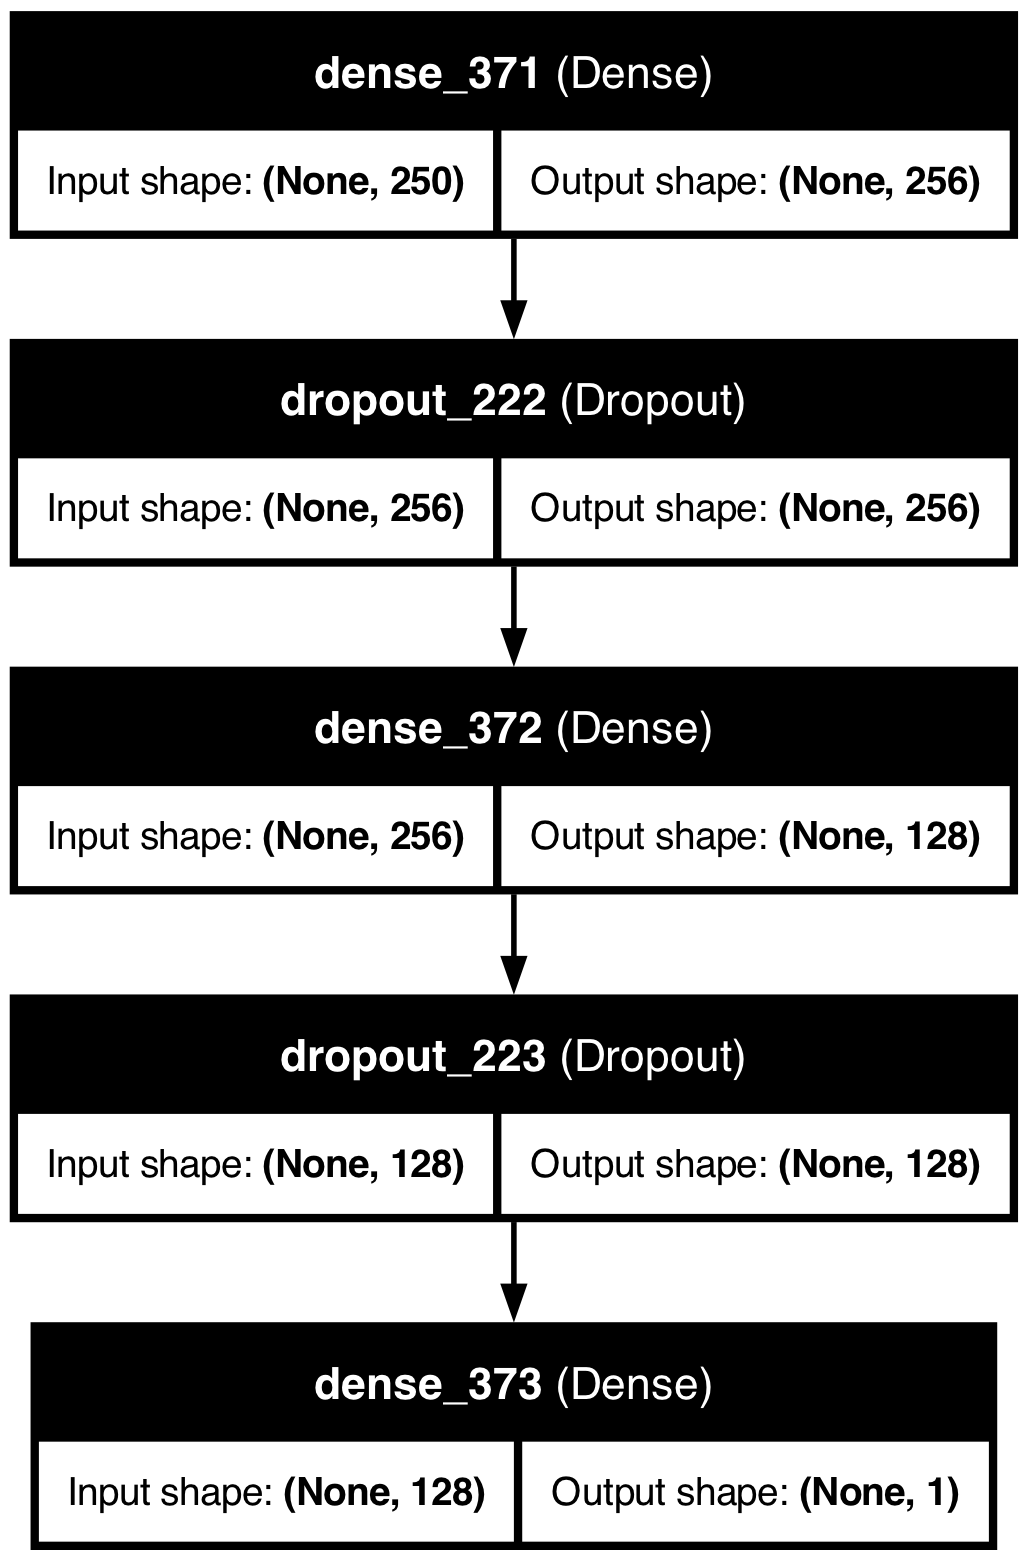

In [45]:
# Generate the plot
plot_model(model_1cWV, show_shapes=True, show_layer_names=True)

Epoch 1/300
245/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4961 - loss: 0.6971
Epoch 1: val_loss improved from inf to 0.68450, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4963 - loss: 0.6971 - val_accuracy: 0.6191 - val_loss: 0.6845 - learning_rate: 0.0010
Epoch 2/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5479 - loss: 0.6872
Epoch 2: val_loss improved from 0.68450 to 0.66934, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5480 - loss: 0.6871 - val_accuracy: 0.5979 - val_loss: 0.6693 - learning_rate: 0.0010
Epoch 3/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5735 - loss: 0.6753
Epoch 3: val_loss improved from 0.66934 to 0.64999, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5737 - loss: 0.6752 - val_accuracy: 0.6510 - val_loss: 0.6500 - learning_rate: 0.0010
Epoch 4/300
240/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

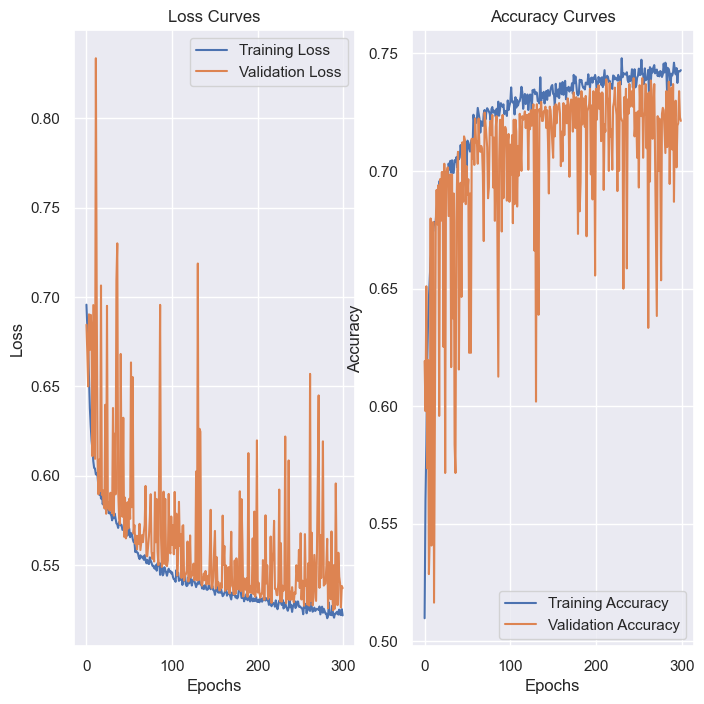

In [46]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cWV_history = model_1cWV.fit(
    cX_train_vec, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_1cWV_history)

In [47]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cWV.predict(cX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cWV_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cWV_accuracy = accuracy_score(cy_test, cy_pred)
m1cWV_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cWV_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cWV_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cWV_accuracy:.2%}", f"{m1cWV_precision:.3f}", f"{m1cWV_recall:.3f}", f"{m1cWV_f1:.3f}", f"{m1cWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           75.20%
        precision            0.759
           recall            0.752
         f1_score            0.750
    time/instance 0.000119 seconds


In [48]:
store_results('Model_2cWV', m2cWV_accuracy, m2cWV_precision, m2cWV_recall, m2cWV_f1, m2cWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds
4  Model_2cWV   75.20%     0.759  0.752    0.750  0.000119 seconds


#### FNN with raw data (Word2Vec)

In [49]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [50]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_vec, ry_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5624 - loss: 0.6810
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6172 - loss: 0.6539
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6343 - loss: 0.6419
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.6329
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6449 - loss: 0.6329
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6449 - loss: 0.6294
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6578 - loss: 0.6172
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6517 - loss: 0.6191
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6532 - loss: 0.6249
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6561 - loss: 0.6133
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.6164
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5722 - loss: 0.6763
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6105 - loss: 0.6562
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6342 - loss: 0.6465
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6397 - loss: 0.6344
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6406 - loss: 0.6291
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6497 - loss: 0.6227
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6433 - loss: 0.6291
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6680 - loss: 0.6135
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6576 - loss: 0.6157
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6631 - loss: 0.6106
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6589 - loss: 0.6139
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5673 - loss: 0.6748
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 0.6526
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6534 - loss: 0.6291
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6261 - loss: 0.6397
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6375 - loss: 0.6361
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6455 - loss: 0.6234
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6560 - loss: 0.6190
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6529 - loss: 0.6160
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 0.6154
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6532 - loss: 0.6175
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6501 - loss: 0.6118
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5779 - loss: 0.8037
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6171 - loss: 0.7155
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6154 - loss: 0.6933
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6164 - loss: 0.6764
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6208 - loss: 0.6752
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6161 - loss: 0.6681
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 0.6619
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6586
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6324 - loss: 0.6619
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6221 - loss: 0.6604
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 0.6541
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5632 - loss: 0.8059
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6110 - loss: 0.7135
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6256 - loss: 0.6899
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6356 - loss: 0.6727
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6240 - loss: 0.6697
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6637
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6225 - loss: 0.6661
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 0.6605
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6318 - loss: 0.6576
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6443 - loss: 0.6537
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 0.6525
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5695 - loss: 0.8082
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6149 - loss: 0.7080
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6237 - loss: 0.6847
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6163 - loss: 0.6841
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6358 - loss: 0.6666
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6293 - loss: 0.6651
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 0.6596
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6316 - loss: 0.6557
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6321 - loss: 0.6603
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6397 - loss: 0.6493
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 0.6498
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5638 - loss: 0.6804
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6085 - loss: 0.6619
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6229 - loss: 0.6506
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6423 - loss: 0.6357
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6414 - loss: 0.6331
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6449 - loss: 0.6245
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6348 - loss: 0.6313
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6508 - loss: 0.6237
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6528 - loss: 0.6159
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6116
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 0.6117
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5597 - loss: 0.6806
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6251 - loss: 0.6571
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6244 - loss: 0.6453
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6335 - loss: 0.6358
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6477 - loss: 0.6261
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6488 - loss: 0.6249
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6443 - loss: 0.6273
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6663 - loss: 0.6117
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6682 - loss: 0.6137
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6679 - loss: 0.6110
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6718 - loss: 0.6064
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5678 - loss: 0.6759
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6193 - loss: 0.6509
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.6368
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6402 - loss: 0.6325
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 0.6271
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6565 - loss: 0.6198
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 0.6138
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.6077
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6706 - loss: 0.6047
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6737 - loss: 0.6031
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6559 - loss: 0.6082
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5541 - loss: 0.8747
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5987 - loss: 0.7331
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6013 - loss: 0.7061
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6266 - loss: 0.6810
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6449 - loss: 0.6668
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6229 - loss: 0.6701
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 0.6650
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6285 - loss: 0.6642
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6497 - loss: 0.6556
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6378 - loss: 0.6604
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6355 - loss: 0.6611
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5660 - loss: 0.8746
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5991 - loss: 0.7451
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6269 - loss: 0.7022
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6154 - loss: 0.6881
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 0.6740
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6170 - loss: 0.6756
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6318 - loss: 0.6711
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6492 - loss: 0.6558
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6294 - loss: 0.6630
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6434 - loss: 0.6560
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6371 - loss: 0.6569
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5516 - loss: 0.8762
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6113 - loss: 0.7373
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6111 - loss: 0.7034
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6126 - loss: 0.6855
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6231 - loss: 0.6749
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 0.6694
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6143 - loss: 0.6746
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6399 - loss: 0.6599
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6510 - loss: 0.6522
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6438 - loss: 0.6503
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6481 - loss: 0.6455
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5688 - loss: 0.6731
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6475
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6342 - loss: 0.6387
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6505 - loss: 0.6257
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 0.6261
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6538 - loss: 0.6202
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6663 - loss: 0.6207
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6423 - loss: 0.6236
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6512 - loss: 0.6207
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6631 - loss: 0.6132
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6552 - loss: 0.6226
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5665 - loss: 0.6739
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6130 - loss: 0.6547
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6380 - loss: 0.6363
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6420 - loss: 0.6347
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6449 - loss: 0.6262
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6625 - loss: 0.6118
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.6197
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6523 - loss: 0.6166
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6634 - loss: 0.6120
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 0.6210
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6643 - loss: 0.6066
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5675 - loss: 0.6748
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6255 - loss: 0.6481
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 0.6355
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6372 - loss: 0.6294
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 0.6221
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6494 - loss: 0.6189
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6570 - loss: 0.6086
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6494 - loss: 0.6205
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 0.6071
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6715 - loss: 0.6025
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6697 - loss: 0.6025
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5749 - loss: 0.8544
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6076 - loss: 0.7219
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6202 - loss: 0.6914
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6193 - loss: 0.6743
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6214 - loss: 0.6728
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6448 - loss: 0.6540
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6388 - loss: 0.6554
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 0.6553
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 0.6632
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 0.6614
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6355 - loss: 0.6506
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5780 - loss: 0.8544
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6151 - loss: 0.7198
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6197 - loss: 0.6869
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 0.6768
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6289 - loss: 0.6674
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6638
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 0.6579
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6267 - loss: 0.6579
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6229 - loss: 0.6605
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6487 - loss: 0.6509
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6320 - loss: 0.6612
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5697 - loss: 0.8609
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6021 - loss: 0.7315
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6288 - loss: 0.6869
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 0.6742
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6177 - loss: 0.6742
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6384 - loss: 0.6585
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6271 - loss: 0.6604
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6231 - loss: 0.6623
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 0.6571
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6201 - loss: 0.6645
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6405 - loss: 0.6509
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5592 - loss: 0.6807
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6259 - loss: 0.6526
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6378 - loss: 0.6385
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6384 - loss: 0.6345
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6537 - loss: 0.6231
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6560 - loss: 0.6196
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6722 - loss: 0.6110
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6443 - loss: 0.6224
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6631 - loss: 0.6144
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6708 - loss: 0.6082
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6546 - loss: 0.6146
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5752 - loss: 0.6732
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6255 - loss: 0.6485
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6342 - loss: 0.6375
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6470 - loss: 0.6325
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6530 - loss: 0.6280
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6674 - loss: 0.6118
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6674 - loss: 0.6155
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6546 - loss: 0.6159
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 0.6131
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 0.6091
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 0.6166
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5732 - loss: 0.6776
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6196 - loss: 0.6559
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6247 - loss: 0.6381
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6362 - loss: 0.6303
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6442 - loss: 0.6217
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6394 - loss: 0.6256
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6469 - loss: 0.6224
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6582 - loss: 0.6091
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6568 - loss: 0.6143
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6768 - loss: 0.5972
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 0.6086
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5580 - loss: 0.9716
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5967 - loss: 0.7521
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6212 - loss: 0.7006
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6187 - loss: 0.6835
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6278 - loss: 0.6715
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6231 - loss: 0.6688
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6182 - loss: 0.6673
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6317 - loss: 0.6618
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6290 - loss: 0.6663
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6412 - loss: 0.6589
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6239 - loss: 0.6617
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5692 - loss: 0.9672
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5944 - loss: 0.7461
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6112 - loss: 0.6993
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6352 - loss: 0.6728
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6241 - loss: 0.6743
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6396 - loss: 0.6645
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6321 - loss: 0.6673
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6364 - loss: 0.6627
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6326 - loss: 0.6631
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 0.6567
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6466 - loss: 0.6548
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5629 - loss: 0.9762
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6071 - loss: 0.7499
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6016 - loss: 0.7064
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6240 - loss: 0.6834
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6373 - loss: 0.6667
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6230 - loss: 0.6753
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6360 - loss: 0.6575
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6281 - loss: 0.6650
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6419 - loss: 0.6498
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - loss: 0.6520
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6325 - loss: 0.6562
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5327 - loss: 0.6896
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5809 - loss: 0.6766
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5862 - loss: 0.6690
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5875 - loss: 0.6677
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 0.6578
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6132 - loss: 0.6564
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6175 - loss: 0.6584
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6131 - loss: 0.6545
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6211 - loss: 0.6512
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6251 - loss: 0.6520
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6258 - loss: 0.6491
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5259 - loss: 0.6907
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5749 - loss: 0.6766
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5915 - loss: 0.6662
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5956 - loss: 0.6636
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6050 - loss: 0.6622
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6052 - loss: 0.6588
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6149 - loss: 0.6552
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6222 - loss: 0.6555
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 0.6525
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.6528
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6314 - loss: 0.6515
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5115 - loss: 0.6930
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5846 - loss: 0.6740
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5907 - loss: 0.6683
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6084 - loss: 0.6625
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6060 - loss: 0.6582
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6105 - loss: 0.6556
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6089 - loss: 0.6541
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6223 - loss: 0.6504
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6148 - loss: 0.6545
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6319 - loss: 0.6490
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6277 - loss: 0.6485
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5268 - loss: 0.8525
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5747 - loss: 0.8172
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5838 - loss: 0.7916
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5998 - loss: 0.7721
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5947 - loss: 0.7583
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6234 - loss: 0.7453
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6192 - loss: 0.7355
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6085 - loss: 0.7327
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6131 - loss: 0.7253
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6205 - loss: 0.7170
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6087 - loss: 0.7220
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5198 - loss: 0.8542
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5924 - loss: 0.8151
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5983 - loss: 0.7916
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5924 - loss: 0.7755
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6025 - loss: 0.7636
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6088 - loss: 0.7466
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6110 - loss: 0.7372
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6285 - loss: 0.7292
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6306 - loss: 0.7201
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6240 - loss: 0.7183
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6130 - loss: 0.7175
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5377 - loss: 0.8523
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5812 - loss: 0.8173
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5781 - loss: 0.7915
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6034 - loss: 0.7712
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5981 - loss: 0.7561
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6208 - loss: 0.7440
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6142 - loss: 0.7383
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6112 - loss: 0.7300
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6054 - loss: 0.7303
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6097 - loss: 0.7182
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6352 - loss: 0.7096
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5233 - loss: 0.6925
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5893 - loss: 0.6778
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5928 - loss: 0.6677
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6121 - loss: 0.6588
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6082 - loss: 0.6594
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6143 - loss: 0.6592
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6181 - loss: 0.6558
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6164 - loss: 0.6562
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6277 - loss: 0.6522
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6225 - loss: 0.6487
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6412 - loss: 0.6410
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5212 - loss: 0.6951
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.6806
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5871 - loss: 0.6716
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6019 - loss: 0.6633
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6004 - loss: 0.6655
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 0.6535
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6150 - loss: 0.6577
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6180 - loss: 0.6591
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6354 - loss: 0.6472
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6438 - loss: 0.6447
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6386 - loss: 0.6458
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5292 - loss: 0.6902
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5677 - loss: 0.6789
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5862 - loss: 0.6696
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6046 - loss: 0.6623
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.6574
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6143 - loss: 0.6546
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 0.6476
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6104 - loss: 0.6577
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6173 - loss: 0.6503
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6244 - loss: 0.6467
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 0.6499
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5240 - loss: 0.9377
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5781 - loss: 0.8895
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5790 - loss: 0.8552
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5928 - loss: 0.8296
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5912 - loss: 0.8108
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.7945
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6129 - loss: 0.7719
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6174 - loss: 0.7609
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6289 - loss: 0.7511
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6304 - loss: 0.7380
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6083 - loss: 0.7415
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5568 - loss: 0.9332
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5831 - loss: 0.8880
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5889 - loss: 0.8550
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5973 - loss: 0.8260
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6022 - loss: 0.8102
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6126 - loss: 0.7926
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6128 - loss: 0.7772
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6145 - loss: 0.7670
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6157 - loss: 0.7567
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6195 - loss: 0.7445
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6225 - loss: 0.7405
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5280 - loss: 0.9355
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5715 - loss: 0.8915
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5779 - loss: 0.8551
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6012 - loss: 0.8214
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6001 - loss: 0.8072
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5971 - loss: 0.7895
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6046 - loss: 0.7755
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6142 - loss: 0.7624
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6190 - loss: 0.7553
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6237 - loss: 0.7426
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6272 - loss: 0.7366
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5442 - loss: 0.6861
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5984 - loss: 0.6663
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5951 - loss: 0.6630
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6093 - loss: 0.6587
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6178 - loss: 0.6545
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.6562
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6264 - loss: 0.6479
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6216 - loss: 0.6560
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6325 - loss: 0.6467
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6278 - loss: 0.6476
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.6429
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5380 - loss: 0.6878
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5951 - loss: 0.6705
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6076 - loss: 0.6603
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6096 - loss: 0.6616
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6050 - loss: 0.6644
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6219 - loss: 0.6575
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6277 - loss: 0.6533
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6271 - loss: 0.6506
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 0.6433
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6404 - loss: 0.6433
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6515 - loss: 0.6387
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5296 - loss: 0.6884
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5819 - loss: 0.6713
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5877 - loss: 0.6675
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6197 - loss: 0.6566
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6048 - loss: 0.6578
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6102 - loss: 0.6574
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6335 - loss: 0.6494
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6222 - loss: 0.6487
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6328 - loss: 0.6475
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6394 - loss: 0.6452
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6430 - loss: 0.6386
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5195 - loss: 0.9320
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6027 - loss: 0.8732
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5917 - loss: 0.8360
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5971 - loss: 0.8089
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6188 - loss: 0.7826
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6089 - loss: 0.7707
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6225 - loss: 0.7518
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6143 - loss: 0.7434
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6269 - loss: 0.7323
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.7289
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6216 - loss: 0.7189
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5510 - loss: 0.9261
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5884 - loss: 0.8723
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5936 - loss: 0.8359
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6011 - loss: 0.8116
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6145 - loss: 0.7834
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6120 - loss: 0.7689
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6180 - loss: 0.7557
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6240 - loss: 0.7440
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6241 - loss: 0.7386
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6305 - loss: 0.7300
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6392 - loss: 0.7195
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5124 - loss: 0.9390
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5904 - loss: 0.8729
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5962 - loss: 0.8312
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6105 - loss: 0.7997
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5984 - loss: 0.7854
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6220 - loss: 0.7624
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6136 - loss: 0.7502
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6216 - loss: 0.7439
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6147 - loss: 0.7354
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6201 - loss: 0.7255
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6227 - loss: 0.7185
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5282 - loss: 0.6898
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6008 - loss: 0.6702
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6086 - loss: 0.6634
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5990 - loss: 0.6606
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6253 - loss: 0.6542
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6218 - loss: 0.6509
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6279 - loss: 0.6489
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6287 - loss: 0.6419
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6428 - loss: 0.6443
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6528 - loss: 0.6389
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6482 - loss: 0.6337
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5285 - loss: 0.6908
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5841 - loss: 0.6756
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6015 - loss: 0.6637
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6107 - loss: 0.6586
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6072 - loss: 0.6614
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6203 - loss: 0.6558
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6180 - loss: 0.6510
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6434 - loss: 0.6437
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6346 - loss: 0.6442
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6420 - loss: 0.6369
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6510 - loss: 0.6324
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5404 - loss: 0.6872
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5864 - loss: 0.6703
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6062 - loss: 0.6550
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6082 - loss: 0.6586
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6057 - loss: 0.6609
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6285 - loss: 0.6486
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6364 - loss: 0.6457
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6494 - loss: 0.6351
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6447 - loss: 0.6366
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6460 - loss: 0.6320
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6502 - loss: 0.6307
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5290 - loss: 1.0940
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5781 - loss: 1.0033
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5915 - loss: 0.9391
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6076 - loss: 0.8883
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6014 - loss: 0.8545
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6031 - loss: 0.8252
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6165 - loss: 0.8003
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6217 - loss: 0.7838
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6267 - loss: 0.7650
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6198 - loss: 0.7589
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6365 - loss: 0.7454
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5447 - loss: 1.0916
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5796 - loss: 1.0054
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5987 - loss: 0.9420
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6033 - loss: 0.8939
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6136 - loss: 0.8577
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6211 - loss: 0.8300
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6191 - loss: 0.8073
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6228 - loss: 0.7911
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6253 - loss: 0.7765
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6358 - loss: 0.7568
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6206 - loss: 0.7513
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5138 - loss: 1.0973
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5775 - loss: 1.0030
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6025 - loss: 0.9342
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5940 - loss: 0.8924
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6126 - loss: 0.8508
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6211 - loss: 0.8210
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6129 - loss: 0.8010
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6277 - loss: 0.7843
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6224 - loss: 0.7677
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6221 - loss: 0.7598
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6315 - loss: 0.7465
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5775 - loss: 0.6723
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6209 - loss: 0.6479
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6518 - loss: 0.6278
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6615 - loss: 0.6149
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6502 - loss: 0.6199
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6650 - loss: 0.6104
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6704 - loss: 0.6083
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6761 - loss: 0.6012
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6705 - loss: 0.5997
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6747 - loss: 0.5985
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6716 - loss: 0.6015
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [51]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.704168 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.693040 (0.006799) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.662991 (0.000741) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.694354 (0.010038) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.650443 (0.012556) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.699818 (0.003202) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.657831 (0.003354) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.704168 (0.008319) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.653074 (0.024139) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.658742 (0.003888) with: {'learning_rate': 

In [52]:
# Extract the best parameters
best_params = grid_result.best_params_

In [53]:
# Create the final model using the best parameters
model_1rWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_497 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,281 (380.00 KB)

 Trainable params: 97,281 (380.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(88539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


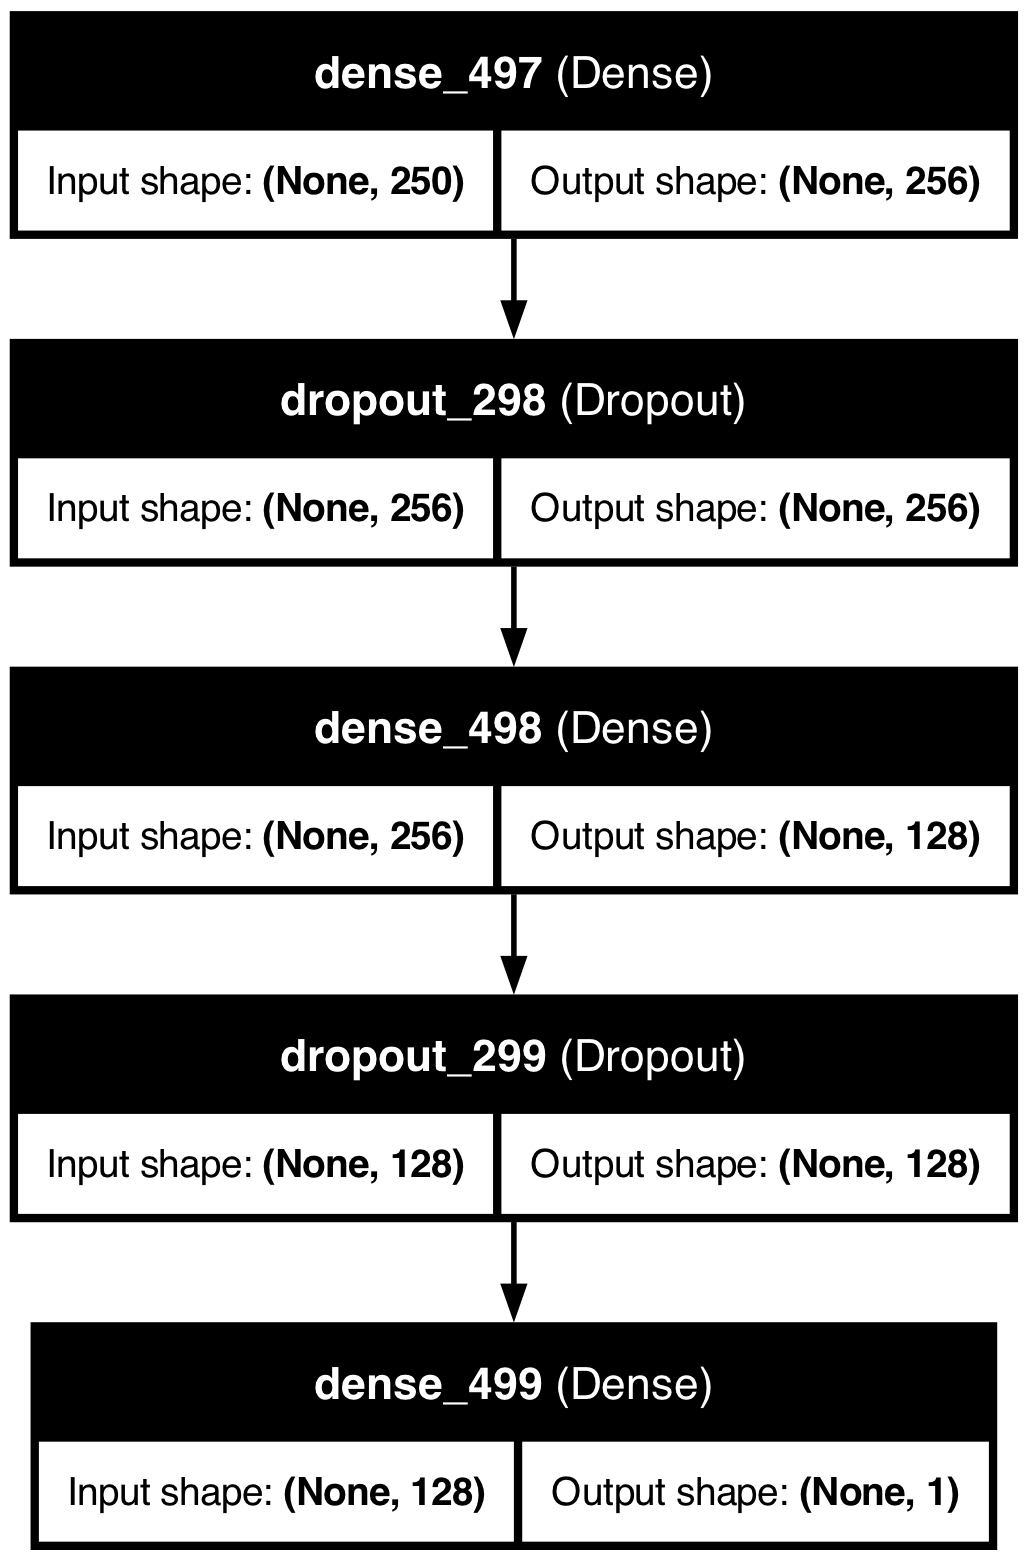

In [54]:
# Generate the plot
plot_model(model_1rWV, show_shapes=True, show_layer_names=True)

Epoch 1/300
238/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5676 - loss: 0.6743
Epoch 1: val_loss improved from inf to 0.72903, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5689 - loss: 0.6738 - val_accuracy: 0.5382 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 2/300
230/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6076 - loss: 0.6587
Epoch 2: val_loss improved from 0.72903 to 0.64307, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6090 - loss: 0.6578 - val_accuracy: 0.6247 - val_loss: 0.6431 - learning_rate: 0.0010
Epoch 3/300
226/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6429 - loss: 0.6323
Epoch 3: val_loss improved from 0.64307 to 0.62869, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6426 - loss: 0.6321 - val_accuracy: 0.6424 - val_loss: 0.6287 - learning_rate: 0.0010
Epoch 4/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

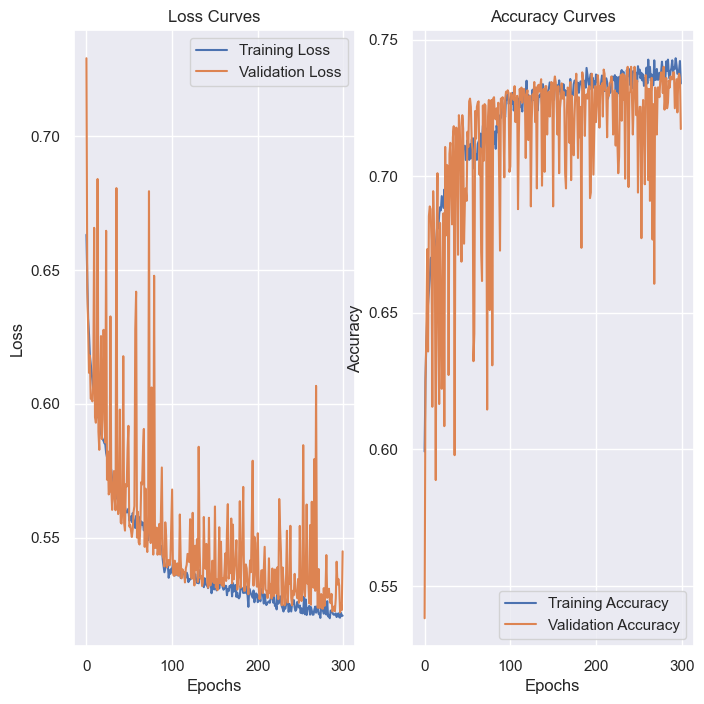

In [55]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2rWV_history = model_1rWV.fit(
    rX_train_vec, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_1rWV_history)

In [56]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rWV.predict(rX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rWV_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rWV_accuracy = accuracy_score(ry_test, ry_pred)
m1rWV_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rWV_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rWV_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rWV_accuracy:.2%}", f"{m1rWV_precision:.3f}", f"{m1rWV_recall:.3f}", f"{m1rWV_f1:.3f}", f"{m1rWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           73.14%
        precision            0.737
           recall            0.731
         f1_score            0.730
    time/instance 0.000113 seconds


In [57]:
store_results('Model_1rWV', m1rWV_accuracy, m1rWV_precision, m1rWV_recall, m1rWV_f1, m1rWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds
4  Model_2cWV   75.20%     0.759  0.752    0.750  0.000119 seconds
5  Model_2rWV   73.14%     0.737  0.731    0.730  0.000113 seconds


### LSTM (single layer)

My second model is a LSTM with a single layer and since TF-IDF is better we will continue with this vectorization

#### LSTM reshaping 

In [58]:
# Convert sparse TF-IDF data to dense arrays and then reshape for LSTM
cX_train_lstm = cX_train_tfidf.toarray().reshape(cX_train_tfidf.shape[0], 1, cX_train_tfidf.shape[1])
cX_test_lstm = cX_test_tfidf.toarray().reshape(cX_test_tfidf.shape[0], 1, cX_test_tfidf.shape[1])

rX_train_lstm = rX_train_tfidf.toarray().reshape(rX_train_tfidf.shape[0], 1, rX_train_tfidf.shape[1])
rX_test_lstm = rX_test_tfidf.toarray().reshape(rX_test_tfidf.shape[0], 1, rX_test_tfidf.shape[1])

In [59]:
print(cX_train_lstm.shape)

(9884, 1, 6695)


#### LSTM (single layer) with cleaned data

In [60]:
# Define the LSTM model
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, regularization=0.001):
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=(cX_train_lstm.shape[1], cX_train_lstm.shape[2]), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, lstm_units=128, learning_rate=0.001, regularization=0.001, epochs=30, batch_size=32, verbose=1)

# Define the grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'regularization': [0, 0.001],  # Focused regularization strengths
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

python(88704) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88705) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88706) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88709) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88710) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2024-05-17 04:28:19.

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 214ms/step - accuracy: 0.7123 - loss: 0.6616
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 219ms/step - accuracy: 0.6509 - loss: 0.8519
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 64s 262ms/step - accuracy: 0.6834 - loss: 0.6590112:25 710ms/step - accuracy: 0.8125 - loss: 0.51 loss: 0.673
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 66s 263ms/step - accuracy: 0.6987 - loss: 0.6624
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 68s 277ms/step - accuracy: 0.7144 - loss: 0.8517
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 69s 280ms/step - accuracy: 0.6725 - loss: 0.8527
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.8343 - loss: 0.4324
 26/206 ━━━━━━━━━━━━━━━━━━━━ 47s 262ms/step - accuracy: 0.8290 - loss: 0.4692Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/step - accuracy: 0.8027 - loss: 0.5592
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - accuracy: 0.8098

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step - accuracy: 0.8914 - loss: 0.3942
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/stepep - accuracy: 0.9502 - loss: 0.125
 95/206 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.9013 - loss: 0.3833Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/stepep - accuracy: 0.9366 - loss: 0.160
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - accuracy: 0.9465 - loss: 0.1346
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/stepep - accuracy: 0.9351 - loss: 0.162
206/206 ━━━━━━━━━━━━━━━━━━━━ 30s 144ms/step - accuracy: 0.8920 - loss: 0.3983
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/stepep - accuracy: 0.9438 - loss: 0.15
206/206 ━━━━━━━━━━━━━━━━━━━━ 83s 404ms/step - accuracy: 0.9326 - loss: 0.1661
103/206 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.9427 - loss: 0.1558Epoch 15/30
104/206 ━━━━━━━━━━━━━━━━━━━━ 29s 287ms/step - accuracy: 0.9426 - loss: 0.1560

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 98/103 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepep - accuracy: 0.9420 - loss: 0.157

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/stepep - accuracy: 0.9188 - loss: 0.165
 24/206 ━━━━━━━━━━━━━━━━━━━━ 36s 200ms/step - accuracy: 0.9213 - loss: 0.1692Epoch 1/30
 25/206 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - accuracy: 0.9215 - loss: 0.1691Epoch 1/30
144/206 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.9390 - loss: 0.1618

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  3/206 ━━━━━━━━━━━━━━━━━━━━ 1:00 299ms/step - accuracy: 0.6493 - loss: 0.6919Epoch 1/30
179/206 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.9370 - loss: 0.1651

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/206 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.9363 - loss: 0.1662

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 93/206 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - accuracy: 0.9285 - loss: 0.1650Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 254ms/step - accuracy: 0.9355 - loss: 0.1674
Epoch 15/30
  2/206 ━━━━━━━━━━━━━━━━━━━━ 35s 175ms/step - accuracy: 0.9297 - loss: 0.2183 Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 57s 277ms/step - accuracy: 0.9294 - loss: 0.1680
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 393ms/step - accuracy: 0.7007 - loss: 0.64637m 250ms/step - accuracy: 0.5449 - loss: 0.6�━━━━━━━━━━━━ 43s 269ms/step - accuracy: 0.5145 - l
 76/206 ━━━━━━━━━━━━━━━━━━━━ 34s 266ms/step - accuracy: 0.5387 - loss: 0.6926Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 256ms/step - accuracy: 0.6208 - loss: 0.691529
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 467ms/step - accuracy: 0.9336 - loss: 0.167527
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 264ms/step - accuracy: 0.6068 - loss: 0.6914
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 154s 606ms/step - accuracy: 0.6811 - loss: 0.9918- loss: 0.68
173/206 ━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


196/206 ━━━━━━━━━━━━━━━━━━━━ 5s 555ms/step - accuracy: 0.9500 - loss: 0.1278Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 553ms/step - accuracy: 0.9495 - loss: 0.1284
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 110s 530ms/step - accuracy: 0.9298 - loss: 0.1714 - loss: 0.296uracy: 0.8916 - loss: 0.295: 0.8917 - loss: 0.294
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 520ms/step - accuracy: 0.9458 - loss: 0.1396y: 0.8708 - loss: 0.44
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.8918 - loss: 0.2928
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 115s 557ms/step - accuracy: 0.8507 - loss: 0.4761
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 116s 561ms/step - accuracy: 0.8630 - loss: 0.4626
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 118s 571ms/step - accuracy: 0.8525 - loss: 0.4840
156/206 ━━━━━━━━━━━━━━━━━━━━ 26s 533ms/step - accuracy: 0.9512 - loss: 0.1225Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 115s 245ms/step - accuracy: 0.6354 - loss: 0.6912
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 124s 602ms/step - accuracy: 0.8602 - loss: 0.4665
Epoch 15/30
145/206 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.8119 - loss: 0.6668Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 122s 589ms/step - accuracy: 0.8656 - loss: 0.4617
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 230ms/step - accuracy: 0.8106 - loss: 0.6655
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 123s 592ms/step - accuracy: 0.8560 - loss: 0.4677
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 233ms/step - accuracy: 0.8143 - loss: 0.641974tep - accuracy: 0.8118 - loss: 0.645��━━━━━ 50s 544ms/step - accuracy: 0.9609 - loss: 0.117��━━━━━
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 144s 561ms/step - accuracy: 0.9448 - loss: 0.1287
206/206 ━━━━━━━━━━━━━━━━━━━━ 116s 562ms/step - accuracy: 0.9352 - loss: 0.1562
Epoch 17/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 552ms/step - accuracy: 0.9574 - loss: 0.1229
206/206 ━━━━━━━━━━━━━━━━━━━━ 101s 232ms/step - accuracy: 0.6442 - loss: 1.3186
147/206 ━━━━━━━━━━━━━━━━━━━━ 34s 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.8270 - loss: 0.5804
Epoch 7/30
159/206 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step - accuracy: 0.9379 - loss: 0.1568

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 53/206 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.8100 - loss: 0.6850Epoch 1/30
 88/206 ━━━━━━━━━━━━━━━━━━━━ 1:00 509ms/step - accuracy: 0.8906 - loss: 0.4211Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 468ms/step - accuracy: 0.9365 - loss: 0.1586
Epoch 18/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.7983 - loss: 0.6819
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.8278 - loss: 0.5488
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 503ms/step - accuracy: 0.8711 - loss: 0.4514
Epoch 17/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 106s 514ms/step - accuracy: 0.8636 - loss: 0.4621
Epoch 17/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step - accuracy: 0.8009 - loss: 0.6649
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.8342 - loss: 0.5201
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 518ms/step - accuracy: 0.8657 - loss: 0.4623
Epoch 17/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 110s 243ms/step - accuracy: 0.6121 - loss: 1.3190
Epoch 2/30
206/206 ━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 241ms/step - accuracy: 0.8353 - loss: 0.494518
Epoch 23/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 120s 581ms/step - accuracy: 0.8795 - loss: 0.4257━━ 1:41 570ms/step - accuracy: 0.8749 - loss: 0.41
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.8359 - loss: 0.4893
Epoch 25/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 83s 246ms/step - accuracy: 0.8339 - loss: 0.4842
Epoch 28/30
197/206 ━━━━━━━━━━━━━━━━━━━━ 5s 565ms/step - accuracy: 0.9506 - loss: 0.1215Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 135s 564ms/step - accuracy: 0.9503 - loss: 0.1221
 63/206 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.8460 - loss: 0.4729Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 125s 605ms/step - accuracy: 0.8843 - loss: 0.4239
 74/206 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.8445 - loss: 0.4750Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.8304 - loss: 0.4998
Epoch 24/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 244ms/step - accuracy: 0.8387 - loss: 0.4

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 125s 604ms/step - accuracy: 0.8852 - loss: 0.4198
Epoch 29/30
 22/206 ━━━━━━━━━━━━━━━━━━━━ 1:49 594ms/step - accuracy: 0.8696 - loss: 0.4403Epoch 1/305 - l
206/206 ━━━━━━━━━━━━━━━━━━━━ 117s 567ms/step - accuracy: 0.9510 - loss: 0.1213
206/206 ━━━━━━━━━━━━━━━━━━━━ 125s 605ms/step - accuracy: 0.8779 - loss: 0.4125
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.8388 - loss: 0.48123
Epoch 28/30
206/206 ━━━━��━━━━━━━━━━━━━━━ 50s 239ms/step - accuracy: 0.8498 - loss: 0.4715
Epoch 30/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/stepp - accuracy: 0.8397 - loss: 0.4757
206/206 ━━━━━━━━━━━━━━━━━━━━ 138s 586ms/step - accuracy: 0.8784 - loss: 0.4265
117/206 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - accuracy: 0.8391 - loss: 0.4782Epoch 29/30
 17/206 ━━━━━━━━━━━━━━━━━━━━ 1:40 531ms/step - accuracy: 0.9039 - loss: 0.3674

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 211ms/step - accuracy: 0.8419 - loss: 0.4751
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 209ms/step - accuracy: 0.8410 - loss: 0.4780
198/206 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step - accuracy: 0.8025 - loss: 0.6768Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 516ms/step - accuracy: 0.8018 - loss: 0.6766
107/206 ━━━━━━━━━━━━━━━━━━━━ 49s 502ms/step - accuracy: 0.8952 - loss: 0.3895Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/stepp - accuracy: 0.8357 - loss: 0.469
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 523ms/step - accuracy: 0.8736 - loss: 0.4329
Epoch 30/30
196/206 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8421 - loss: 0.4680

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 210ms/step - accuracy: 0.8421 - loss: 0.4682
Epoch 30/30
 91/206 ━━━━━━━━━━━━━━━━━━━━ 55s 486ms/step - accuracy: 0.8139 - loss: 0.6556Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 105s 508ms/step - accuracy: 0.8870 - loss: 0.4048
 29/206 ━━━━━━━━━━━━━━━━━━━━ 1:30 509ms/step - accuracy: 0.9269 - loss: 0.3641Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 221ms/step - accuracy: 0.8490 - loss: 0.46389/step - accuracy: 0.8505 - loss: 0.463━━━━━ 29s 497ms/step - accuracy: 0.8112 - loss: 0.654�━━━━━━━━ 10s 527ms/step - accuracy: 0.8809 - loss: 0.409�━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.5929 - loss: 0.69
206/206 ━━━━━━━━━━━━━━━━━━━━ 109s 531ms/step - accuracy: 0.8792 - loss: 0.4131
Epoch 30/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/steptep - accuracy: 0.5655 - loss: 0.69298 
206/206 ━━━━━━━━━━━━━━━━━━━━ 163s 507ms/step - accuracy: 0.6127 - loss: 0.6909
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 105s 508ms/step - accuracy: 0.8096 - loss: 0.6521
Epoch 4/30
 61/206 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 58/206 ━━━━━━━━━━━━━━━━━━━━ 1:17 527ms/step - accuracy: 0.5566 - loss: 2.2624Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 539ms/step - accuracy: 0.8913 - loss: 0.4083
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 540ms/step - accuracy: 0.8889 - loss: 0.4047
206/206 ━━━━━━━━━━━━━━━━━━━━ 166s 502ms/step - accuracy: 0.6357 - loss: 0.6910
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/stepp - accuracy: 0.7986 - loss: 0.6770
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/stepp - accuracy: 0.8849 - loss: 0.403
196/206 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - accuracy: 0.8838 - loss: 0.4051

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 105s 509ms/step - accuracy: 0.8828 - loss: 0.4069
121/206 ━━━━━━━━━━━━━━━━━━━━ 37s 445ms/step - accuracy: 0.8110 - loss: 0.6207Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 456ms/step - accuracy: 0.7986 - loss: 0.6762
Epoch 3/30
  4/206 ━━━━━━━━━━━━━━━━━━━━ 1:21 405ms/step - accuracy: 0.8275 - loss: 0.6569s: 2.38

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 158s 497ms/step - accuracy: 0.6271 - loss: 1.8462
Epoch 2/30
114/206 ━━━━━━━━━━━━━━━━━━━━ 38s 413ms/step - accuracy: 0.8024 - loss: 0.6791Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 126s 427ms/step - accuracy: 0.8120 - loss: 0.6165
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 85s 409ms/step - accuracy: 0.8015 - loss: 0.6770
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/stepracy: 0.8366 - loss: 0.6564: 0.654
 13/206 ━━━━━━━━━━━━━━━━━━━━ 46s 243ms/step - accuracy: 0.5510 - loss: 0.69597

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 69/206 ━━━━━━━━━━━━━━━━━━━━ 32s 236ms/step - accuracy: 0.6225 - loss: 0.6885Epoch 1/30: 0.8343 - loss: 0.6550m 11s 426ms/step - accuracy: 0.8109 - loss: 0.65
206/206 ━━━━━━━━━━━━━━━━━━━━ 156s 473ms/step - accuracy: 0.6161 - loss: 1.84692/step - accuracy: 0.8307 - loss: 0.655
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 91s 441ms/step - accuracy: 0.8112 - loss: 0.6516
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 504ms/step - accuracy: 0.7821 - loss: 0.7792
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 235ms/step - accuracy: 0.6840 - loss: 0.6658
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 502ms/step - accuracy: 0.8194 - loss: 0.5723
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 109s 529ms/step - accuracy: 0.8216 - loss: 0.6512
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 220ms/step - accuracy: 0.8176 - loss: 0.4633
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 174s 575ms/step - accuracy: 0.6330 - loss: 1.8468
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 106s 229ms/step - accuracy: 0.6824 - loss: 0.6669
Epoch

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 522ms/step - accuracy: 0.8759 - loss: 0.3384
Epoch 17/30
172/206 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - accuracy: 0.8171 - loss: 0.5245Epoch 1/30
  1/206 ━━━━━━━━━━━━━━━━━━━━ 3:50 1s/step - accuracy: 0.9062 - loss: 0.3323oss: 0.5155

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 106s 513ms/step - accuracy: 0.8794 - loss: 0.3369
Epoch 18/30
 67/206 ━━━━━━━━━━━━━━━━━━━━ 1:12 521ms/step - accuracy: 0.8300 - loss: 0.5076Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 552ms/step - accuracy: 0.8171 - loss: 0.5244
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━���━ 113s 545ms/step - accuracy: 0.8229 - loss: 0.5177
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 501ms/step - accuracy: 0.8723 - loss: 0.3220
116/206 ━━━━━━━━━━━━━━━━━━━━ 49s 554ms/step - accuracy: 0.8195 - loss: 0.5077Epoch 20/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 547ms/step - accuracy: 0.8258 - loss: 0.5130
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 109s 253ms/step - accuracy: 0.6817 - loss: 0.6638
204/206 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.8805 - loss: 0.3356Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 535ms/step - accuracy: 0.8805 - loss: 0.3355
Epoch 18/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 112s 540ms/step - accuracy: 0.8839 - loss: 0.3191
Epoch 19/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 77/206 ━━━━━━━━━━━━━━━━━━━━ 1:16 597ms/step - accuracy: 0.8520 - loss: 0.4843Epoch 1/30 0.8495 - loss: 0.460m 9s 226ms/step - accuracy: 0.9404 - loss: 0.15
206/206 ━━━━━━━━━━━━━━━━━━━━ 115s 555ms/step - accuracy: 0.8994 - loss: 0.2642
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 227ms/step - accuracy: 0.9402 - loss: 0.1517
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 76s 246ms/step - accuracy: 0.8814 - loss: 0.4252
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 120s 577ms/step - accuracy: 0.8482 - loss: 0.4676: 0.8498 - loss: 0.480━ 1:33 556ms/step - accuracy: 0.9227 - loss: 0.23
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 230ms/step - accuracy: 0.9371 - loss: 0.1456
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 241ms/step - accuracy: 0.8848 - loss: 0.4274
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 112s 542ms/step - accuracy: 0.9073 - loss: 0.2491
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 122s 591ms/step - accuracy: 0.8470 - loss: 0.4774
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 124s 600ms/step - a

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/206 ━�━━━━━━━━━━━━━━━━━━ 32s 223ms/step - accuracy: 0.6009 - loss: 1.0929

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/stepp - accuracy: 0.8984 - loss: 0.4090506 ━━━━━━━━━━━━━━━━━━━━ 29s 218ms/step - accuracy: 0.6122 - loss: 1.056
206/206 ━━━━━━━━━━━━━━━━━━━━ 116s 557ms/step - accuracy: 0.8583 - loss: 0.4613ss: 0.249
Epoch 27/30
 16/206 ━━━━━━━━━━━━━━━━━━━━ 1:41 534ms/step - accuracy: 0.8472 - loss: 0.4445Epoch 1/3073 - loss: 0.410
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 214ms/step - accuracy: 0.8929 - loss: 0.4174
Epoch 29/30
158/206 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.6605 - loss: 0.8976Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 105s 510ms/step - accuracy: 0.9063 - loss: 0.2490
206/206 ━━━━━━━━━━━━━━━━━━━━ 170s 224ms/step - accuracy: 0.6756 - loss: 0.8546
 74/206 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step - accuracy: 0.9004 - loss: 0.3929Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 521ms/step - accuracy: 0.8475 - loss: 0.4728
Epoch 28/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/stepp - accuracy: 0.8402 - loss: 0.459
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/206 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.8914 - loss: 0.4076Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 176ms/step - accuracy: 0.8848 - loss: 0.4209
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 463ms/step - accuracy: 0.8537 - loss: 0.4500
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.8078 - loss: 0.5439 ━━━━━━━━━━━━━━━━━━━━ 55s 437ms/step - accuracy: 0.8613 - loss: 0.43��━━━━━━━━━━ 1:34 472ms/step - accuracy: 0.8664 - loss: 0.418� 2s 181ms/step - accuracy: 0.8080 - loss: 0.544loss: 0.544
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/stepp - accuracy: 0.8153 - loss: 0.53842
206/206 ━━━━━━━━━━━━━━━━━━━━ 119s 202ms/step - accuracy: 0.7118 - loss: 0.8545
 50/206 ━━━━━━━━━━━━━━━━━━━━ 1:16 491ms/step - accuracy: 0.5943 - loss: 0.6887Epoch 2/30
 69/206 ━━━━━━━━━━━m━━━━━━━━ 17s 220ms/step - accuracy: 0.8183 - loss: 0.5228

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 98s 477ms/step - accuracy: 0.8514 - loss: 0.4640�━━━━ 1:13 502ms/step - accuracy: 0.6045 - loss: 0.687━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.8047 - loss: 0.59━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.8188 - loss: 0.522
Epoch 29/30
172/206 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.8552 - loss: 0.4452Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 224ms/step - accuracy: 0.8185 - loss: 0.5226
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 497ms/step - accuracy: 0.8532 - loss: 0.44860.7967 - loss: 0.57
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.7923 - loss: 0.5735
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step - accuracy: 0.8310 - loss: 0.5009oss: 0.456
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 535ms/step - accuracy: 0.8494 - loss: 0.456606 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.8099 - loss: 0.530��━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.6476 - loss: 0.669 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/206 ━━━━━━━━━━━━━━━━━━━━ 6s 548ms/step - accuracy: 0.7053 - loss: 0.6561Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 227ms/step - accuracy: 0.8503 - loss: 0.4840
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 228s 544ms/step - accuracy: 0.7083 - loss: 0.6527
 97/206 ━━━━━━━━━━━━━━━━━━━━ 54s 503ms/step - accuracy: 0.8611 - loss: 0.3608Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 233ms/step - accuracy: 0.8454 - loss: 0.48744: 0.8611 - loss: 0.356m 249ms/step - a
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 117s 564ms/step - accuracy: 0.8488 - loss: 0.4642
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 506ms/step - accuracy: 0.8594 - loss: 0.3576
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 79s 232ms/step - accuracy: 0.8569 - loss: 0.4847
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 110s 530ms/step - accuracy: 0.8562 - loss: 0.4500
206/206 ━━━━━━━━━━━━━━━━━━━━ 98s 474ms/step - accuracy: 0.8570 - loss: 0.3558
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - accuracy: 0.8596 - loss: 0.4708
Epoch 11/30
206/206 ━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 212ms/step - accuracy: 0.8555 - loss: 0.4729
Epoch 9/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/stepp - accuracy: 0.8644 - loss: 0.465
 66/206 ━━━━━━━━━━━━━━━━━━━━ 1:10 500ms/step - accuracy: 0.8592 - loss: 0.3609Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.8598 - loss: 0.4713
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 91s 444ms/step - accuracy: 0.8774 - loss: 0.3091
Epoch 5/30
109/206 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.8738 - loss: 0.4488

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/206 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.8692 - loss: 0.4557Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 164s 472ms/step - accuracy: 0.7006 - loss: 0.9945
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - accuracy: 0.8639 - loss: 0.4620
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 91s 439ms/step - accuracy: 0.8759 - loss: 0.3189
155/206 ━━━━━━━━━━━━━━━━━━━━ 22s 449ms/step - accuracy: 0.8610 - loss: 0.3541Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 92s 446ms/step - accuracy: 0.8613 - loss: 0.35226cy: 0.8614 - loss: 0.352
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 212ms/step - accuracy: 0.8611 - loss: 0.4616
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 88s 239ms/step - accuracy: 0.8598 - loss: 0.4625
Epoch 13/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 101s 491ms/step - accuracy: 0.8912 - loss: 0.2776
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 247ms/step - accuracy: 0.8641 - loss: 0.4630
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 550ms/step - accuracy: 0.7910 - loss: 0.578660m ━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 131s 633ms/step - accuracy: 0.8523 - loss: 0.4974
Epoch 11/30
122/206 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.9095 - loss: 0.3757Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 246ms/step - accuracy: 0.8982 - loss: 0.394300━━━━━━━━━━━ 1:03 608ms/step - accuracy: 0.8550 - loss: 0.501
206/206 ━━━━━━━━━━━━━━━━━━━━ 118s 570ms/step - accuracy: 0.9264 - loss: 0.1850
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 126s 611ms/step - accuracy: 0.8551 - loss: 0.4915
 83/206 ━━━━━━━━━━━━━━━━━━━━ 1:06 544ms/step - accuracy: 0.9338 - loss: 0.1818Epoch 10/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/stepep - accuracy: 0.9399 - loss: 0.177
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 524ms/step - accuracy: 0.9166 - loss: 0.1924
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 118s 569ms/step - accuracy: 0.8492 - loss: 0.5064
Epoch 10/30
 73/206 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.5605 - loss: 0.6925

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/206 ━━━━━━━━━━━━━━━━━━━━ 23s 542ms/step - accuracy: 0.8560 - loss: 0.4990Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 500ms/step - accuracy: 0.9306 - loss: 0.1819
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 211ms/step - accuracy: 0.6155 - loss: 0.6915
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 548ms/step - accuracy: 0.8513 - loss: 0.50458
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 100s 483ms/step - accuracy: 0.9303 - loss: 0.18668
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 106s 510ms/step - accuracy: 0.8533 - loss: 0.5051
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.7735 - loss: 0.6833
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 110s 529ms/step - accuracy: 0.8529 - loss: 0.5049
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 505ms/step - accuracy: 0.9264 - loss: 0.1912
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.8019 - loss: 0.6702
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 247ms/step - accuracy: 0.5901 - loss: 0.6918
Epoch 2/30
206/20

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 41/206 ━━━━━━━━━━━━━━━━━━━━ 1:40 609ms/step - accuracy: 0.8894 - loss: 0.4322Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 233ms/step - accuracy: 0.8816 - loss: 0.309453
206/206 ━━━━━━━━━━━━━━━━━━━━ 125s 603ms/step - accuracy: 0.8844 - loss: 0.4538
Epoch 23/30
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 548ms/step - accuracy: 0.9365 - loss: 0.1569
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 537ms/step - accuracy: 0.9388 - loss: 0.1531
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 109s 527ms/step - accuracy: 0.9438 - loss: 0.1436
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 225ms/step - accuracy: 0.8883 - loss: 0.2978
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/stepp - accuracy: 0.9521 - loss: 0.146
206/206 ━━━━━━━━━━━━━━━━━━━━ 123s 593ms/step - accuracy: 0.8724 - loss: 0.4665
Epoch 25/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 122s 589ms/step - accuracy: 0.8795 - loss: 0.4716
Epoch 24/30
156/206 ━━━━━━━━━━━━━━━━━━━━ 29s 590ms/step - accuracy: 0.8806 - loss: 0.4566

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 119s 232ms/step - accuracy: 0.6206 - loss: 0.6915
Epoch 2/30
124/206 ━━━━━━━━━━━━━━━━━━━━ 44s 543ms/step - accuracy: 0.9482 - loss: 0.1423Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 121s 587ms/step - accuracy: 0.8770 - loss: 0.4608
Epoch 24/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 547ms/step - accuracy: 0.9471 - loss: 0.1472
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 228ms/step - accuracy: 0.7803 - loss: 0.6839
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 544ms/step - accuracy: 0.9457 - loss: 0.1428
110/206 ━━━━━━━━━━━━━━━━━━━━ 56s 592ms/step - accuracy: 0.8978 - loss: 0.4341Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 112s 544ms/step - accuracy: 0.9414 - loss: 0.1445
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 226ms/step - accuracy: 0.8091 - loss: 0.6716
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 119s 578ms/step - accuracy: 0.8716 - loss: 0.4684
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 120s 579ms/step - accuracy: 0.8839 - loss: 0.4522
Epoch 25/30
206/206 ━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 199ms/step - accuracy: 0.8162 - loss: 0.63093: 0.688.68
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 143s 547ms/step - accuracy: 0.9375 - loss: 0.15440 0.68
 33/206 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.8338 - loss: 0.6049Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/steptep - accuracy: 0.9285 - loss: 0.157
206/206 ━━━━━━━━━━━━━━━━━━━━ 119s 574ms/step - accuracy: 0.8689 - loss: 0.4643y: 0.7893 - loss: 0.68
123/206 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.8309 - loss: 0.6017Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 117s 562ms/step - accuracy: 0.8821 - loss: 0.4634
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 217ms/step - accuracy: 0.7895 - loss: 0.6849
Epoch 4/30
 10/206 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - accuracy: 0.8333 - loss: 0.6714ss: 0.461

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.8283 - loss: 0.5998
 31/206 ━━━━━━━━━━━━━━━━━━━━ 1:29 510ms/step - accuracy: 0.8807 - loss: 0.4516Epoch 7/30
 57/206 ━━━━━━━━━━━━━━━━━━━━ 30s 205ms/step - accuracy: 0.8079 - loss: 0.6728Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.8024 - loss: 0.670374p - accuracy: 0.8057 - loss: 
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 123s 515ms/step - accuracy: 0.8698 - loss: 0.4635
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 226ms/step - accuracy: 0.5964 - loss: 1.31847450ss: 0.657oss: 0.65ss: 0.45
 92/206 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.8200 - loss: 0.5759Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 129s 488ms/step - accuracy: 0.9406 - loss: 0.1440131/206 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.8041 - loss: 0.656
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 233ms/step - accuracy: 0.8016 - loss: 0.6558
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 84s 216ms/step - accuracy: 0.8229 - loss: 0.5715
Epoch 8/30
103/1

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 57/206 ━━━━━━━━━━━━━━━━━━━━ 1:04 436ms/step - accuracy: 0.8676 - loss: 0.4523Epoch 1/30loss: 1.57
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.8028 - loss: 0.6408
 77/206 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.5115 - loss: 1.5030Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 175ms/step - accuracy: 0.8368 - loss: 0.53972
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 495ms/step - accuracy: 0.8876 - loss: 0.4360
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 140s 182ms/step - accuracy: 0.5827 - loss: 1.3190
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - accuracy: 0.8016 - loss: 0.6265
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.8376 - loss: 0.5102
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 87s 231ms/step - accuracy: 0.7859 - loss: 0.6860
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 226ms/step - accuracy: 0.7765 - loss: 0.7474
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 496ms/step - accuracy: 0.8678 - loss: 0.4618
 13/206 ━━━━━━━━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - accuracy: 0.8168 - loss: 0.54660.8594 - loss: 0.394acy: 0.7799 - loss: 0.598178 - loss: 0.54
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.8053 - loss: 0.6087
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8588 - loss: 0.3942Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 224ms/step - accuracy: 0.8588 - loss: 0.3942
 49/206 ━━━━━━━━━━━━━━━━━━━━ 1:23 533ms/step - accuracy: 0.7942 - loss: 0.6368Epoch 17/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 242ms/step - accuracy: 0.7991 - loss: 0.5865 0.388
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 246ms/step - accuracy: 0.8147 - loss: 0.54091━━━━━━━━ 43s 540ms/step - accuracy: 0.8078 - lo
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 234ms/step - accuracy: 0.8594 - loss: 0.3869
Epoch 18/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 247ms/step - accuracy: 0.8141 - loss: 0.5947
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 118s 570ms/step - accuracy: 0.8818 - loss: 0.4416 - loss: 0.63

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.8213 - loss: 0.5756
Epoch 11/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/stepp - accuracy: 0.8097 - loss: 0.54298�━━━━━━━━━━━━ 28s 195ms/step - accuracy: 0.8028 - loss: 0.547��━━━━ 36s 189ms/step - accuracy: 0.7768 - loss: 0.585�━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.7834 - loss: 0.583
 91/206 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.8581 - loss: 0.3737Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.8143 - loss: 0.56092racy: 0.8158 - loss: 0.559 196ms/step - accuracy: 0.8600 - loss: 0.37
142/206 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.8083 - loss: 0.5723Epoch 13/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 74s 206ms/step - accuracy: 0.8119 - loss: 0.5397
Epoch 17/30
177/206 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.8092 - loss: 0.5713

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.8617 - loss: 0.3712
 34/206 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - accuracy: 0.8193 - loss: 0.5457Epoch 20/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step - accuracy: 0.8098 - loss: 0.5707
 55/206 ━━━━━━━━━━━━━━━━━━━━ 33s 221ms/step - accuracy: 0.8208 - loss: 0.5362Epoch 12/30
 75/206 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.8196 - loss: 0.5350Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.8129 - loss: 0.5543
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 211ms/step - accuracy: 0.8167 - loss: 0.5333
Epoch 18/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.8688 - loss: 0.3549
Epoch 21/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 98s 475ms/step - accuracy: 0.8116 - loss: 0.5923
 37/206 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.8736 - loss: 0.3278Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 209ms/step - accuracy: 0.8114 - loss: 0.5622
 57/206 ━━━━━━━━━━━━━━━━━━━━ 31s 211ms/step - accuracy: 0.8237 -

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 93/206 ━━━━━━━━━━━━━━━━━━━━ 23s 211ms/step - accuracy: 0.8361 - loss: 0.4910Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 121s 589ms/step - accuracy: 0.7979 - loss: 0.6602
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 217ms/step - accuracy: 0.8374 - loss: 0.4867
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step - accuracy: 0.8331 - loss: 0.4948
Epoch 24/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 518ms/step - accuracy: 0.8225 - loss: 0.5892982 - loss: 0.49acy: 0.8119 - loss: 0.525ms/step - accuracy: 0.8360 - loss: 0.494
 57/206 ━━━━━━━━━━━━━━━━━━━━ 1:25 576ms/step - accuracy: 0.8065 - loss: 0.6398Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - accuracy: 0.8329 - loss: 0.4961
Epoch 25/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - accuracy: 0.8317 - loss: 0.4865
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 547ms/step - accuracy: 0.8355 - loss: 0.4459
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 55s 266ms/step - accuracy: 0.8282 - loss: 0.5024
 49/206 ━━━━━━━━━━━━━━━━━━━━ 1:44 665ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 228ms/step - accuracy: 0.8412 - loss: 0.4849
Epoch 27/30
 88/206 ━━━━━━━━━━━━━━━━━━━━ 1:08 583ms/step - accuracy: 0.7932 - loss: 0.6215Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 81s 248ms/step - accuracy: 0.8403 - loss: 0.490986 231ms/step - accuracy: 0.8058 - loss: 0.511
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 544ms/step - accuracy: 0.8283 - loss: 0.5163
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 142s 545ms/step - accuracy: 0.8458 - loss: 0.4169
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 239ms/step - accuracy: 0.8270 - loss: 0.4909
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 244ms/step - accuracy: 0.8401 - loss: 0.4885
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 122s 592ms/step - accuracy: 0.7969 - loss: 0.6196
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 115s 558ms/step - accuracy: 0.8240 - loss: 0.5151loss: 0.472
 29/206 ━━━━━━━━━━━━━━━━━━━━ 1:55 652ms/step - accuracy: 0.5168 - loss: 2.3670Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 255ms/step - accuracy:

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.6500 - loss: 1.6631
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.7859 - loss: 0.6950
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.7962 - loss: 0.6490
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.7926 - loss: 0.6198
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8014 - loss: 0.5884
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.8015 - loss: 0.5694
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.8060 - loss: 0.5521
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.8058 - loss: 0.5414
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8067 - loss: 0.5346
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.8129 - loss: 0.5214
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.8119 - loss: 0.5251
Epoch 12/30
309/309 ━━━━━━━━━━

In [61]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795830 using {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 256, 'regularization': 0.001}
0.732799 (0.008429) with: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'lstm_units': 128, 'regularization': 0}
0.768211 (0.008662) with: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'lstm_units': 128, 'regularization': 0.001}
0.734924 (0.009995) with: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'lstm_units': 256, 'regularization': 0}
0.772358 (0.008204) with: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'lstm_units': 256, 'regularization': 0.001}
0.788040 (0.006725) with: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 128, 'regularization': 0}
0.793503 (0.009201) with: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 128, 'regularization': 0.001}
0.783487 (0.008442) with: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 256, 'regularization': 0}
0.795830 (0.009117) with: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 25

In [62]:
# Extract the best parameters
best_params = grid_result.best_params_

In [63]:
# Create the final model using the best parameters
model_2cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_2cIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │     7,118,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_301 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,105 (27.16 MB)

 Trainable params: 7,119,105 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

None


python(89942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(89943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


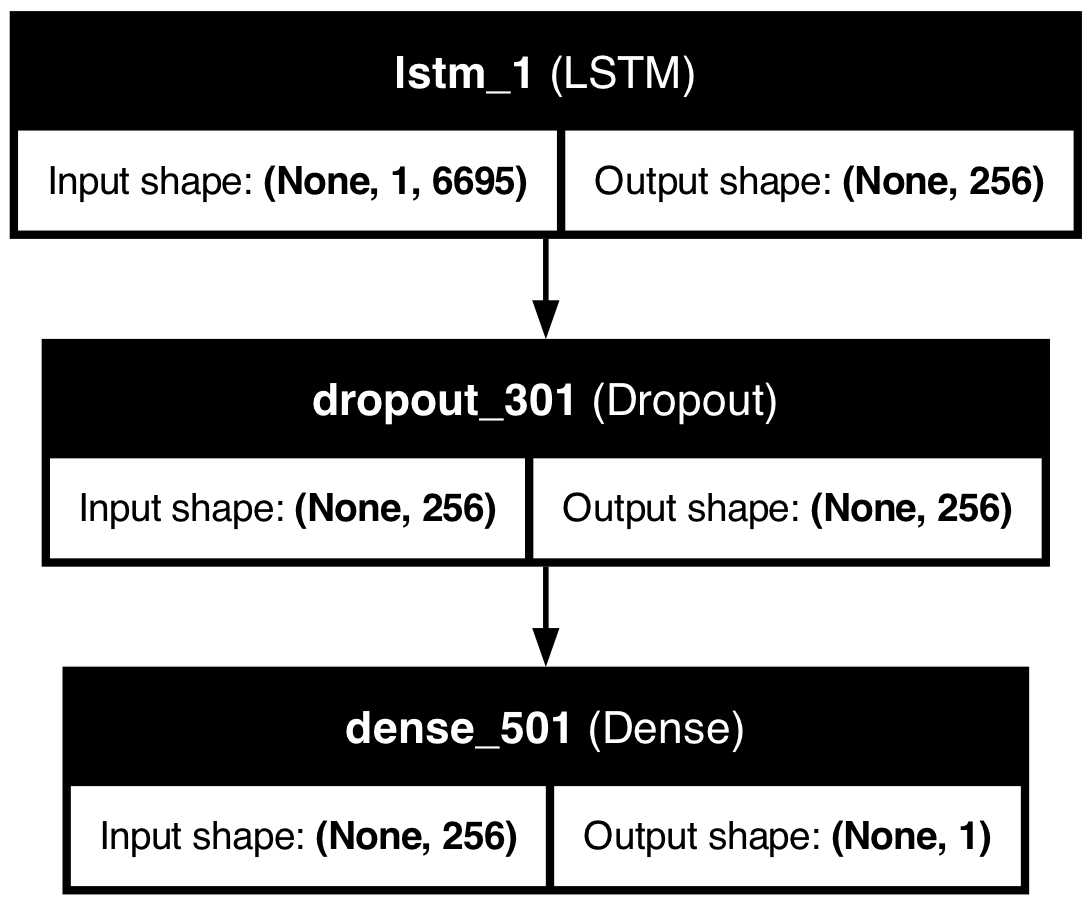

In [64]:
# Generate the plot
plot_model(model_2cIT, show_shapes=True, show_layer_names=True)

In [65]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2cIT_history = model_2cIT.fit(
    cX_train_lstm, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6442 - loss: 1.7656
Epoch 1: val_loss improved from inf to 0.77847, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.6445 - loss: 1.7638 - val_accuracy: 0.7693 - val_loss: 0.7785 - learning_rate: 1.0000e-04
Epoch 2/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7959 - loss: 0.7308
Epoch 2: val_loss improved from 0.77847 to 0.67308, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.7959 - loss: 0.7307 - val_accuracy: 0.7668 - val_loss: 0.6731 - learning_rate: 1.0000e-04
Epoch 3/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7919 - loss: 0.6641
Epoch 3: val_loss improved from 0.67308 to 0.64854, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7919 - loss: 0.6641 - val_accuracy: 0.7673 - val_loss: 0.6485 - learning_rate: 1.0000e-04
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 

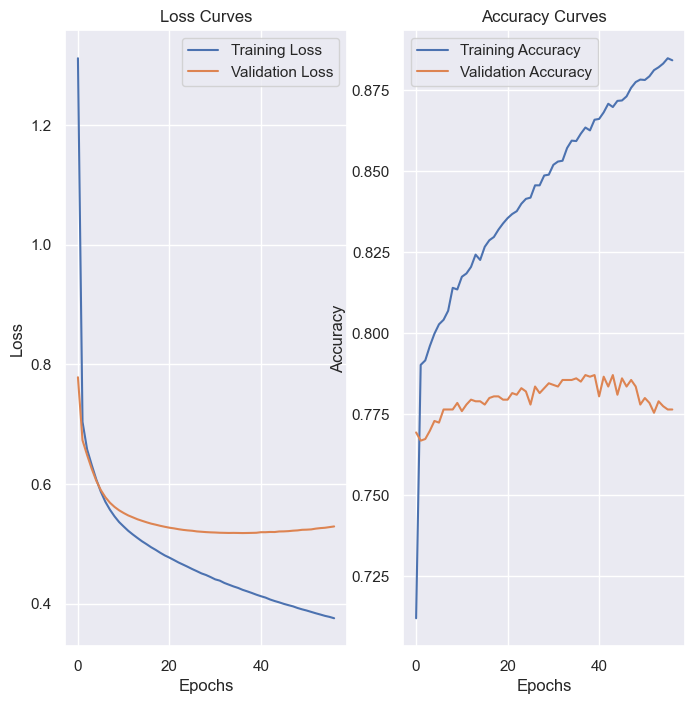

In [66]:
# Use the function with your model's history
plot_loss_curves(model_2cIT_history) 

In [67]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_2cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2cIT_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m2cIT_accuracy = accuracy_score(cy_test, cy_pred)
m2cIT_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m2cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2cIT_accuracy:.2%}", f"{m2cIT_precision:.3f}", f"{m2cIT_recall:.3f}", f"{m2cIT_f1:.3f}", f"{m2cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Model Performance          Results
         accuracy           77.99%
        precision            0.782
           recall            0.780
         f1_score            0.780
    time/instance 0.000947 seconds


In [68]:
store_results('Model_2cIT', m2cIT_accuracy, m2cIT_precision, m2cIT_recall, m2cIT_f1, m2cIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds
4  Model_2cWV   75.20%     0.759  0.752    0.750  0.000119 seconds
5  Model_2rWV   73.14%     0.737  0.731    0.730  0.000113 seconds
6  Model_2cIT   77.99%     0.782  0.780    0.780  0.000947 seconds


#### LSTM (single layer) with raw data

In [69]:
# Define the LSTM model
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, regularization=0.001):
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=(rX_train_lstm.shape[1], rX_train_lstm.shape[2]), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, lstm_units=128, learning_rate=0.001, regularization=0.001, epochs=30, batch_size=32, verbose=1)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

python(90636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(90643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2024-05-17 09:44:17.471040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instr

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 179ms/step - accuracy: 0.7037 - loss: 0.65879: 0.6802 - loss: 0.677m 252ms/step - accuracy: 0.5968 - loss: 1.109�━━━━━━ 31s 23
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 217ms/step - accuracy: 0.6923 - loss: 0.8547
167/206 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.6538 - loss: 0.8906 Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 241ms/step - accuracy: 0.6897 - loss: 0.660981━━━━━━━━━━━━━━━━━━━ 46s 240ms/step - accuracy: 0.8128 - loss: 0.57��━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.6611 - loss: 0.87��━━━━━━━━━ 34s 242ms/step - accuracy: 0.8299 - loss: 0.44
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 242ms/step - accuracy: 0.7120 - loss: 0.6613━━━━━━ 2s 255ms/step - accuracy: 0.6639 - loss: 0.86
199/206 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.6645 - loss: 0.8619Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 60s 252ms/step - accuracy: 0.6682 - loss: 0.8554802━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 97/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1772ms/step - accuracy: 0.9442 - loss: 0.141

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/stepp - accuracy: 0.9452 - loss: 0.138
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 205ms/step - accuracy: 0.8814 - loss: 0.3991
Epoch 29/30
148/206 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9342 - loss: 0.1730

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8963 - loss: 0.36690��━━━━━━━━━━━━━━ 31s 162ms/step - accuracy: 0.8985 - loss: 0.375
 81/206 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.9545 - loss: 0.1174Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.8916 - loss: 0.37527
185/206 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.9337 - loss: 0.1743Epoch 30/30
102/206 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.9546 - loss: 0.1176Epoch 1/30
 21/206 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - accuracy: 0.9036 - loss: 0.3548Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 101s 490ms/step - accuracy: 0.9333 - loss: 0.1750/206 ━━━━━━━━━━━━━━━━━━━━ 24s 248ms/step - accuracy: 0.8946 - loss: 0.380
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 211ms/step - accuracy: 0.9547 - loss: 0.11825oss: 0.3
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 220ms/step - accuracy: 0.8852 - loss: 0.3987
142/206 ━━━���━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.8955 - loss: 0.3707Epoch 30/30
206/20

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/stepp - accuracy: 0.9351 - loss: 0.165
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6560 - loss: 0.652
 95/206 ━━━━━━━━━━━━━━━━━━━━ 56s 513ms/step - accuracy: 0.6579 - loss: 1.2428Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 105s 443ms/step - accuracy: 0.6634 - loss: 0.6455
118/206 ━━━━━━━━━━━━━━━━━━━━ 43s 496ms/step - accuracy: 0.6296 - loss: 1.1661Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 91s 438ms/step - accuracy: 0.9348 - loss: 0.1663
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 91s 443ms/step - accuracy: 0.9414 - loss: 0.1488
Epoch 15/30
178/206 ━━━━━━━━━━━━━━━━━━━━ 13s 484ms/step - accuracy: 0.6883 - loss: 1.0374

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 137s 474ms/step - accuracy: 0.6633 - loss: 0.9964
 20/206 ━━━━━━━━━━━━━━━━━━━━ 1:17 416ms/step - accuracy: 0.9417 - loss: 0.1571Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 142s 478ms/step - accuracy: 0.6953 - loss: 0.9960.394��━━━━━━━━━━━━━━━━━━ 41s 408ms/step - accuracy: 0.8463 - loss: 0.393
Epoch 2/30
123/206 ━━━━━━━━━━━━━━━━━━━━ 33s 403ms/step - accuracy: 0.8455 - loss: 0.3926Epoch 1/30
120/206 ━━━━━━━━━━━━━━━━━━━━ 35s 412ms/step - accuracy: 0.9333 - loss: 0.1576Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 86s 414ms/step - accuracy: 0.8413 - loss: 0.3919
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 88s 426ms/step - accuracy: 0.9328 - loss: 0.1616
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 234ms/step - accuracy: 0.6589 - loss: 0.690762 - accuracy: 0.9404 - loss: 0.1539m8s 232ms/step - accuracy: 0.6511 - loss: 0.691:32 607ms/step - accuracy: 0.9330 - loss: 0.14s 471ms/step - accuracy: 0.9400 - loss: 0.15
201/206 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.6259 - 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.8805 - loss: 0.290658801 - loss: 0.291s/step - accuracy: 0.8803 - loss: 0.29 0s 208ms/step - accuracy: 0.8805 - loss: 0.29
131/206 ━━━━━━━━━━━━━━━━━━━━ 35s 477ms/step - accuracy: 0.9462 - loss: 0.1445Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 126s 520ms/step - accuracy: 0.8582 - loss: 0.4670
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 467ms/step - accuracy: 0.9574 - loss: 0.11300 0.9574 - loss: 0.113
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 129s 467ms/step - accuracy: 0.9430 - loss: 0.1496
172/206 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.8510 - loss: 0.4732Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 448ms/step - accuracy: 0.9541 - loss: 0.1195
 31/206 ━━━━━━━━━━━━━━━━━━━━ 1:05 376ms/step - accuracy: 0.9564 - loss: 0.1029Epoch 29/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/stepracy: 0.9799 - loss: 0.094: 0.4710
206/206 ━━━━━━━━━━━━━━━━━━━━ 99s 480ms/step - accuracy: 0.8481 - loss: 0.4779
Epoch 15/30
 54/206 ━━━━━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 95s 459ms/step - accuracy: 0.8427 - loss: 0.4780
Epoch 14/30
144/206 ━━━━━━━━━━━━━━━━━━━━ 26s 435ms/step - accuracy: 0.8646 - loss: 0.4620Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 189ms/step - accuracy: 0.6147 - loss: 0.6912
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 463ms/step - accuracy: 0.8577 - loss: 0.4699
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 88s 428ms/step - accuracy: 0.9591 - loss: 0.1067
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - accuracy: 0.7494 - loss: 0.6807
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 449ms/step - accuracy: 0.9558 - loss: 0.1160
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 498ms/step - accuracy: 0.8575 - loss: 0.4661uracy: 0.8582 - loss: 0.465m 43s 250ms/step - accuracy: 0.4801 - loss: 1.584
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 551ms/step - accuracy: 0.8548 - loss: 0.46475━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.7961 - loss: 0.6643curacy: 0.9030 - loss: 0.406ms/step - accu
Epoch 15/30
206/206 ━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/206 ━━━━━━━━━━━━━━━━━━━━ 15s 464ms/step - accuracy: 0.8590 - loss: 0.4558Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 115s 452ms/step - accuracy: 0.8553 - loss: 0.4668
Epoch 17/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.8132 - loss: 0.5747
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.7826 - loss: 0.6510
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 95s 463ms/step - accuracy: 0.8557 - loss: 0.4613
Epoch 18/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 87s 422ms/step - accuracy: 0.9349 - loss: 0.1541
 55/206 ━━━━━━━━━━━━━━━━━━━━ 1:03 417ms/step - accuracy: 0.8713 - loss: 0.4330Epoch 19/30
133/206 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.8160 - loss: 0.5429

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 92s 447ms/step - accuracy: 0.8593 - loss: 0.4598
Epoch 17/30
179/206 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.8167 - loss: 0.5415Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.8170 - loss: 0.5404
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.8249 - loss: 0.50699acy: 0.8276 - loss: 0.5109ms/step - accuracy: 0.8794 - loss: 0.433 40s 379ms/step - accuracy: 0.8739 - loss: 0.4211m 56/206 ━━━━━━━━━━━━━━━━━━━━ 54s 363ms/step - accuracy: 0.8783 - loss: 0.433━ 37s 186ms/step - accuracy: 0.8438 - loss: 0.6112 251 - l37474
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 106s 255ms/step - accuracy: 0.6179 - loss: 1.3229
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 494ms/step - accuracy: 0.8586 - loss: 0.4568
Epoch 18/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 263ms/step - accuracy: 0.7828 - loss: 0.6364
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 258ms/step - accuracy: 0.6041 - loss: 1.3230
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 215ms/step - accuracy: 0.8243 - loss: 0.5038
Epoch 22/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - accuracy: 0.8271 - loss: 0.5079
Epoch 21/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 505ms/step - accuracy: 0.9550 - loss: 0.1145
Epoch 29/30
 27/206 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.8401 - loss: 0.4793Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 112s 544ms/step - accuracy: 0.8739 - loss: 0.4284
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.8288 - loss: 0.4739
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.8269 - loss: 0.4950
Epoch 23/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.8299 - loss: 0.4947
Epoch 22/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 500ms/step - accuracy: 0.8658 - loss: 0.4344
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 492ms/step - accuracy: 0.8692 - loss: 0.4299
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 205ms/step - accuracy: 0.8273 - loss: 0.4971
Epoch 23/30
206/206 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


161/206 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.8416 - loss: 0.4793Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 106s 513ms/step - accuracy: 0.8762 - loss: 0.4170
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.8306 - loss: 0.4845
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 210ms/step - accuracy: 0.8402 - loss: 0.4790
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 468ms/step - accuracy: 0.7695 - loss: 0.6758
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 128s 477ms/step - accuracy: 0.9566 - loss: 0.1056
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 518ms/step - accuracy: 0.8828 - loss: 0.4089
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.8287 - loss: 0.4766
200/206 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.8330 - loss: 0.4743Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.8331 - loss: 0.4744
Epoch 29/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/stepp - accuracy: 0.8009 - loss: 0.650
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 492ms/step - acc

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.8311 - loss: 0.4708
Epoch 29/30
  3/206 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - accuracy: 0.8524 - loss: 0.4028Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - accuracy: 0.8372 - loss: 0.4728
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 456ms/step - accuracy: 0.7923 - loss: 0.6480
Epoch 4/30
206/206 ━��━━━━━━━━━━━━━━━━━━ 104s 502ms/step - accuracy: 0.8727 - loss: 0.4167
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8410 - loss: 0.456
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.8410 - loss: 0.4570
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 496ms/step - accuracy: 0.8824 - loss: 0.4103
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - accuracy: 0.8381 - loss: 0.4702
171/206 ━━━━━━━━━━━━━━━━━━━━ 16s 472ms/step - accuracy: 0.8877 - loss: 0.4056

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 154s 432ms/step - accuracy: 0.6341 - loss: 0.6905
181/206 ━━━━━━━━━━━━━━━━━━━━ 11s 469ms/step - accuracy: 0.8867 - loss: 0.4074Epoch 2/30
 38/206 ━━━━━━━━━━━━━━━━━━━━ 1:02 373ms/step - accuracy: 0.5466 - loss: 0.6928Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 95s 461ms/step - accuracy: 0.8840 - loss: 0.4120
206/206 ━━━━━━━━━━━━━━━━━━━━ 79s 378ms/step - accuracy: 0.7942 - loss: 0.6121
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/stepp - accuracy: 0.8367 - loss: 0.461
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/stepp - accuracy: 0.6052 - loss: 0.691
169/206 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.6173 - loss: 0.6911

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - accuracy: 0.8366 - loss: 0.4659
189/206 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step - accuracy: 0.6247 - loss: 0.6908

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 379ms/step - accuracy: 0.8836 - loss: 0.4032
190/206 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.6251 - loss: 0.6907Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 125s 357ms/step - accuracy: 0.6308 - loss: 0.6905
 20/206 ━━━━━━━━━━━━━━━━━━━━ 1:05 354ms/step - accuracy: 0.4958 - loss: 2.3871Epoch 2/30
 51/103 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepEpoch 1/30acy: 0.8184 - loss: 0.569
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/stepep - accuracy: 0.8189 - loss: 0.568
206/206 ━━━━━━━━━━━━━━━━━━━━ 70s 337ms/step - accuracy: 0.7802 - loss: 0.6749
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/stepep - accuracy: 0.8002 - loss: 0.677
 98/206 ━━━━━━━━━━━━━━━━━━━━ 33s 309ms/step - accuracy: 0.5858 - loss: 2.1250

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/206 ━━━━━━━━━━━━━━━━━━━━ 28s 312ms/step - accuracy: 0.5953 - loss: 2.0775

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 71/206 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - accuracy: 0.7914 - loss: 0.6770Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 65s 313ms/step - accuracy: 0.8170 - loss: 0.5642
Epoch 6/30
  8/206 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - accuracy: 0.8496 - loss: 0.5019Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 126s 358ms/step - accuracy: 0.6311 - loss: 1.8481cy: 0.7896 - loss: 0.67513s 349ms/step - accuracy: 0.8034 - loss: 0.64
168/206 ━━━━━━━━━━━━━━━━━━━━ 13s 349ms/step - accuracy: 0.7895 - loss: 0.6750Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 74s 359ms/step - accuracy: 0.8020 - loss: 0.64843━━━━━━━━━━ 1:17 481ms/step - accuracy: 0.5719 - loss: 2.29━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.7894 - loss: 0.6706 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.7893 - loss: 0.674
Epoch 4/30
206/206 ━━━━━━━��━━━━━━━━━━━━ 85s 375ms/step - accuracy: 0.7889 - loss: 0.6741
 79/206 ━━━━━━━━━━━━━━━━━━━━ 1:03 499ms/step - accuracy: 0.5986 - loss: 2.1839Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 506ms/step 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 119s 574ms/step - accuracy: 0.8184 - loss: 0.5212
Epoch 14/30
142/206 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.9483 - loss: 0.1437Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 116s 560ms/step - accuracy: 0.8087 - loss: 0.5335
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 516ms/step - accuracy: 0.8733 - loss: 0.3105
Epoch 20/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9469 - loss: 0.1436- accuracy: 0.9478 - loss: 0.14
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 111s 535ms/step - accuracy: 0.8257 - loss: 0.51452206 ━━━━━━━━━━━━━━━━━━━━ 1:22 451ms/step - accuracy: 0.8566 - loss: 0.33�━━━━━━━━━━━━━━━━━━ 1:17 468ms/step - accuracy: 0.8298 - loss: 0.
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 204ms/step - accuracy: 0.9506 - loss: 0.1314
206/206 ━━━━━━━━━━━━━━━━━━━━ 99s 476ms/step - accuracy: 0.8717 - loss: 0.3256
Epoch 17/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/stepp - accuracy: 0.6467 - loss: 0.688
141/206 ━━━━━━━━━━━━━━━━━━━━ 34s 534ms/step 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 100s 483ms/step - accuracy: 0.8709 - loss: 0.3151
201/206 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.6986 - loss: 0.6661Epoch 21/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 207ms/step - accuracy: 0.7000 - loss: 0.6646
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 525ms/step - accuracy: 0.8237 - loss: 0.5170
151/206 ━━━━━━━━━━━━━━━━━━━━ 29s 532ms/step - accuracy: 0.8203 - loss: 0.5115Epoch 15/30
181/206 ━━━━━━━━━━━━━━━━━━━━ 12s 494ms/step - accuracy: 0.8696 - loss: 0.3328Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 520ms/step - accuracy: 0.8148 - loss: 0.5220
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 133s 487ms/step - accuracy: 0.8700 - loss: 0.3317
Epoch 18/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 106s 512ms/step - accuracy: 0.8183 - loss: 0.5130
 54/206 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - accuracy: 0.8247 - loss: 0.5193Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 467ms/step - accuracy: 0.8791 - loss: 0.3138
110/206 ━━━━━━━━━━━━━━━━━━━━ 45s 471ms/step - accuracy: 0.

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 214ms/step - accuracy: 0.8739 - loss: 0.435425cy: 0.9419 - loss: 0.14
Epoch 23/30
 53/206 ━━━━━━━━━━━━━━━━━━━━ 1:19 522ms/step - accuracy: 0.9192 - loss: 0.2400Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 223ms/step - accuracy: 0.9395 - loss: 0.1511
Epoch 23/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 550ms/step - accuracy: 0.8350 - loss: 0.4725
Epoch 25/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 545ms/step - accuracy: 0.8400 - loss: 0.4638
Epoch 25/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.8784 - loss: 0.4247
Epoch 24/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 504ms/step - accuracy: 0.8379 - loss: 0.4681
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 130s 482ms/step - accuracy: 0.9084 - loss: 0.2530
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 96s 465ms/step - accuracy: 0.9092 - loss: 0.2550
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.8762 - loss: 0.4216
Epoch 25/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 199ms/step - accuracy: 0.9426 - loss: 0

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 201ms/step - accuracy: 0.9490 - loss: 0.1383
Epoch 29/30
 18/206 ━━━━━━━━━━━━━━━━━━━━ 1:29 474ms/step - accuracy: 0.8436 - loss: 0.4635Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.8833 - loss: 0.4129
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.8370 - loss: 0.5019
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/stepp - accuracy: 0.8409 - loss: 0.477
206/206 ━━━━━━━━━━━━━━━━━━━━ 88s 427ms/step - accuracy: 0.9109 - loss: 0.2430
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 447ms/step - accuracy: 0.8367 - loss: 0.4507
 89/206 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.8367 - loss: 0.4854Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 91s 442ms/step - accuracy: 0.8462 - loss: 0.4538
Epoch 28/30
114/206 ━━━━━━━━━━━━━━━━━━━━ 35s 386ms/step - accuracy: 0.8447 - loss: 0.4587

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/stepp - accuracy: 0.9479 - loss: 0.1235
188/206 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8342 - loss: 0.49041Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - accuracy: 0.8336 - loss: 0.4917
Epoch 7/30
 44/206 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.8598 - loss: 0.4557

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 90/206 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.8519 - loss: 0.4677Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 73s 155ms/step - accuracy: 0.9423 - loss: 0.1375
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 81s 391ms/step - accuracy: 0.8442 - loss: 0.4581
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.8418 - loss: 0.4821
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.9480 - loss: 0.1385
206/206 ━━━━━━━━━━━━━━━━━━━━ 81s 392ms/step - accuracy: 0.8390 - loss: 0.4584
Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - accuracy: 0.8522 - loss: 0.4720
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - accuracy: 0.8486 - loss: 0.4533
Epoch 29/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/stepp - accuracy: 0.8485 - loss: 0.458
206/206 ━━━━━━━━━━━━━━━━━━━━ 129s 176ms/step - accuracy: 0.6823 - loss: 0.8584
Epoch 2/30
165/206 ━━━━━━━━━━━━━━━━━━━━ 17s 417ms/step - accuracy: 0.8486 - loss: 0.45769step - ac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.8576 - loss: 0.4591/step - accuracy: 0.7916 - loss: 0.58━━ 1:30 490ms/step - accuracy: 0.5760 - loss: 0.691�━━━━━━━━━ 6s 193ms/step - accuracy: 0.8610 - loss: 0.454━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.7896 - loss: 0.586 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.8483 - loss: 0.457
Epoch 10/30
 10/206 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - accuracy: 0.9013 - loss: 0.4208Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 452ms/step - accuracy: 0.8481 - loss: 0.45745
108/206 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - accuracy: 0.8370 - loss: 0.4643Epoch 30/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step - accuracy: 0.7894 - loss: 0.5790
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 249ms/step - accuracy: 0.8619 - loss: 0.46735s: 0.46loss: 0.465oss: 0.46
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 110s 532ms/step - accuracy: 0.8417 - loss: 0.45877
206/206 ━━━━━━━━━━━━━━━━━━━━ 158s 503ms/step - accuracy: 0.6953 - loss: 0.6522
Epoch 2/30


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


106/206 ━━━━━━━━━━━━━━━━━━━━ 42s 428ms/step - accuracy: 0.8295 - loss: 0.4351Epoch 1/308 accuracy: 0.8683 - loss: 0.435 11s 491ms/step - accuracy: 0.8560 - loss: 0.444�━━━━━━ 19s 197ms/step - accuracy: 0.8665 - loss: 0.43
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 497ms/step - accuracy: 0.8550 - loss: 0.4456
206/206 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.8564 - loss: 0.4549
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.8308 - loss: 0.5031
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/stepp - accuracy: 0.8745 - loss: 0.4373
206/206 ━━━━━━━━━━━━━━━━━━━━ 90s 435ms/step - accuracy: 0.8281 - loss: 0.4248
160/206 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.8682 - loss: 0.4461Epoch 3/30
177/206 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.8665 - loss: 0.4486

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 158s 436ms/step - accuracy: 0.6918 - loss: 0.6526
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.8636 - loss: 0.4529
Epoch 13/30
 25/206 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.8723 - loss: 0.4234Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.8350 - loss: 0.4931
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 93s 448ms/step - accuracy: 0.8167 - loss: 0.4249
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 139s 511ms/step - accuracy: 0.8460 - loss: 0.4469706ms/step - accuracy: 0.8462 - loss: 0.474�━━━━━━━━━━ 28s 206ms/step - accuracy: 0.8456 - loss: 0.475�━━━━━━━━ 24s 208ms/step - accuracy: 0.8447 - loss: 0.
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 225ms/step - accuracy: 0.8590 - loss: 0.4525
Epoch 14/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 225ms/step - accuracy: 0.8375 - loss: 0.4853409 - lo
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/stepp - accuracy: 0.8813 - loss: 0.428
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - accuracy:

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 498ms/step - accuracy: 0.8253 - loss: 0.4169
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.8420 - loss: 0.4815oss: 1.04
Epoch 8/30
 27/206 ━━━━━━━━━━━━━━━━━━━━ 1:30 505ms/step - accuracy: 0.8931 - loss: 0.2936Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 506ms/step - accuracy: 0.8548 - loss: 0.3492uracy: 0.6902 - loss: 1.142
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 170s 549ms/step - accuracy: 0.6987 - loss: 0.9982
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.8642 - loss: 0.4492
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step - accuracy: 0.8502 - loss: 0.4688
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 146s 529ms/step - accuracy: 0.7090 - loss: 0.9995
116/206 ━━━━━━━━━━━━━━━━━━━━ 44s 489ms/step - accuracy: 0.8865 - loss: 0.2957Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - accuracy: 0.8588 - loss: 0.45648
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 106s 510ms/step - accuracy: 0.8830 - loss: 0.2990


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/206 ━━━━━━━━━━━━━━━━━━━━ 18s 547ms/step - accuracy: 0.8463 - loss: 0.4910Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 499ms/step - accuracy: 0.9280 - loss: 0.1856
107/206 ━━━━━━━━━━━━━━━━━━━━ 54s 551ms/step - accuracy: 0.8557 - loss: 0.4824Epoch 13/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 546ms/step - accuracy: 0.8432 - loss: 0.4959
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 218ms/step - accuracy: 0.8846 - loss: 0.4160
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 501ms/step - accuracy: 0.9347 - loss: 0.1832
148/206 ━━━━━━━━━━━━━━━━━━━━ 31s 547ms/step - accuracy: 0.8499 - loss: 0.4898Epoch 13/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 112s 541ms/step - accuracy: 0.8485 - loss: 0.4895
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 136s 506ms/step - accuracy: 0.9293 - loss: 0.1766
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 114s 549ms/step - accuracy: 0.8439 - loss: 0.4985
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 217ms/step - accuracy: 0.8873 - loss: 0.41496 accuracy: 0.9282 - loss: 0.18
Epoch 28/30
20

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 118s 568ms/step - accuracy: 0.8467 - loss: 0.5064━ 17s 586ms/step - accuracy: 0.8492 - loss: 0.50�━━━━━━━━━━━━━━━━━━ 1:01 396ms/step - accuracy: 0.9481 - loss: 0.14step - accuracy: 0.8669 - loss: 0.461
Epoch 12/30
 83/206 ━━━━━━━━━━━━━━━━━━━━ 50s 414ms/step - accuracy: 0.9441 - loss: 0.1490Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 71s 185ms/step - accuracy: 0.7856 - loss: 0.6255
150/206 ━━━━━━━━━━━━━━━━━━━━ 26s 471ms/step - accuracy: 0.8545 - loss: 0.4810Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 92s 445ms/step - accuracy: 0.9343 - loss: 0.1666
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 101s 487ms/step - accuracy: 0.8490 - loss: 0.4904
Epoch 13/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 92s 448ms/step - accuracy: 0.9367 - loss: 0.1589
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.8037 - loss: 0.5966
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 101s 487ms/step - accuracy: 0.8568 - loss: 0.4852
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 125s 489ms/step - accur

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 83/206 ━━━━━━━━━━━━━━━━━━━━ 1:01 500ms/step - accuracy: 0.9576 - loss: 0.1157Epoch 1/30ccuracy: 0.8618 - loss: 0.348
206/206 ━━━━━━━━━━━━━━━━━━━━ 101s 486ms/step - accuracy: 0.9488 - loss: 0.132132s 531ms/step - accuracy: 0.8698 
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 206ms/step - accuracy: 0.8705 - loss: 0.3286
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 131s 535ms/step - accuracy: 0.8639 - loss: 0.4706
Epoch 23/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 132s 540ms/step - accuracy: 0.8749 - loss: 0.4667
Epoch 23/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 498ms/step - accuracy: 0.9489 - loss: 0.13120.9545 - loss: 0.121
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.8701 - loss: 0.321623��━ 10s 535ms/step - accuracy: 0.8713 - loss: 0.46
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 492ms/step - accuracy: 0.9539 - loss: 0.1227
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 112s 540ms/step - accuracy: 0.8698 - loss: 0.4644
 24/206 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.5327

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 115s 555ms/step - accuracy: 0.9508 - loss: 0.1276507 - loss: 0.423 - loss: 0.45
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.8114 - loss: 0.5937 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.9564 - loss: 0.10
Epoch 7/30
 11/206 ━━━━━━━━━━━━━━━━━━━━ 43s 221ms/step - accuracy: 0.8271 - loss: 0.5637Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 226ms/step - accuracy: 0.8180 - loss: 0.5632
 44/206 ━━━━━━━━━━━━━━━━━━━━ 37s 231ms/step - accuracy: 0.5434 - loss: 1.5606Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 517ms/step - accuracy: 0.9455 - loss: 0.1331
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 515ms/step - accuracy: 0.9539 - loss: 0.1143
206/206 ━━━━━━━━━━━━━━━━━━━━ 115s 554ms/step - accuracy: 0.8673 - loss: 0.4711
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 115s 556ms/step - accuracy: 0.8785 - loss: 0.4619
Epoch 26/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/stepep - accuracy: 0.8994 - loss: 0.419
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/stepep - acc

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 453ms/step - accuracy: 0.9454 - loss: 0.1291
Epoch 30/30
 84/206 ━━━━━━━━━━━━━━━━━━━━ 49s 404ms/step - accuracy: 0.8918 - loss: 0.4291

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 21/206 ━━━━━━━━━━━━━━━━━━━━ 1:22 448ms/step - accuracy: 0.9439 - loss: 0.1540Epoch 1/30
 22/206 ━━━━━━━━━━━━━━━━━━━━ 1:21 444ms/step - accuracy: 0.9441 - loss: 0.1530Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.7535 - loss: 0.7533
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 72s 177ms/step - accuracy: 0.8264 - loss: 0.5306
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 89s 429ms/step - accuracy: 0.8735 - loss: 0.4542
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 89s 433ms/step - accuracy: 0.8773 - loss: 0.4518
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 176ms/step - accuracy: 0.7676 - loss: 0.6866
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 161ms/step - accuracy: 0.8206 - loss: 0.5081
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 89s 430ms/step - accuracy: 0.8774 - loss: 0.4443
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 84s 405ms/step - accuracy: 0.9506 - loss: 0.1275
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 169ms/step - accuracy: 0.7669 - loss: 0.6708
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - accuracy: 0.7862 - loss: 0.6557
Epoch 6/30
136/206 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.7584 - loss: 0.7637Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 86s 416ms/step - accuracy: 0.8758 - loss: 0.4538
174/206 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.7572 - loss: 0.7577Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.8394 - loss: 0.4533
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 188ms/step - accuracy: 0.7570 - loss: 0.7531
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 92s 442ms/step - accuracy: 0.8788 - loss: 0.4362
 48/206 ━━━━━━━━━━━━━━━━━━━━ 1:19 501ms/step - accuracy: 0.8984 - loss: 0.4169Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 205ms/step - accuracy: 0.7802 - loss: 0.6422
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 159s 205ms/step - accuracy: 0.5825 - loss: 1.3231
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.8351 - loss: 0.4439
Epoch 13/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 204ms/st

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 118s 568ms/step - accuracy: 0.8824 - loss: 0.4341
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 217ms/step - accuracy: 0.7971 - loss: 0.5977
Epoch 10/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/stepp - accuracy: 0.7990 - loss: 0.549
148/206 ━━━━━━━━━━━━━━━━━━━━ 31s 548ms/step - accuracy: 0.8778 - loss: 0.4460Epoch 1/30: 0.7855 - loss: 0.657
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 526ms/step - accuracy: 0.7850 - loss: 0.6569
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.8661 - loss: 0.3556
110/206 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.8056 - loss: 0.5879Epoch 21/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 217ms/step - accuracy: 0.7996 - loss: 0.5483
Epoch 15/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.8058 - loss: 0.5967
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 113s 548ms/step - accuracy: 0.8726 - loss: 0.4538
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 210ms/step - accuracy: 0.8003 - loss: 0.5874
 78/206 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - accu

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/206 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.7995 - loss: 0.58972

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/stepp - accuracy: 0.7887 - loss: 0.58874�━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.8594 - loss: 0.3
 93/206 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.8154 - loss: 0.5759Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.8604 - loss: 0.3550
Epoch 22/30
  1/206 ━━━━━━━━━━━━━━━━━━━━ 3:25:12 60s/step - accuracy: 0.5000 - loss: 0.6924Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 263ms/step - accuracy: 0.8005 - loss: 0.5431
Epoch 16/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 261ms/step - accuracy: 0.7909 - loss: 0.5866
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 259ms/step - accuracy: 0.8062 - loss: 0.5768
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - accuracy: 0.8722 - loss: 0.3322
Epoch 23/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.8025 - loss: 0.5383
 38/206 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.8632 - loss: 0.3611Epoch 17/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 519ms/step - accuracy: 0.7910 - los

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 53/206 ━━━━━━━━━━━━━━━━━━━━ 1:16 500ms/step - accuracy: 0.7832 - loss: 0.6651Epoch 1/30 0.7844 - loss: 0.665 23s 196ms/step - accuracy: 0.8502 - loss: 0.4927m━━━━━━━━ 16s 198ms/step - accuracy: 0.8258 - loss: 0.503
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.8253 - loss: 0.49113━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.8257 - loss: 0.503 58/206 ━━━━━━━━━━━━━━━━━━━━ 1:13 496ms/step - accuracy: 0.7829 - loss: 0.m186/206 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8254 - loss: 0.49��━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.8254 - loss: 0.49
Epoch 26/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.8246 - loss: 0.5041
Epoch 21/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 100s 484ms/step - accuracy: 0.7986 - loss: 0.6228
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.8349 - loss: 0.5020
Epoch 21/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 214ms/step - accuracy: 0.8370 - loss: 0.47967032m━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy:
Epoch 27/30

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158/206 ━━━━━━━━━━━━━━━━━━━━ 22s 475ms/step - accuracy: 0.7842 - loss: 0.6829Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 102s 494ms/step - accuracy: 0.7854 - loss: 0.6220
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.8302 - loss: 0.4837
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 101s 489ms/step - accuracy: 0.7816 - loss: 0.6815
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 79s 215ms/step - accuracy: 0.8344 - loss: 0.4833
Epoch 27/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 457ms/step - accuracy: 0.8314 - loss: 0.476562uracy: 0.8400 - loss: 0.47��━━━ 9s 209ms/step - accuracy: 0.8393 - loss: 0.480
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step - accuracy: 0.8375 - loss: 0.48075
Epoch 29/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 103s 498ms/step - accuracy: 0.8347 - loss: 0.4193
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 233ms/step - accuracy: 0.8399 - loss: 0.4711
Epoch 28/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 104s 505ms/step - accuracy: 0.8259 - loss: 0.4836
Epoch 9/30
206/206 ━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.6463 - loss: 1.6665
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.7673 - loss: 0.6975
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.7772 - loss: 0.6505
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.7842 - loss: 0.6219
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.7937 - loss: 0.5933
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.7955 - loss: 0.5711
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.7965 - loss: 0.5556
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.8043 - loss: 0.5379
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.7936 - loss: 0.5373
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.8102 - loss: 0.5253
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.8110 - loss: 0.5148
Epoch 12/30
309/309 ━━━━━━━━━

In [70]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795730 using {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 256, 'regularization': 0.001}
0.742107 (0.008609) with: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'lstm_units': 128, 'regularization': 0}
0.774181 (0.001998) with: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'lstm_units': 128, 'regularization': 0.001}
0.738566 (0.011528) with: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'lstm_units': 256, 'regularization': 0}
0.776103 (0.005012) with: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'lstm_units': 256, 'regularization': 0.001}
0.790975 (0.002680) with: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 128, 'regularization': 0}
0.793302 (0.003918) with: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 128, 'regularization': 0.001}
0.784399 (0.003636) with: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 256, 'regularization': 0}
0.795730 (0.004085) with: {'dropout_rate': 0.3, 'learning_rate': 0.0001, 'lstm_units': 25

In [71]:
# Extract the best parameters
best_params = grid_result.best_params_

In [72]:
# Create the final model using the best parameters
model_2rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_2rIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 256)            │     6,704,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_303 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,704,385 (25.58 MB)

 Trainable params: 6,704,385 (25.58 MB)

 Non-trainable params: 0 (0.00 B)

None


python(92887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(92888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


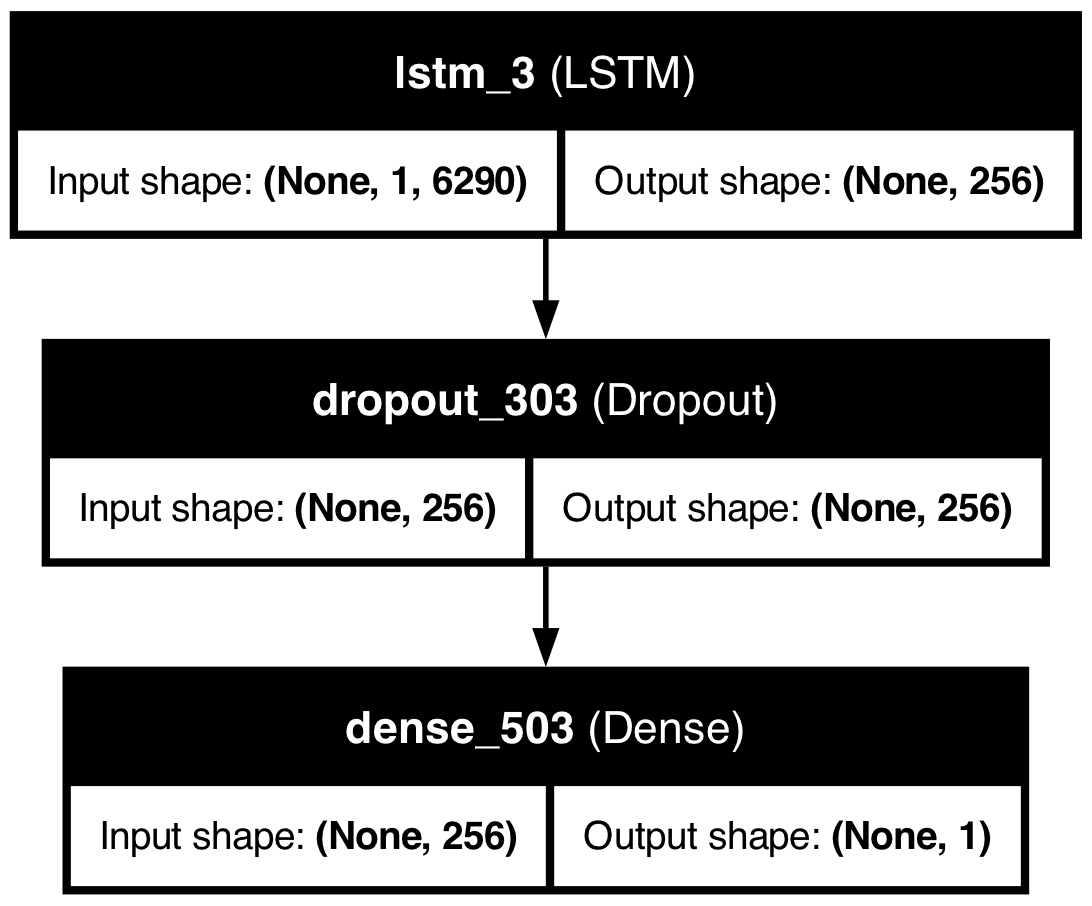

In [73]:
# Generate the plot
plot_model(model_2rIT, show_shapes=True, show_layer_names=True)

Epoch 1/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6148 - loss: 1.7686
Epoch 1: val_loss improved from inf to 0.78662, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.6151 - loss: 1.7668 - val_accuracy: 0.7476 - val_loss: 0.7866 - learning_rate: 1.0000e-04
Epoch 2/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7608 - loss: 0.7364
Epoch 2: val_loss improved from 0.78662 to 0.67478, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7608 - loss: 0.7363 - val_accuracy: 0.7542 - val_loss: 0.6748 - learning_rate: 1.0000e-04
Epoch 3/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7748 - loss: 0.6663
Epoch 3: val_loss improved from 0.67478 to 0.65091, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7748 - loss: 0.6663 - val_accuracy: 0.7678 - val_loss: 0.6509 - learning_rate: 1.0000e-04
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 

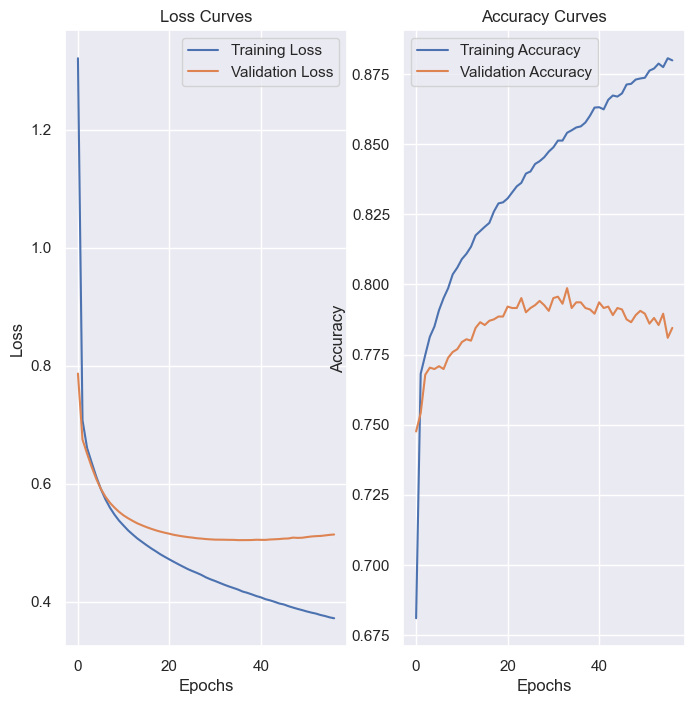

In [74]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2rIT_history = model_2rIT.fit(
    rX_train_lstm, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_2rIT_history)

In [75]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_2rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m2rIT_accuracy = accuracy_score(ry_test, ry_pred)
m2rIT_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m2rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2rIT_accuracy:.2%}", f"{m2rIT_precision:.3f}", f"{m2rIT_recall:.3f}", f"{m2rIT_f1:.3f}", f"{m2rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Model Performance          Results
         accuracy           79.25%
        precision            0.794
           recall            0.792
         f1_score            0.792
    time/instance 0.001174 seconds


In [76]:
store_results('Model_2rIT', m2rIT_accuracy, m2rIT_precision, m2rIT_recall, m2rIT_f1, m2rIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds
4  Model_2cWV   75.20%     0.759  0.752    0.750  0.000119 seconds
5  Model_2rWV   73.14%     0.737  0.731    0.730  0.000113 seconds
6  Model_2cIT   77.99%     0.782  0.780    0.780  0.000947 seconds
7  Model_2rIT   79.25%     0.794  0.792    0.792  0.001174 seconds


### LSTM (stacked)

Now I use another LSTM (LSTM stacked)

#### LSTM (stacked) with cleaned data

In [167]:
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2, regularization=0.001):
    model = Sequential()
    # First layer needs input_shape, subsequent layers infer shape automatically
    model.add(LSTM(units=lstm_units, return_sequences=(num_layers > 1),
                   input_shape=(cX_train_lstm.shape[1], cX_train_lstm.shape[2]),
                   kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    for i in range(num_layers - 1): 
        model.add(LSTM(units=lstm_units, return_sequences=(i < num_layers - 2),
                       kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model,lstm_units=128, learning_rate=0.001, num_layers=2, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Define the reduced grid search parameters
param_grid = {
    'lstm_units': [128, 256],  # Focused values for LSTM units
    'learning_rate': [0.001, 0.0001],  # Narrow range for learning rate
    'num_layers': [2, 3]  # Number of stacked LSTM layers
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fit the grid search
grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.500000 using {'learning_rate': 0.001, 'lstm_units': 128, 'num_layers': 3}
0.500000 (0.000124) with: {'learning_rate': 0.001, 'lstm_units': 128, 'num_layers': 3}


In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_3cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_3cIT.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_448"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_212 (LSTM)                 │ (None, 1, 128)         │     3,493,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_213 (LSTM)                 │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_214 (LSTM)                 │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_976 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,757,185 (14.33 MB)

 Trainable params: 3,757,185 (14.33 MB)

 Non-trainable params: 0 (0.00 B)

None


python(50347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


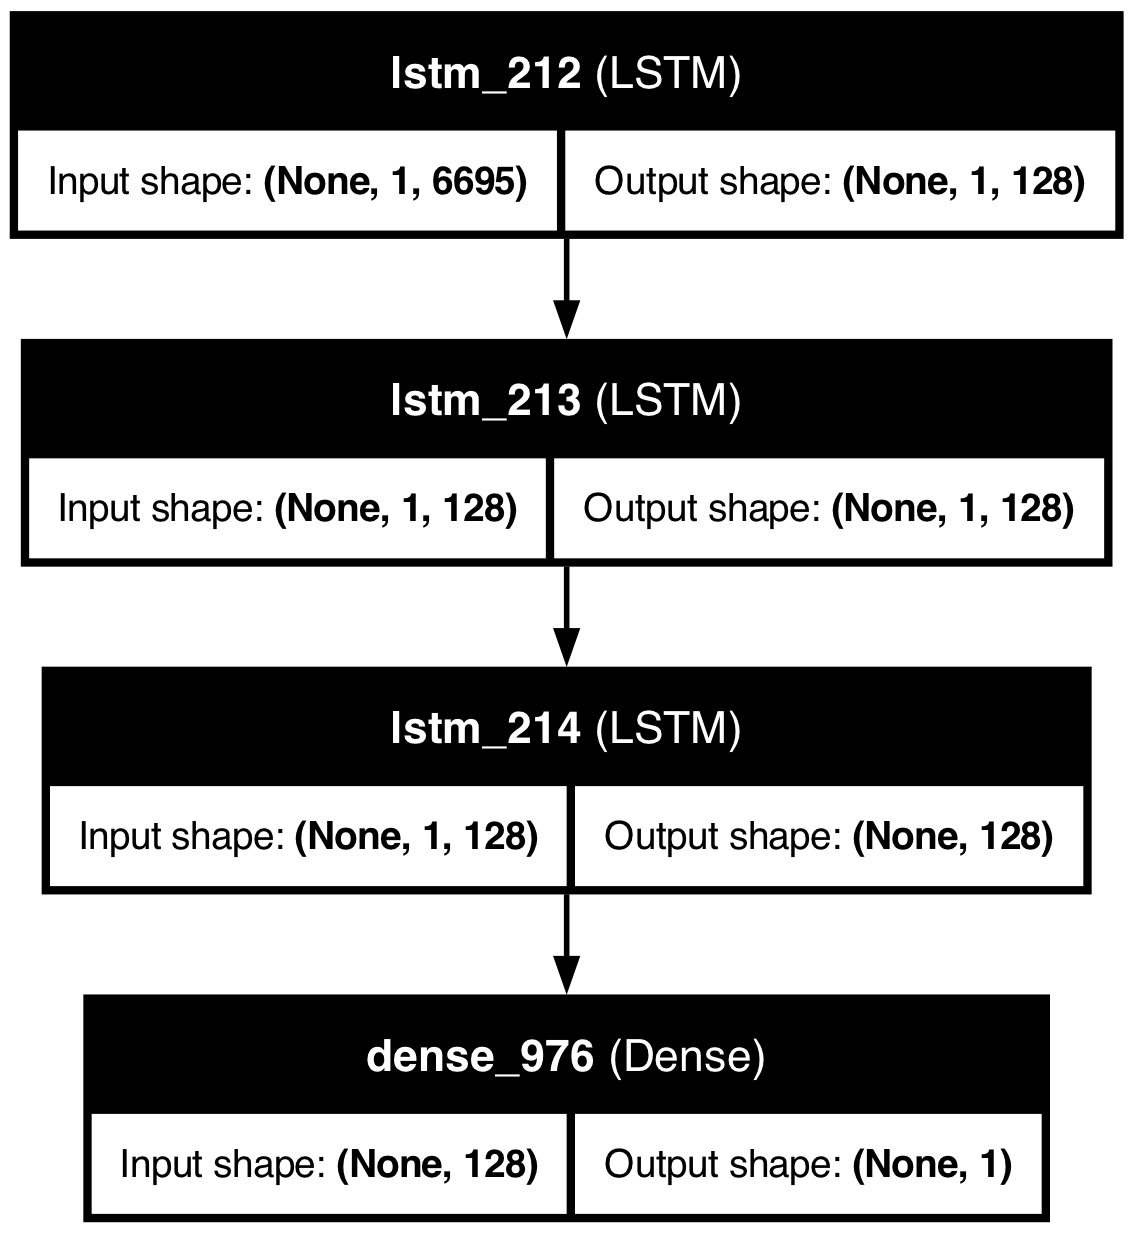

In [ ]:
# Generate the plot
plot_model(model_3cIT, show_shapes=True, show_layer_names=True)

In [ ]:
ss

NameError: name 'ss' is not defined

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3cIT_history = model_3cIT.fit(
    cX_train_lstm, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3cIT_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_3cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3cIT_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m3cIT_accuracy = accuracy_score(cy_test, cy_pred)
m3cIT_precision = precision_score(cy_test, cy_pred, average='weighted')
m3cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m3cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3cIT_accuracy:.2%}", f"{m3cIT_precision:.3f}", f"{m3cIT_recall:.3f}", f"{m3cIT_f1:.3f}", f"{m3cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Model Performance          Results
         accuracy           77.95%
        precision            0.781
           recall            0.780
         f1_score            0.779
    time/instance 0.002067 seconds


In [ ]:
store_results('Model_3cIT', m3cIT_accuracy, m3cIT_precision, m3cIT_recall, m3cIT_f1, m3cIT_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3  Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds
4  Model_2cWV   75.20%     0.759  0.752    0.750  0.000119 seconds
5  Model_2rWV   73.14%     0.737  0.731    0.730  0.000113 seconds
6  Model_2cIT   77.99%     0.782  0.780    0.780  0.000947 seconds
7  Model_2rIT   79.25%     0.794  0.792    0.792  0.001174 seconds
8  Model_3cIT   77.95%     0.781  0.780    0.779  0.002067 seconds


#### LSTM (stacked) with raw data

In [ ]:
def create_model(lstm_units=128, learning_rate=0.001, dropout_rate=0.3, num_layers=2, regularization=0.001):
    model = Sequential()
    # First layer needs input_shape, subsequent layers infer shape automatically
    model.add(LSTM(units=lstm_units, return_sequences=(num_layers > 1),
                   input_shape=(rX_train_lstm.shape[1], rX_train_lstm.shape[2]),
                   kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    for i in range(num_layers - 1): 
        model.add(LSTM(units=lstm_units, return_sequences=(i < num_layers - 2),
                       kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model,lstm_units=128, learning_rate=0.001, num_layers=2, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fit the grid search
grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_3rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_3rIT.summary())

In [ ]:
# Generate the plot
plot_model(model_3rIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3rIT_history = model_3rIT.fit(
    rX_train_lstm, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3rIT_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_3rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m3rIT_accuracy = accuracy_score(ry_test, ry_pred)
m3rIT_precision = precision_score(ry_test, ry_pred, average='weighted')
m3rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m3rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3rIT_accuracy:.2%}", f"{m3rIT_precision:.3f}", f"{m3rIT_recall:.3f}", f"{m3rIT_f1:.3f}", f"{m3rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_3rIT', m3rIT_accuracy, m3rIT_precision, m3rIT_recall, m3rIT_f1, m3rIT_time_per_instance)

# View the consolidated results
print(results_df)

### USE (Universal Sentence Encoder)

In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

#### USE with clean data (trainable and not trainable)

We will start with the trainable version

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=True)

# Precompute the embeddings for the training and test sets
cX_train_embeddings = np.array(USE_embedding(cX_train))
cX_test_embeddings = np.array(USE_embedding(cX_test))

2024-05-18 20:28:04.172711: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [171]:
print(cX_train_embeddings.shape[0])

9884


In [173]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(cX_train_embeddings, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.778935 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.774180 (0.006157) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.774484 (0.001897) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.774281 (0.007063) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.776709 (0.006642) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.773472 (0.005903) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.775900 (0.003643) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.764669 (0.009452) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.773371 (0.005983) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.776608 (0.005688) with: {'learning_ra

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4cUST = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4cUST.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_309"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_682 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_513 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_683 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(43861) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(43862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


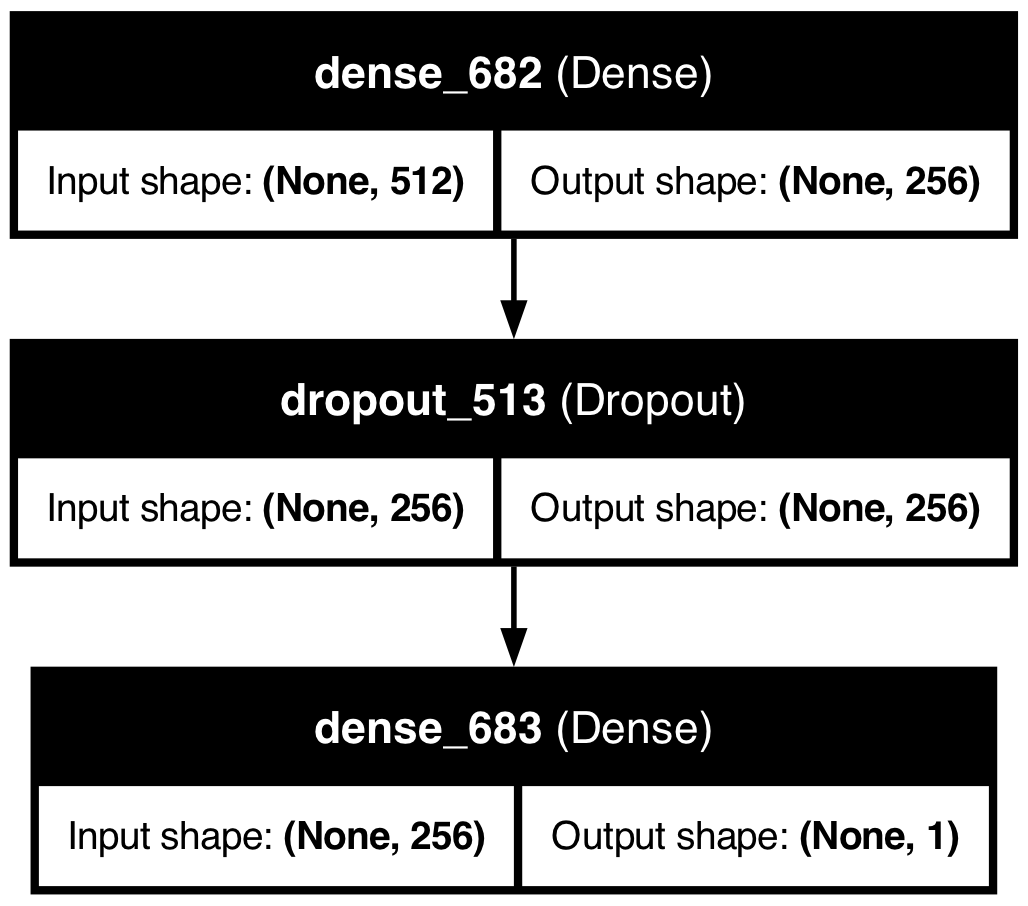

In [ ]:
# Generate the plot
plot_model(model_4cUST, show_shapes=True, show_layer_names=True)

Epoch 1/300
237/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6248 - loss: 0.9813
Epoch 1: val_loss improved from inf to 0.83107, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6275 - loss: 0.9786 - val_accuracy: 0.7167 - val_loss: 0.8311 - learning_rate: 1.0000e-04
Epoch 2/300
238/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7353 - loss: 0.7956
Epoch 2: val_loss improved from 0.83107 to 0.71232, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7353 - loss: 0.7942 - val_accuracy: 0.7380 - val_loss: 0.7123 - learning_rate: 1.0000e-04
Epoch 3/300
240/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7439 - loss: 0.6905
Epoch 3: val_loss improved from 0.71232 to 0.64345, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7443 - loss: 0.6897 - val_accuracy: 0.7466 - val_loss: 0.6434 - learning_rate: 1.0000e-04
Epoch 4/300
231/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

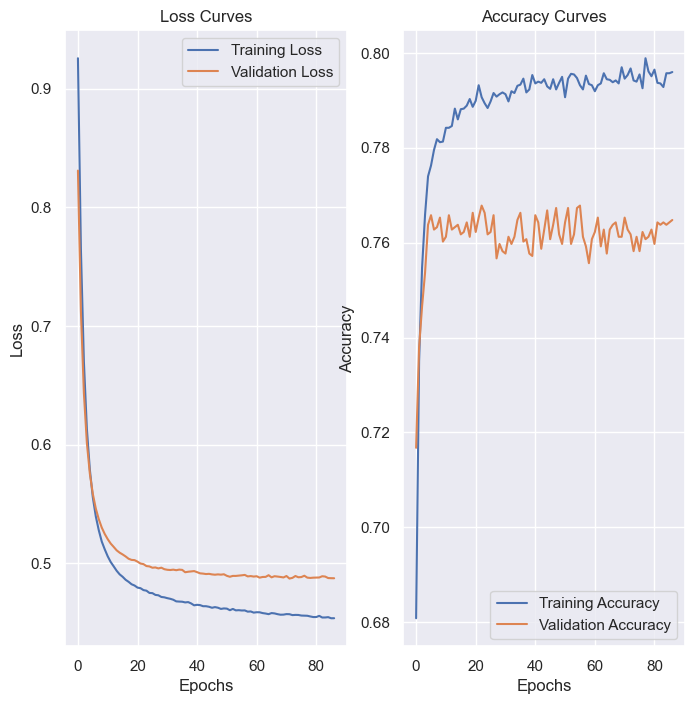

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4cUST_history = model_4cUST.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4cUST_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4cUST.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4cUST_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4cUST_accuracy = accuracy_score(cy_test, cy_pred)
m4cUST_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4cUST_recall = recall_score(cy_test, cy_pred, average='weighted')
m4cUST_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4cUST_accuracy:.2%}", f"{m4cUST_precision:.3f}", f"{m4cUST_recall:.3f}", f"{m4cUST_f1:.3f}", f"{m4cUST_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           76.94%
        precision            0.770
           recall            0.769
         f1_score            0.769
    time/instance 0.000309 seconds


In [ ]:
store_results('Model_4cUST', m4cUST_accuracy, m4cUST_precision, m4cUST_recall, m4cUST_f1, m4cUST_time_per_instance)

# View the consolidated results
print(results_df)

         Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1   Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3   Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds
4   Model_2cWV   75.20%     0.759  0.752    0.750  0.000119 seconds
5   Model_2rWV   73.14%     0.737  0.731    0.730  0.000113 seconds
6   Model_2cIT   77.99%     0.782  0.780    0.780  0.000947 seconds
7   Model_2rIT   79.25%     0.794  0.792    0.792  0.001174 seconds
8   Model_3cIT   77.95%     0.781  0.780    0.779  0.002067 seconds
9  Model_4cUST   76.94%     0.770  0.769    0.769  0.000309 seconds


Now the non-trainable version

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
cX_train_embeddings = np.array(USE_embedding(cX_train))
cX_test_embeddings = np.array(USE_embedding(cX_test))

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(cX_train_embeddings, cy_train, callbacks=[early_stopping])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7119 - loss: 0.5880
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.4696
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7724 - loss: 0.4685
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7761 - loss: 0.4584
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7845 - loss: 0.4560
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7902 - loss: 0.4459
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - loss: 0.4431
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7845 - loss: 0.4487
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7941 - loss: 0.4353
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.4429
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.4292
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6926 - loss: 0.5903
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7775 - loss: 0.4595
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7787 - loss: 0.4559
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7874 - loss: 0.4534
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7888 - loss: 0.4445
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.4343
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.4350
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7945 - loss: 0.4270
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7963 - loss: 0.4421
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7959 - loss: 0.4386
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8033 - loss: 0.4207
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7196 - loss: 0.5835
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7816 - loss: 0.4656
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7866 - loss: 0.4583
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7964 - loss: 0.4427
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7967 - loss: 0.4399
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7982 - loss: 0.4283
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7935 - loss: 0.4329
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7988 - loss: 0.4307
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8026 - loss: 0.4251
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7977 - loss: 0.4342
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.4348
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7057 - loss: 0.7352
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7653 - loss: 0.5339
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7781 - loss: 0.5094
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7820 - loss: 0.4953
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.4906
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7768 - loss: 0.4960
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7886 - loss: 0.4849
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7803 - loss: 0.4993
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7781 - loss: 0.4961
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7831 - loss: 0.4914
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7682 - loss: 0.4921
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7075 - loss: 0.7335
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.5180
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7774 - loss: 0.5025
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7766 - loss: 0.4930
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7863 - loss: 0.4883
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7776 - loss: 0.4910
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7855 - loss: 0.4878
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7824 - loss: 0.4904
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7850 - loss: 0.4785
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7944 - loss: 0.4728
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7849 - loss: 0.4788
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7060 - loss: 0.7284
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7747 - loss: 0.5270
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - loss: 0.5039
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7873 - loss: 0.4928
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7787 - loss: 0.4962
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7909 - loss: 0.4840
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7838 - loss: 0.4883
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7913 - loss: 0.4774
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7924 - loss: 0.4788
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7824 - loss: 0.4834
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7878 - loss: 0.4740
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7093 - loss: 0.5836
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7821 - loss: 0.4676
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.4593
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.4677
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7859 - loss: 0.4538
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8033 - loss: 0.4318
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7946 - loss: 0.4353
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7898 - loss: 0.4381
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7856 - loss: 0.4442
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7945 - loss: 0.4268
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7987 - loss: 0.4224
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7070 - loss: 0.5811
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7865 - loss: 0.4495
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7927 - loss: 0.4530
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7907 - loss: 0.4418
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7960 - loss: 0.4390
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7866 - loss: 0.4532
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7947 - loss: 0.4341
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7939 - loss: 0.4275
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7972 - loss: 0.4314
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7908 - loss: 0.4354
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.4151
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6999 - loss: 0.5734
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7944 - loss: 0.4504
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.4371
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7931 - loss: 0.4335
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.4435
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7878 - loss: 0.4478
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8014 - loss: 0.4343
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8019 - loss: 0.4248
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8041 - loss: 0.4256
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8059 - loss: 0.4154
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7936 - loss: 0.4280
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6998 - loss: 0.7881
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.5271
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7803 - loss: 0.5189
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7753 - loss: 0.5130
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.5042
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7801 - loss: 0.5012
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7866 - loss: 0.5011
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.4882
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7783 - loss: 0.4986
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7824 - loss: 0.4944
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.4849
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7119 - loss: 0.7796
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7729 - loss: 0.5401
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7778 - loss: 0.5088
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7863 - loss: 0.4945
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7910 - loss: 0.4863
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.4952
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7782 - loss: 0.4917
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7904 - loss: 0.4831
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7830 - loss: 0.4908
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7893 - loss: 0.4796
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.4765
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7051 - loss: 0.7806
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7803 - loss: 0.5345
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7836 - loss: 0.5079
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7933 - loss: 0.4850
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7827 - loss: 0.5029
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7941 - loss: 0.4813
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7807 - loss: 0.4958
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.4976
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7809 - loss: 0.4892
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7906 - loss: 0.4817
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7953 - loss: 0.4785
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7117 - loss: 0.5785
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4769
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.4565
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7935 - loss: 0.4434
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7857 - loss: 0.4563
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7873 - loss: 0.4505
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.4548
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7928 - loss: 0.4441
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7998 - loss: 0.4370
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7824 - loss: 0.4476
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.4542
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7050 - loss: 0.5739
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7726 - loss: 0.4651
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.4483
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7810 - loss: 0.4547
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.4468
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7984 - loss: 0.4323
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7937 - loss: 0.4433
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7911 - loss: 0.4381
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.4299
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.4351
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8007 - loss: 0.4288
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7187 - loss: 0.5691
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.4553
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7865 - loss: 0.4527
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7953 - loss: 0.4444
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7903 - loss: 0.4402
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7916 - loss: 0.4393
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7979 - loss: 0.4360
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8062 - loss: 0.4264
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7929 - loss: 0.4356
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8088 - loss: 0.4237
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8024 - loss: 0.4257
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7109 - loss: 0.7818
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7626 - loss: 0.5399
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7754 - loss: 0.5077
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7805 - loss: 0.5071
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7737 - loss: 0.5103
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7763 - loss: 0.4979
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7716 - loss: 0.5012
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7787 - loss: 0.4944
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7782 - loss: 0.4994
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 0.4868
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7814 - loss: 0.4963
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7210 - loss: 0.7781
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7763 - loss: 0.5179
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.4980
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7839 - loss: 0.4871
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7839 - loss: 0.4925
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7747 - loss: 0.4954
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7848 - loss: 0.4902
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.4868
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.4795
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7803 - loss: 0.4926
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7817 - loss: 0.4819
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7172 - loss: 0.7803
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7787 - loss: 0.5173
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7808 - loss: 0.4971
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7920 - loss: 0.4916
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.4929
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7761 - loss: 0.4948
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7769 - loss: 0.4967
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.4808
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.4924
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4979
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7879 - loss: 0.4813
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7059 - loss: 0.5678
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7828 - loss: 0.4593
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7809 - loss: 0.4566
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7861 - loss: 0.4569
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7848 - loss: 0.4505
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7883 - loss: 0.4433
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7805 - loss: 0.4488
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7871 - loss: 0.4422
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7901 - loss: 0.4295
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8006 - loss: 0.4140
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7943 - loss: 0.4254
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7259 - loss: 0.5573
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7881 - loss: 0.4540
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7872 - loss: 0.4426
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7804 - loss: 0.4504
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4384
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7935 - loss: 0.4330
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7977 - loss: 0.4338
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7976 - loss: 0.4270
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7972 - loss: 0.4256
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7976 - loss: 0.4298
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7998 - loss: 0.4208
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7174 - loss: 0.5536
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7831 - loss: 0.4596
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7918 - loss: 0.4510
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7928 - loss: 0.4456
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7968 - loss: 0.4384
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8012 - loss: 0.4346
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7935 - loss: 0.4364
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8094 - loss: 0.4208
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7993 - loss: 0.4242
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7994 - loss: 0.4277
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8017 - loss: 0.4128
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - accuracy: 0.6958 - loss: 0.8723
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7674 - loss: 0.5433
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7823 - loss: 0.5123
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7887 - loss: 0.5051
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7815 - loss: 0.5047
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7743 - loss: 0.5077
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7827 - loss: 0.4958
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7822 - loss: 0.4991
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7687 - loss: 0.5089
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7797 - loss: 0.4950
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7796 - loss: 0.5026
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accura

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7282 - loss: 0.8661
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7825 - loss: 0.5372
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7770 - loss: 0.5202
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7888 - loss: 0.4947
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7920 - loss: 0.4814
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7796 - loss: 0.4935
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7886 - loss: 0.4832
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7877 - loss: 0.4954
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7936 - loss: 0.4814
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7882 - loss: 0.4877
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7934 - loss: 0.4798
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7232 - loss: 0.8627
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7732 - loss: 0.5414
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7789 - loss: 0.5043
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7878 - loss: 0.4982
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7826 - loss: 0.5008
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7888 - loss: 0.4873
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7927 - loss: 0.4861
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7828 - loss: 0.4854
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7876 - loss: 0.4916
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7928 - loss: 0.4758
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7844 - loss: 0.4883
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6565 - loss: 0.6734
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7127 - loss: 0.6117
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7264 - loss: 0.5674
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7443 - loss: 0.5325
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7606 - loss: 0.5067
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7663 - loss: 0.4975
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7689 - loss: 0.4848
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7720 - loss: 0.4801
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7788 - loss: 0.4700
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.4698
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7805 - loss: 0.4625
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6268 - loss: 0.6763
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7253 - loss: 0.6107
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7448 - loss: 0.5592
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7492 - loss: 0.5295
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7631 - loss: 0.4971
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7688 - loss: 0.4909
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7727 - loss: 0.4798
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7902 - loss: 0.4644
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7869 - loss: 0.4557
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7806 - loss: 0.4734
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7806 - loss: 0.4584
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5884 - loss: 0.6795
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7250 - loss: 0.6126
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7434 - loss: 0.5575
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7430 - loss: 0.5358
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7562 - loss: 0.5161
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7744 - loss: 0.4802
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7765 - loss: 0.4695
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7863 - loss: 0.4673
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7883 - loss: 0.4657
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7678 - loss: 0.4745
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7843 - loss: 0.4603
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6727 - loss: 0.8630
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7175 - loss: 0.7656
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7310 - loss: 0.6945
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7509 - loss: 0.6443
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7476 - loss: 0.6212
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7753 - loss: 0.5834
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7767 - loss: 0.5663
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7628 - loss: 0.5639
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7698 - loss: 0.5515
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7780 - loss: 0.5410
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7790 - loss: 0.5285
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6199 - loss: 0.8687
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7285 - loss: 0.7649
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7341 - loss: 0.6923
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7449 - loss: 0.6438
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7645 - loss: 0.6103
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7728 - loss: 0.5783
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7752 - loss: 0.5644
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7727 - loss: 0.5520
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7714 - loss: 0.5522
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7808 - loss: 0.5334
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7674 - loss: 0.5308
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5958 - loss: 0.8708
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7240 - loss: 0.7653
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7356 - loss: 0.6933
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7498 - loss: 0.6493
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7670 - loss: 0.6050
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7673 - loss: 0.5875
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7697 - loss: 0.5681
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7724 - loss: 0.5529
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7747 - loss: 0.5421
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7718 - loss: 0.5385
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7840 - loss: 0.5248
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6507 - loss: 0.6778
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7237 - loss: 0.5967
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7476 - loss: 0.5280
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7691 - loss: 0.4941
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7758 - loss: 0.4757
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7761 - loss: 0.4712
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7666 - loss: 0.4823
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7788 - loss: 0.4625
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7795 - loss: 0.4656
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7922 - loss: 0.4523
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7938 - loss: 0.4498
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6252 - loss: 0.6801
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7244 - loss: 0.5975
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7477 - loss: 0.5185
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7720 - loss: 0.4797
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7807 - loss: 0.4731
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7847 - loss: 0.4588
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7789 - loss: 0.4541
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7811 - loss: 0.4454
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7881 - loss: 0.4532
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7830 - loss: 0.4588
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7843 - loss: 0.4568
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6204 - loss: 0.6797
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7292 - loss: 0.5920
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7452 - loss: 0.5225
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7759 - loss: 0.4795
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7748 - loss: 0.4744
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7779 - loss: 0.4653
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.4550
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7839 - loss: 0.4608
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7964 - loss: 0.4493
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7876 - loss: 0.4527
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7910 - loss: 0.4456
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5904 - loss: 0.9556
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7247 - loss: 0.8346
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7351 - loss: 0.7240
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7498 - loss: 0.6655
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7671 - loss: 0.6202
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7679 - loss: 0.6018
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7697 - loss: 0.5881
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7800 - loss: 0.5587
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7801 - loss: 0.5624
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7746 - loss: 0.5497
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7868 - loss: 0.5408
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5860 - loss: 0.9545
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7171 - loss: 0.8338
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7381 - loss: 0.7192
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7545 - loss: 0.6556
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7786 - loss: 0.6101
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7828 - loss: 0.5846
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7884 - loss: 0.5706
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.5655
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7799 - loss: 0.5577
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7904 - loss: 0.5359
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7953 - loss: 0.5253
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6001 - loss: 0.9553
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7175 - loss: 0.8289
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7365 - loss: 0.7213
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7670 - loss: 0.6480
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7634 - loss: 0.6234
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7801 - loss: 0.5902
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7843 - loss: 0.5774
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7816 - loss: 0.5617
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7777 - loss: 0.5574
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7854 - loss: 0.5466
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7833 - loss: 0.5372
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6594 - loss: 0.6691
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7377 - loss: 0.5825
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7456 - loss: 0.5421
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7582 - loss: 0.5108
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7623 - loss: 0.4960
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7714 - loss: 0.4902
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7744 - loss: 0.4743
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7692 - loss: 0.4790
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.4715
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7838 - loss: 0.4649
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.4506
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6459 - loss: 0.6692
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7191 - loss: 0.5890
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7501 - loss: 0.5373
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7652 - loss: 0.5066
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7736 - loss: 0.4895
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7823 - loss: 0.4725
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7762 - loss: 0.4704
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7780 - loss: 0.4662
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.4611
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7790 - loss: 0.4637
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7861 - loss: 0.4517
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6767 - loss: 0.6663
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7327 - loss: 0.5820
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7436 - loss: 0.5362
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7680 - loss: 0.5017
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7671 - loss: 0.4867
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.4740
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7821 - loss: 0.4664
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - loss: 0.4538
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7921 - loss: 0.4502
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7769 - loss: 0.4679
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7801 - loss: 0.4550
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6464 - loss: 0.9856
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.8240
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7474 - loss: 0.7218
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7492 - loss: 0.6607
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7632 - loss: 0.6126
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.5826
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7721 - loss: 0.5672
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7641 - loss: 0.5573
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.5458
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.5253
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7665 - loss: 0.5328
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6414 - loss: 0.9869
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7247 - loss: 0.8247
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7447 - loss: 0.7171
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7425 - loss: 0.6596
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7686 - loss: 0.6117
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7679 - loss: 0.5769
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7913 - loss: 0.5485
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7824 - loss: 0.5411
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7809 - loss: 0.5329
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7900 - loss: 0.5128
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.5168
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6542 - loss: 0.9865
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7380 - loss: 0.8209
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7396 - loss: 0.7267
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7602 - loss: 0.6538
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7639 - loss: 0.6093
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.5708
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7752 - loss: 0.5585
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7811 - loss: 0.5422
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7774 - loss: 0.5444
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7820 - loss: 0.5258
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7934 - loss: 0.5045
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6491 - loss: 0.6722
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7290 - loss: 0.5521
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7656 - loss: 0.4891
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7766 - loss: 0.4695
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7870 - loss: 0.4577
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7725 - loss: 0.4751
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7888 - loss: 0.4573
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7775 - loss: 0.4510
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7869 - loss: 0.4611
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7932 - loss: 0.4432
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7947 - loss: 0.4416
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6564 - loss: 0.6708
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7406 - loss: 0.5353
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7692 - loss: 0.4781
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7873 - loss: 0.4561
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7800 - loss: 0.4622
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7776 - loss: 0.4565
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7838 - loss: 0.4589
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7936 - loss: 0.4476
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7855 - loss: 0.4530
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7894 - loss: 0.4424
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7895 - loss: 0.4449
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6425 - loss: 0.6712
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7420 - loss: 0.5376
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7799 - loss: 0.4748
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7831 - loss: 0.4634
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7851 - loss: 0.4552
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7863 - loss: 0.4506
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7938 - loss: 0.4474
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7946 - loss: 0.4377
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7857 - loss: 0.4499
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7820 - loss: 0.4495
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7832 - loss: 0.4595
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6482 - loss: 1.1465
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7280 - loss: 0.9159
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7584 - loss: 0.7676
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7758 - loss: 0.6832
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7789 - loss: 0.6423
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7769 - loss: 0.6096
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7819 - loss: 0.5861
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7855 - loss: 0.5703
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7768 - loss: 0.5598
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7933 - loss: 0.5381
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7806 - loss: 0.5419
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6325 - loss: 1.1487
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7160 - loss: 0.9183
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7651 - loss: 0.7568
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7698 - loss: 0.6857
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7821 - loss: 0.6273
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7827 - loss: 0.6014
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7766 - loss: 0.5887
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7879 - loss: 0.5564
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7834 - loss: 0.5546
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7779 - loss: 0.5422
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7897 - loss: 0.5208
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6243 - loss: 1.1455
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7309 - loss: 0.9110
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7677 - loss: 0.7543
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7775 - loss: 0.6719
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7736 - loss: 0.6329
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7752 - loss: 0.6053
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7844 - loss: 0.5768
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7842 - loss: 0.5598
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7879 - loss: 0.5428
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7820 - loss: 0.5350
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7765 - loss: 0.5416
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6529 - loss: 1.1208
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.8173
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7677 - loss: 0.6881
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7719 - loss: 0.6286
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7824 - loss: 0.5796
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7766 - loss: 0.5656
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7842 - loss: 0.5434
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7879 - loss: 0.5272
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7878 - loss: 0.5245
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7861 - loss: 0.5068
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7866 - loss: 0.5061
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.777721 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.774989 (0.006626) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.774281 (0.008377) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.775292 (0.011469) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.776405 (0.006390) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.774888 (0.007596) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.775698 (0.007332) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.770537 (0.010391) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.773168 (0.009041) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.777620 (0.005365) with: {'learning_ra

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4cUSF = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4cUSF.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_359"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_807 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_588 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_808 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_589 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_809 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(45245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


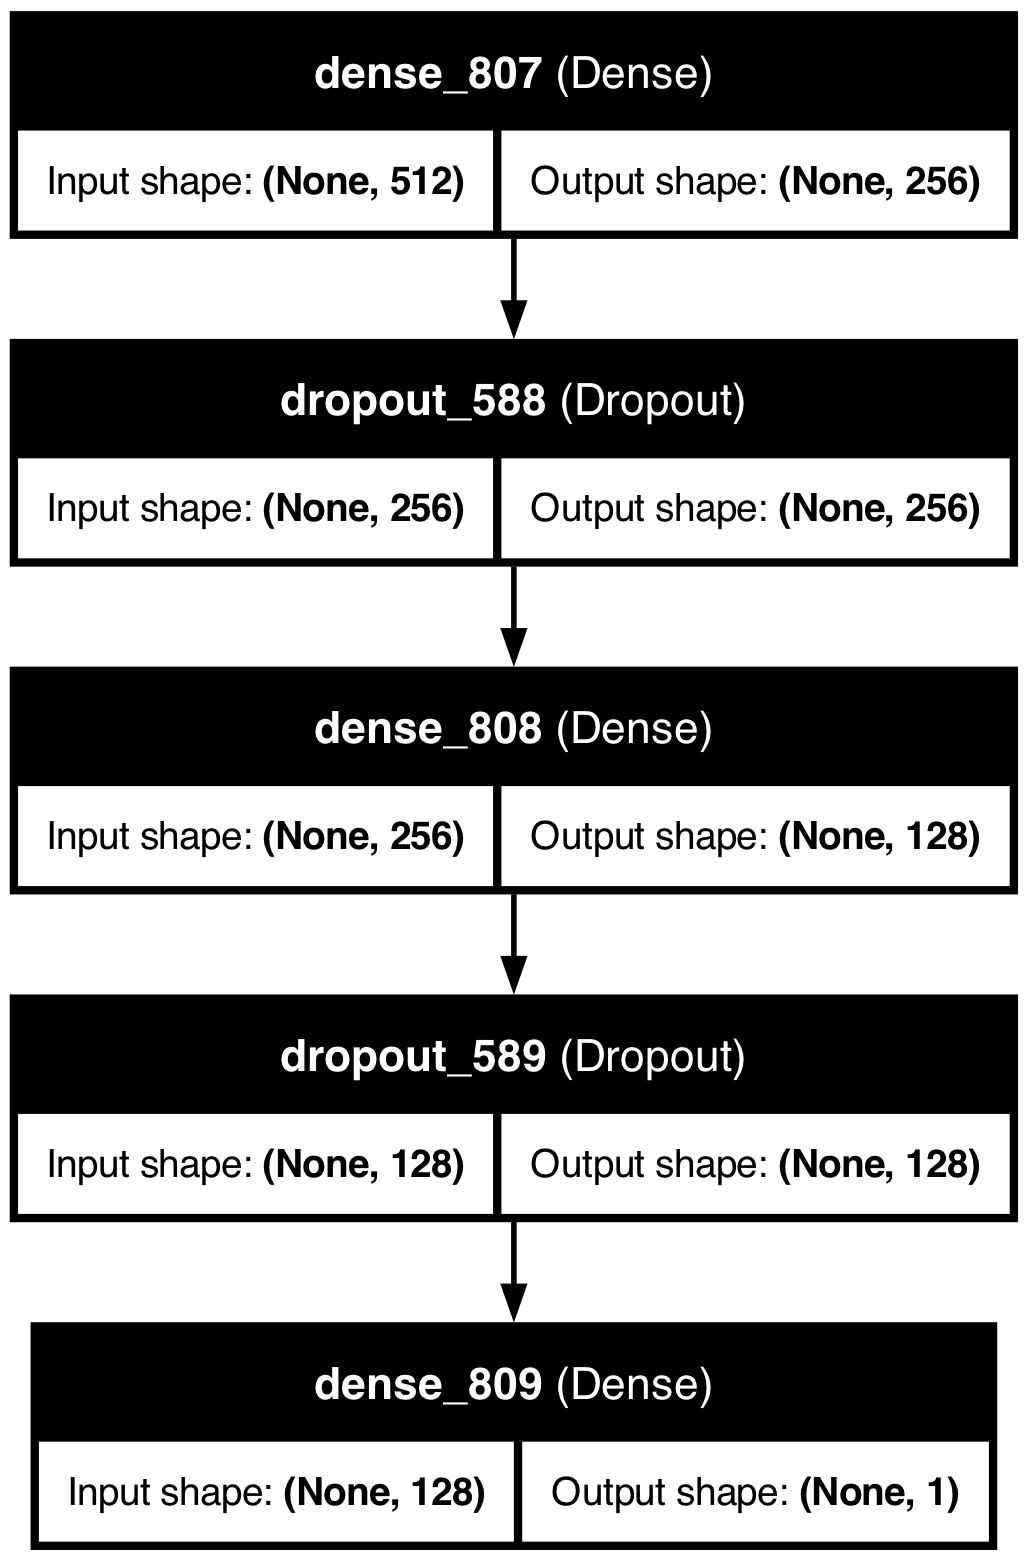

In [ ]:
# Generate the plot
plot_model(model_4cUSF, show_shapes=True, show_layer_names=True)

Epoch 1/300
236/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6431 - loss: 1.1363
Epoch 1: val_loss improved from inf to 0.91767, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6460 - loss: 1.1324 - val_accuracy: 0.7213 - val_loss: 0.9177 - learning_rate: 1.0000e-04
Epoch 2/300
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7400 - loss: 0.8643
Epoch 2: val_loss improved from 0.91767 to 0.75107, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7401 - loss: 0.8637 - val_accuracy: 0.7562 - val_loss: 0.7511 - learning_rate: 1.0000e-04
Epoch 3/300
245/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7623 - loss: 0.7231
Epoch 3: val_loss improved from 0.75107 to 0.67521, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7624 - loss: 0.7227 - val_accuracy: 0.7653 - val_loss: 0.6752 - learning_rate: 1.0000e-04
Epoch 4/300
234/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

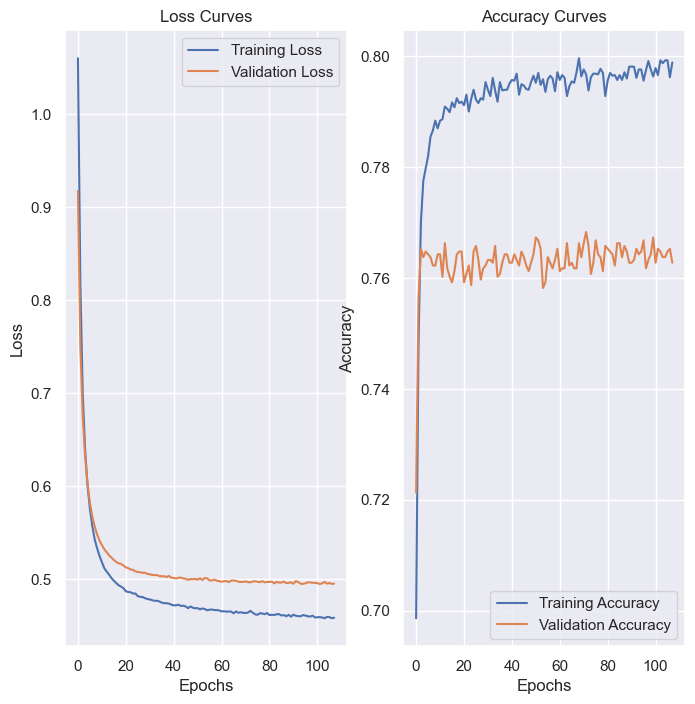

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4cUSF_history = model_4cUSF.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4cUSF_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4cUSF.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4cUSF_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4cUSF_accuracy = accuracy_score(cy_test, cy_pred)
m4cUSF_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4cUSF_recall = recall_score(cy_test, cy_pred, average='weighted')
m4cUSF_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4cUSF_accuracy:.2%}", f"{m4cUSF_precision:.3f}", f"{m4cUSF_recall:.3f}", f"{m4cUSF_f1:.3f}", f"{m4cUSF_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           76.98%
        precision            0.773
           recall            0.770
         f1_score            0.769
    time/instance 0.000277 seconds


In [ ]:
store_results('Model_4cUSF', m4cUSF_accuracy, m4cUSF_precision, m4cUSF_recall, m4cUSF_f1, m4cUSF_time_per_instance)

# View the consolidated results
print(results_df)

          Model Accuracy Precision Recall F1 Score Time per Instance
0    Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1    Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2    Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3    Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds
4    Model_2cWV   75.20%     0.759  0.752    0.750  0.000119 seconds
5    Model_2rWV   73.14%     0.737  0.731    0.730  0.000113 seconds
6    Model_2cIT   77.99%     0.782  0.780    0.780  0.000947 seconds
7    Model_2rIT   79.25%     0.794  0.792    0.792  0.001174 seconds
8    Model_3cIT   77.95%     0.781  0.780    0.779  0.002067 seconds
9   Model_4cUST   76.94%     0.770  0.769    0.769  0.000309 seconds
10  Model_4cUSF   76.98%     0.773  0.770    0.769  0.000277 seconds


#### USE with raw data (trainable and not trainable)

We will start with the trainable version

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=True)

# Precompute the embeddings for the training and test sets
rX_train_embeddings = np.array(USE_embedding(rX_train))
rX_test_embeddings = np.array(USE_embedding(rX_test))

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(rX_train_embeddings, ry_train, callbacks=[early_stopping])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7192 - loss: 0.5837
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7956 - loss: 0.4375
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8015 - loss: 0.4329
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7967 - loss: 0.4298
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8001 - loss: 0.4347
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8063 - loss: 0.4176
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8065 - loss: 0.4120
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8113 - loss: 0.4083
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8077 - loss: 0.4190
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8000 - loss: 0.4217
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8137 - loss: 0.4056
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7091 - loss: 0.5878
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.4354
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8073 - loss: 0.4106
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8082 - loss: 0.4149
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8024 - loss: 0.4102
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8116 - loss: 0.4052
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.4186
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8091 - loss: 0.4125
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8098 - loss: 0.4053
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8237 - loss: 0.3942
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8186 - loss: 0.4026
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7267 - loss: 0.5782
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7963 - loss: 0.4437
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8003 - loss: 0.4409
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8106 - loss: 0.4178
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8095 - loss: 0.4146
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8017 - loss: 0.4238
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8052 - loss: 0.4159
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8086 - loss: 0.4202
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8074 - loss: 0.4167
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8047 - loss: 0.4131
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8082 - loss: 0.4084
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7121 - loss: 0.7314
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7793 - loss: 0.5228
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7863 - loss: 0.4953
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7841 - loss: 0.4925
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7899 - loss: 0.4776
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7946 - loss: 0.4767
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7965 - loss: 0.4655
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8040 - loss: 0.4637
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7974 - loss: 0.4571
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7841 - loss: 0.4830
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7898 - loss: 0.4654
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7210 - loss: 0.7289
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7890 - loss: 0.5051
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7962 - loss: 0.4817
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7917 - loss: 0.4758
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7897 - loss: 0.4686
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7951 - loss: 0.4658
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7998 - loss: 0.4680
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8018 - loss: 0.4542
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7920 - loss: 0.4645
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8071 - loss: 0.4443
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7982 - loss: 0.4571
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7170 - loss: 0.7249
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7927 - loss: 0.5119
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7959 - loss: 0.4922
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7931 - loss: 0.4779
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8071 - loss: 0.4671
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8095 - loss: 0.4563
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7967 - loss: 0.4730
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8013 - loss: 0.4640
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.4636
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8127 - loss: 0.4537
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8051 - loss: 0.4660
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7103 - loss: 0.5696
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7966 - loss: 0.4418
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7918 - loss: 0.4421
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8070 - loss: 0.4244
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8055 - loss: 0.4219
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8050 - loss: 0.4151
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8081 - loss: 0.4123
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7969 - loss: 0.4198
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7990 - loss: 0.4194
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8149 - loss: 0.3949
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.4103
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7114 - loss: 0.5700
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7947 - loss: 0.4297
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8072 - loss: 0.4205
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8083 - loss: 0.4121
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8105 - loss: 0.4128
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8118 - loss: 0.4066
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8148 - loss: 0.3975
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8168 - loss: 0.3982
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8078 - loss: 0.3978
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8189 - loss: 0.3918
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8195 - loss: 0.3900
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7384 - loss: 0.5675
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7925 - loss: 0.4457
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8159 - loss: 0.4142
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8071 - loss: 0.4198
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8013 - loss: 0.4173
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8008 - loss: 0.4325
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8140 - loss: 0.4032
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8035 - loss: 0.4171
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8063 - loss: 0.4098
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8118 - loss: 0.4034
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8144 - loss: 0.3945
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7260 - loss: 0.7735
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7882 - loss: 0.5208
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8022 - loss: 0.4866
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4888
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7977 - loss: 0.4854
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7965 - loss: 0.4786
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4802
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7868 - loss: 0.4806
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7914 - loss: 0.4821
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8045 - loss: 0.4643
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8061 - loss: 0.4671
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7267 - loss: 0.7684
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7870 - loss: 0.5231
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8016 - loss: 0.4837
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8090 - loss: 0.4657
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.4644
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8105 - loss: 0.4560
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8046 - loss: 0.4693
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7880 - loss: 0.4804
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8085 - loss: 0.4570
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.4612
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.4636
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7125 - loss: 0.7766
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7947 - loss: 0.5198
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7862 - loss: 0.4996
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8093 - loss: 0.4744
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7951 - loss: 0.4869
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7983 - loss: 0.4776
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8085 - loss: 0.4578
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7941 - loss: 0.4714
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8046 - loss: 0.4671
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8075 - loss: 0.4575
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8005 - loss: 0.4689
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7258 - loss: 0.5677
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.4447
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.4388
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7976 - loss: 0.4278
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.4246
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7990 - loss: 0.4368
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8077 - loss: 0.4098
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8052 - loss: 0.4245
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8015 - loss: 0.4261
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8090 - loss: 0.4067
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8115 - loss: 0.4129
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7373 - loss: 0.5634
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7924 - loss: 0.4371
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - loss: 0.4202
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.4316
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8042 - loss: 0.4164
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7986 - loss: 0.4180
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8173 - loss: 0.4059
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8064 - loss: 0.4139
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8048 - loss: 0.4150
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8157 - loss: 0.3985
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8186 - loss: 0.3975
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7370 - loss: 0.5626
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7946 - loss: 0.4328
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8021 - loss: 0.4304
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.4133
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.4142
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8136 - loss: 0.4114
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8106 - loss: 0.4214
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8082 - loss: 0.4156
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8072 - loss: 0.4106
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8080 - loss: 0.4168
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8155 - loss: 0.4078
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7175 - loss: 0.7788
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7850 - loss: 0.5133
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.4982
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7888 - loss: 0.4854
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7956 - loss: 0.4722
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8025 - loss: 0.4694
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7982 - loss: 0.4689
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4758
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.4774
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7977 - loss: 0.4727
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8005 - loss: 0.4607
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7278 - loss: 0.7735
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7852 - loss: 0.5065
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7938 - loss: 0.4802
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7964 - loss: 0.4746
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8003 - loss: 0.4689
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8006 - loss: 0.4637
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.4556
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7998 - loss: 0.4695
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.4595
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.4658
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8031 - loss: 0.4609
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7251 - loss: 0.7738
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7920 - loss: 0.5033
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7898 - loss: 0.4861
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7942 - loss: 0.4811
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7981 - loss: 0.4789
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8004 - loss: 0.4730
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8066 - loss: 0.4584
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7964 - loss: 0.4721
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7988 - loss: 0.4749
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7968 - loss: 0.4673
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8046 - loss: 0.4650
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7315 - loss: 0.5477
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7852 - loss: 0.4579
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8007 - loss: 0.4316
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8018 - loss: 0.4316
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7993 - loss: 0.4218
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8096 - loss: 0.4182
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8012 - loss: 0.4259
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8118 - loss: 0.3983
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8031 - loss: 0.4123
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8174 - loss: 0.3960
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8075 - loss: 0.3947
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7249 - loss: 0.5452
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7983 - loss: 0.4301
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8039 - loss: 0.4217
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8097 - loss: 0.4098
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8146 - loss: 0.4089
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8084 - loss: 0.4119
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8166 - loss: 0.4014
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8076 - loss: 0.3988
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8120 - loss: 0.3960
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8121 - loss: 0.3913
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8137 - loss: 0.3870
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7381 - loss: 0.5497
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7991 - loss: 0.4340
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8086 - loss: 0.4166
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8035 - loss: 0.4282
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7976 - loss: 0.4273
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8088 - loss: 0.4133
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8051 - loss: 0.4148
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8143 - loss: 0.3963
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7988 - loss: 0.4059
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8052 - loss: 0.4057
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8106 - loss: 0.3944
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7328 - loss: 0.8623
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7858 - loss: 0.5230
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7850 - loss: 0.4998
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7948 - loss: 0.4912
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7960 - loss: 0.4771
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7936 - loss: 0.4868
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7954 - loss: 0.4752
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7910 - loss: 0.4853
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8034 - loss: 0.4704
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8013 - loss: 0.4703
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7942 - loss: 0.4730
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7249 - loss: 0.8622
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7937 - loss: 0.5155
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7960 - loss: 0.4847
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8070 - loss: 0.4778
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7948 - loss: 0.4851
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8040 - loss: 0.4677
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8037 - loss: 0.4765
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7937 - loss: 0.4637
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7987 - loss: 0.4664
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8036 - loss: 0.4625
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7887 - loss: 0.4705
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7286 - loss: 0.8554
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7996 - loss: 0.5199
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7947 - loss: 0.4968
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8010 - loss: 0.4721
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7965 - loss: 0.4847
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8028 - loss: 0.4706
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7959 - loss: 0.4759
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8002 - loss: 0.4707
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8087 - loss: 0.4552
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8092 - loss: 0.4694
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7977 - loss: 0.4840
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6276 - loss: 0.6759
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7251 - loss: 0.6073
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7415 - loss: 0.5561
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7611 - loss: 0.5155
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7622 - loss: 0.4996
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7810 - loss: 0.4811
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.4708
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.4558
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.4592
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7885 - loss: 0.4459
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7937 - loss: 0.4424
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accurac

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6729 - loss: 0.6742
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7248 - loss: 0.6128
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7437 - loss: 0.5572
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7580 - loss: 0.5197
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7705 - loss: 0.4907
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7932 - loss: 0.4669
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7900 - loss: 0.4634
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7911 - loss: 0.4495
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7857 - loss: 0.4486
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7916 - loss: 0.4371
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7931 - loss: 0.4359
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6335 - loss: 0.6756
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7302 - loss: 0.6066
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7458 - loss: 0.5516
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7632 - loss: 0.5198
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7844 - loss: 0.4878
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7826 - loss: 0.4758
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - loss: 0.4667
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8028 - loss: 0.4438
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7920 - loss: 0.4481
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8005 - loss: 0.4362
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7896 - loss: 0.4469
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6199 - loss: 0.8688
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7243 - loss: 0.7629
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7455 - loss: 0.6930
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7583 - loss: 0.6415
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7618 - loss: 0.6069
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7767 - loss: 0.5776
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7734 - loss: 0.5633
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7863 - loss: 0.5436
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7813 - loss: 0.5365
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7857 - loss: 0.5218
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7829 - loss: 0.5148
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6049 - loss: 0.8721
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7181 - loss: 0.7698
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7460 - loss: 0.6911
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7624 - loss: 0.6340
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7727 - loss: 0.5975
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7828 - loss: 0.5671
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7843 - loss: 0.5540
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7926 - loss: 0.5339
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7888 - loss: 0.5224
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7825 - loss: 0.5200
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7902 - loss: 0.5077
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6343 - loss: 0.8666
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7262 - loss: 0.7636
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7516 - loss: 0.6897
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7676 - loss: 0.6369
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7736 - loss: 0.6038
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.5733
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7897 - loss: 0.5526
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7894 - loss: 0.5417
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7916 - loss: 0.5272
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8022 - loss: 0.5090
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7913 - loss: 0.5100
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6201 - loss: 0.6813
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7342 - loss: 0.5953
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7597 - loss: 0.5140
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.4619
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7798 - loss: 0.4590
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7845 - loss: 0.4438
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7888 - loss: 0.4435
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - loss: 0.4408
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.4315
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7957 - loss: 0.4349
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.4332
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6218 - loss: 0.6814
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7367 - loss: 0.5931
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7615 - loss: 0.5043
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7848 - loss: 0.4598
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7895 - loss: 0.4524
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7940 - loss: 0.4335
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7970 - loss: 0.4333
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7971 - loss: 0.4392
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7917 - loss: 0.4266
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8119 - loss: 0.4084
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7963 - loss: 0.4329
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6108 - loss: 0.6804
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7309 - loss: 0.5964
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7727 - loss: 0.4980
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7757 - loss: 0.4777
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7870 - loss: 0.4603
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7901 - loss: 0.4534
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8059 - loss: 0.4260
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8066 - loss: 0.4259
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8037 - loss: 0.4440
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8044 - loss: 0.4277
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8093 - loss: 0.4256
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6352 - loss: 0.9543
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7298 - loss: 0.8292
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7598 - loss: 0.7074
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - loss: 0.6460
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.6025
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7836 - loss: 0.5823
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7934 - loss: 0.5580
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.5497
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833 - loss: 0.5484
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7924 - loss: 0.5283
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8019 - loss: 0.5183
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6240 - loss: 0.9532
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7394 - loss: 0.8249
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7479 - loss: 0.7154
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7879 - loss: 0.6295
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7911 - loss: 0.6010
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - loss: 0.5806
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7983 - loss: 0.5578
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7886 - loss: 0.5523
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7963 - loss: 0.5373
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7925 - loss: 0.5307
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7965 - loss: 0.5138
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6265 - loss: 0.9527
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7334 - loss: 0.8235
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7664 - loss: 0.7014
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7710 - loss: 0.6457
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7858 - loss: 0.6018
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8028 - loss: 0.5677
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.5569
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8003 - loss: 0.5408
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7970 - loss: 0.5419
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8011 - loss: 0.5269
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8113 - loss: 0.5051
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6660 - loss: 0.6662
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7343 - loss: 0.5793
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7520 - loss: 0.5297
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7664 - loss: 0.4948
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7836 - loss: 0.4652
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7773 - loss: 0.4655
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7863 - loss: 0.4543
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - loss: 0.4510
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7873 - loss: 0.4544
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7884 - loss: 0.4442
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7926 - loss: 0.4395
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5948 - loss: 0.6764
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7365 - loss: 0.5853
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7602 - loss: 0.5261
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7730 - loss: 0.4859
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7809 - loss: 0.4696
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7951 - loss: 0.4449
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7881 - loss: 0.4453
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7960 - loss: 0.4343
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7991 - loss: 0.4228
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7891 - loss: 0.4398
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7958 - loss: 0.4234
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6176 - loss: 0.6724
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7422 - loss: 0.5841
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7551 - loss: 0.5318
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7713 - loss: 0.4885
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7945 - loss: 0.4631
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8002 - loss: 0.4481
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8036 - loss: 0.4446
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.4454
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8054 - loss: 0.4298
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7936 - loss: 0.4426
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7994 - loss: 0.4405
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6386 - loss: 0.9854
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7437 - loss: 0.8203
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7407 - loss: 0.7188
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7666 - loss: 0.6422
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7777 - loss: 0.5959
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7764 - loss: 0.5719
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7887 - loss: 0.5470
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7916 - loss: 0.5313
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8021 - loss: 0.5050
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7944 - loss: 0.5021
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7922 - loss: 0.5076
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6653 - loss: 0.9853
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7364 - loss: 0.8188
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7538 - loss: 0.7160
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7643 - loss: 0.6488
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7814 - loss: 0.5953
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7805 - loss: 0.5659
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7841 - loss: 0.5496
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7899 - loss: 0.5273
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7949 - loss: 0.5135
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7908 - loss: 0.5083
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7905 - loss: 0.5008
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6835 - loss: 0.9834
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7293 - loss: 0.8241
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7655 - loss: 0.7082
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7699 - loss: 0.6426
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7830 - loss: 0.5983
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7894 - loss: 0.5704
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7909 - loss: 0.5527
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7894 - loss: 0.5275
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7967 - loss: 0.5188
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7925 - loss: 0.5121
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7991 - loss: 0.4987
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6409 - loss: 0.6721
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7431 - loss: 0.5451
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7779 - loss: 0.4701
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7834 - loss: 0.4524
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7936 - loss: 0.4410
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7961 - loss: 0.4373
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7923 - loss: 0.4351
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8012 - loss: 0.4233
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7957 - loss: 0.4378
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7950 - loss: 0.4487
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8007 - loss: 0.4250
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6474 - loss: 0.6725
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7524 - loss: 0.5338
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7790 - loss: 0.4673
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7983 - loss: 0.4358
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8016 - loss: 0.4221
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7969 - loss: 0.4228
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7969 - loss: 0.4283
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8079 - loss: 0.4092
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8035 - loss: 0.4172
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8070 - loss: 0.4142
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7975 - loss: 0.4218
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/st

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6436 - loss: 0.6724
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7524 - loss: 0.5326
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7834 - loss: 0.4609
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7939 - loss: 0.4396
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7916 - loss: 0.4433
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7913 - loss: 0.4373
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8023 - loss: 0.4310
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8032 - loss: 0.4342
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8016 - loss: 0.4336
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7940 - loss: 0.4357
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8041 - loss: 0.4164
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6157 - loss: 1.1479
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7374 - loss: 0.9085
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7681 - loss: 0.7468
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7730 - loss: 0.6792
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7879 - loss: 0.6109
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7892 - loss: 0.5832
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7872 - loss: 0.5648
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7981 - loss: 0.5384
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7876 - loss: 0.5459
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7962 - loss: 0.5172
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7952 - loss: 0.5173
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6662 - loss: 1.1447
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7529 - loss: 0.9047
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7745 - loss: 0.7538
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7871 - loss: 0.6729
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7936 - loss: 0.6265
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7997 - loss: 0.5831
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7860 - loss: 0.5756
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8058 - loss: 0.5358
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8044 - loss: 0.5249
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8061 - loss: 0.5157
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7984 - loss: 0.5163
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6441 - loss: 1.1457
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7514 - loss: 0.9016
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7780 - loss: 0.7475
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7964 - loss: 0.6675
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8027 - loss: 0.6206
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7914 - loss: 0.5945
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7931 - loss: 0.5667
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8043 - loss: 0.5482
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8020 - loss: 0.5409
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7991 - loss: 0.5258
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8007 - loss: 0.5184
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6573 - loss: 0.6587
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7528 - loss: 0.5460
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7653 - loss: 0.4963
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7878 - loss: 0.4598
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7958 - loss: 0.4429
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7880 - loss: 0.4412
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7946 - loss: 0.4391
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8033 - loss: 0.4310
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7931 - loss: 0.4386
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8022 - loss: 0.4282
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7971 - loss: 0.4294
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.793808 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.789558 (0.005703) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.789558 (0.005081) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.788648 (0.006331) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.792695 (0.006391) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.790975 (0.009251) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.788041 (0.007274) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.785613 (0.007558) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.790975 (0.005982) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.792290 (0.004493) with: {'learning_rate':

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4rUST = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4rUST.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_409"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_932 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_663 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_933 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

None


python(46957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(46958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


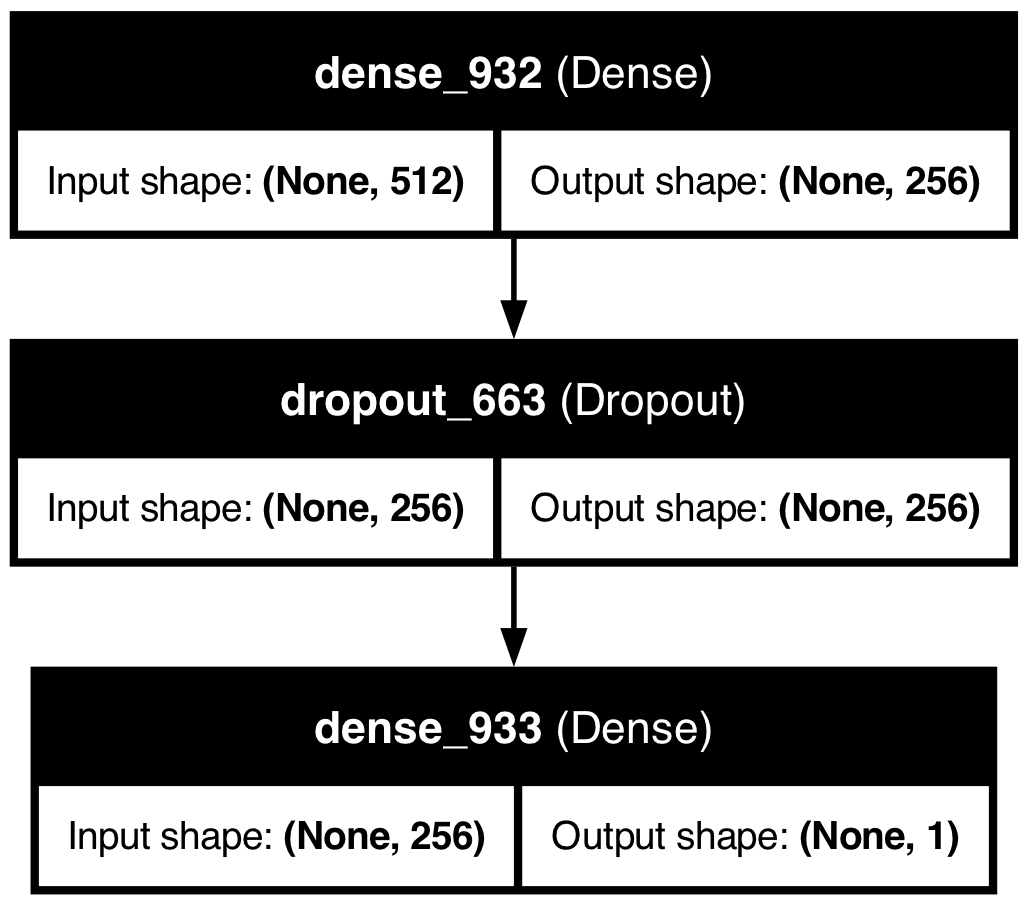

In [ ]:
# Generate the plot
plot_model(model_4rUST, show_shapes=True, show_layer_names=True)

Epoch 1/300
237/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6617 - loss: 0.6663
Epoch 1: val_loss improved from inf to 0.59036, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6638 - loss: 0.6650 - val_accuracy: 0.7258 - val_loss: 0.5904 - learning_rate: 1.0000e-04
Epoch 2/300
245/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7351 - loss: 0.5696
Epoch 2: val_loss improved from 0.59036 to 0.53425, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7351 - loss: 0.5694 - val_accuracy: 0.7395 - val_loss: 0.5342 - learning_rate: 1.0000e-04
Epoch 3/300
230/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7657 - loss: 0.5160
Epoch 3: val_loss improved from 0.53425 to 0.50608, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7657 - loss: 0.5157 - val_accuracy: 0.7511 - val_loss: 0.5061 - learning_rate: 1.0000e-04
Epoch 4/300
228/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

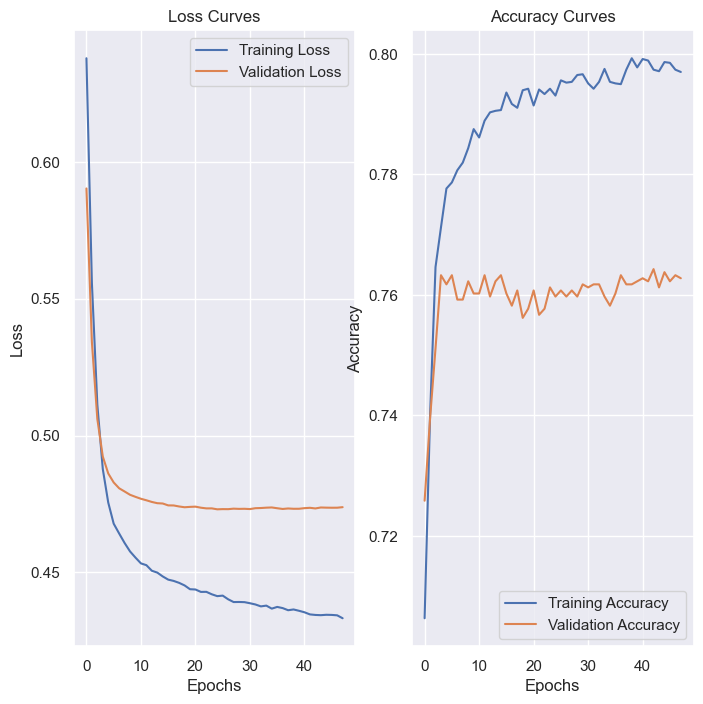

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4rUST_history = model_4rUST.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4rUST_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4rUST.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4rUST_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4rUST_accuracy = accuracy_score(ry_test, ry_pred)
m4rUST_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4rUST_recall = recall_score(ry_test, ry_pred, average='weighted')
m4rUST_f1 = f1_score(ry_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4rUST_accuracy:.2%}", f"{m4rUST_precision:.3f}", f"{m4rUST_recall:.3f}", f"{m4rUST_f1:.3f}", f"{m4rUST_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           76.82%
        precision            0.774
           recall            0.768
         f1_score            0.769
    time/instance 0.000257 seconds


In [ ]:
store_results('Model_4rUST', m4rUST_accuracy, m4rUST_precision, m4rUST_recall, m4rUST_f1, m4rUST_time_per_instance)

# View the consolidated results
print(results_df)

          Model Accuracy Precision Recall F1 Score Time per Instance
0    Model_0cTI   78.80%     0.793  0.788    0.787  0.000001 seconds
1    Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2    Model_1cTI   78.28%     0.785  0.783    0.782  0.000226 seconds
3    Model_1rTI   79.37%     0.796  0.794    0.793  0.000206 seconds
4    Model_2cWV   75.20%     0.759  0.752    0.750  0.000119 seconds
5    Model_2rWV   73.14%     0.737  0.731    0.730  0.000113 seconds
6    Model_2cIT   77.99%     0.782  0.780    0.780  0.000947 seconds
7    Model_2rIT   79.25%     0.794  0.792    0.792  0.001174 seconds
8    Model_3cIT   77.95%     0.781  0.780    0.779  0.002067 seconds
9   Model_4cUST   76.94%     0.770  0.769    0.769  0.000309 seconds
10  Model_4cUSF   76.98%     0.773  0.770    0.769  0.000277 seconds
11  Model_4rUST   76.82%     0.774  0.768    0.769  0.000257 seconds


Now the non-trainable version

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
rX_train_embeddings = np.array(USE_embedding(rX_train))
rX_test_embeddings = np.array(USE_embedding(rX_test))

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(rX_train_embeddings, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.785106 using {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.785106 (0.008622) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}


In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4rUSF = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4rUSF.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,793 (257.00 KB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 0 (0.00 B)

None


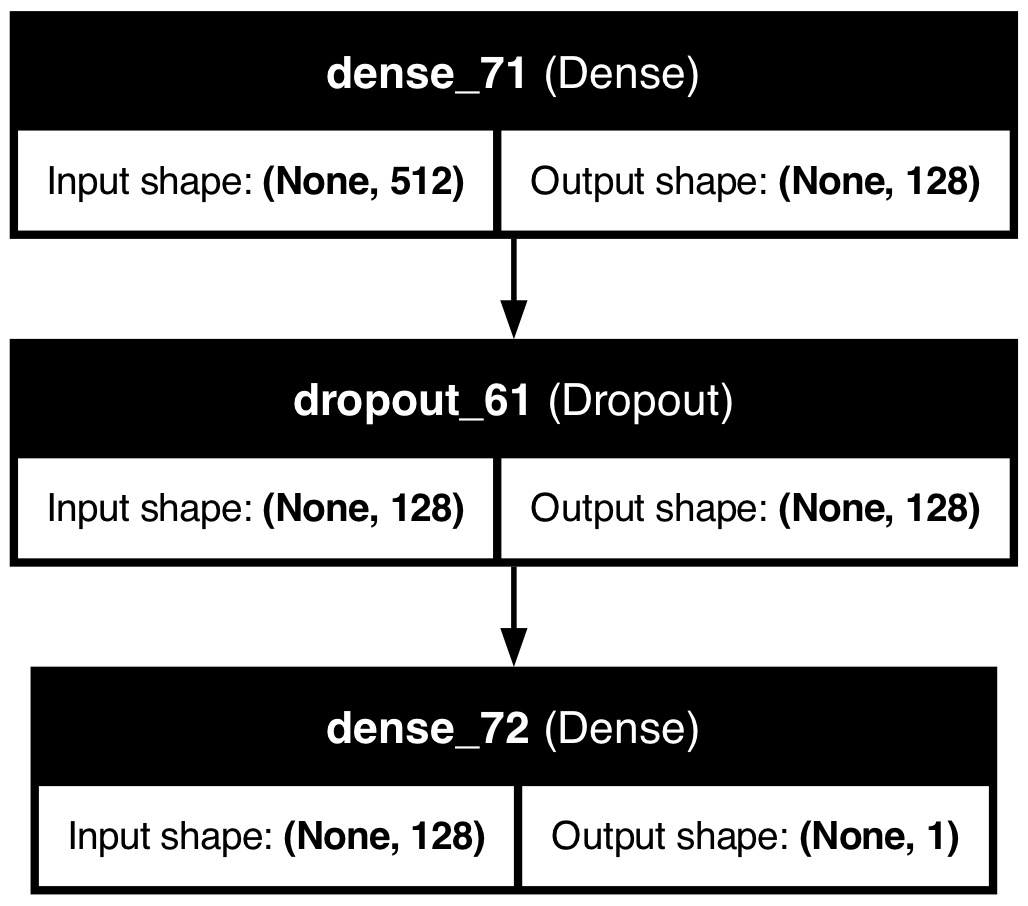

In [ ]:
# Generate the plot
plot_model(model_4rUSF, show_shapes=True, show_layer_names=True)

241/248 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6956 - loss: 0.5857
Epoch 1: val_loss improved from inf to 0.48244, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6972 - loss: 0.5837 - val_accuracy: 0.7643 - val_loss: 0.4824 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


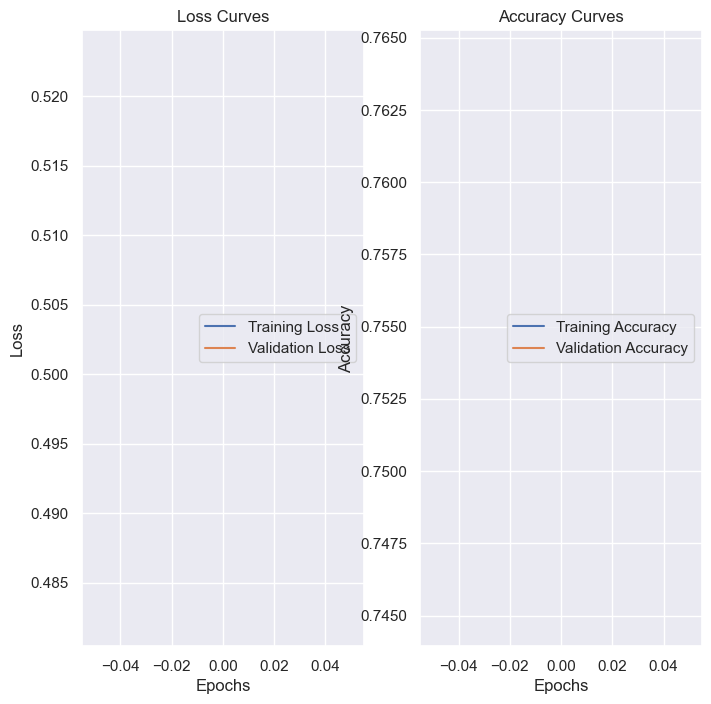

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4rUSF_history = model_4rUSF.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4rUSF_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4rUSF.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4rUSF_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4rUSF_accuracy = accuracy_score(ry_test, ry_pred)
m4rUSF_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4rUSF_recall = recall_score(ry_test, ry_pred, average='weighted')
m4rUSF_f1 = f1_score(ry_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4rUSF_accuracy:.2%}", f"{m4rUSF_precision:.3f}", f"{m4rUSF_recall:.3f}", f"{m4rUSF_f1:.3f}", f"{m4rUSF_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_4rUSF', m4rUSF_accuracy, m4rUSF_precision, m4rUSF_recall, m4rUSF_f1, m4rUSF_time_per_instance)

# View the consolidated results
print(results_df)

### USE (Universal Sentence Encoder) (old version)

Here I will use the universal encoder from Google (USE)

#### USE with cleaned data

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=True)

# Precompute the embeddings for the training and test sets
cX_train_embeddings = np.array(USE_embedding(cX_train))
cX_test_embeddings = np.array(USE_embedding(cX_test))

# Precompute the embeddings for the training and test sets
rX_train_embeddings = np.array(USE_embedding(rX_train))
rX_test_embeddings = np.array(USE_embedding(rX_test))

In [ ]:
# Define the model
model_4c = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddings.shape[1],)),
    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model_4c.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

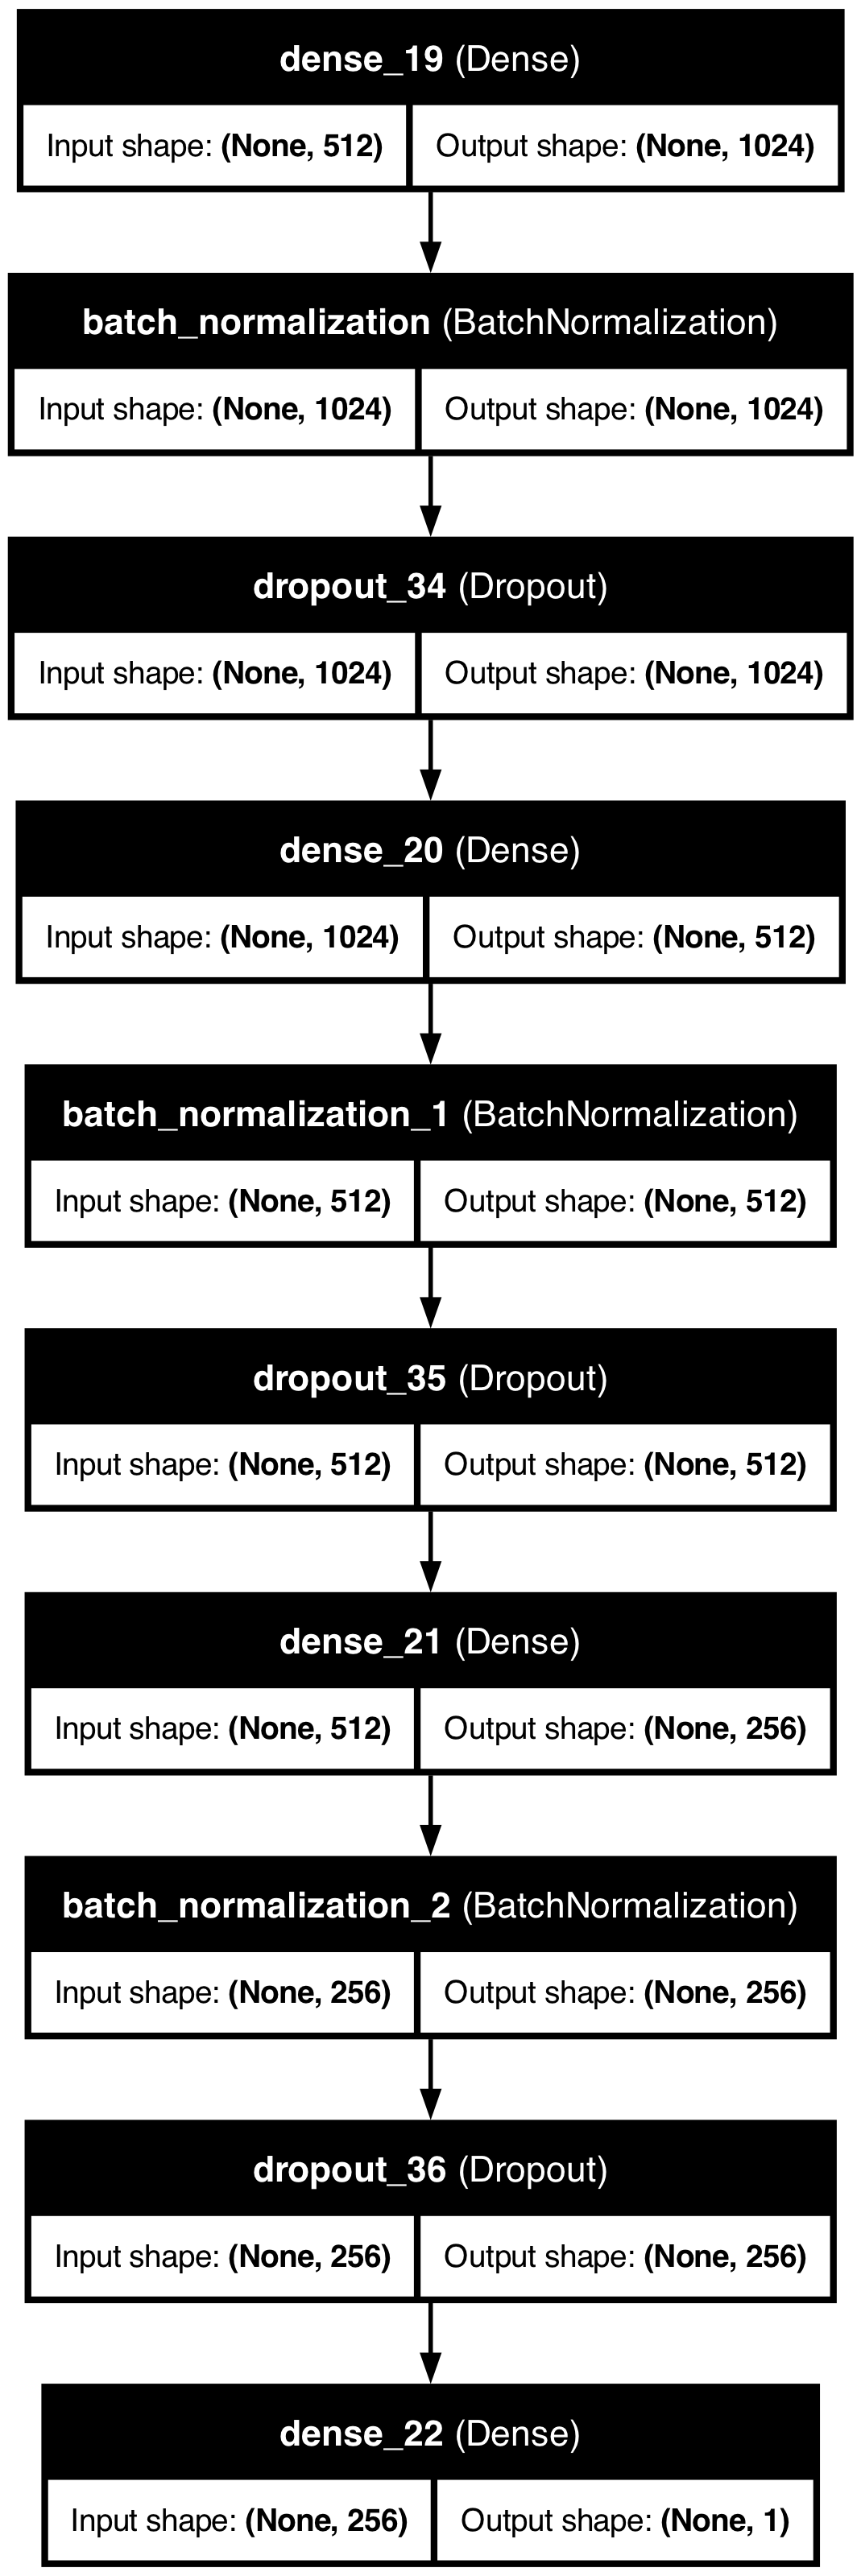

In [ ]:
# Generate the plot
plot_model(model_4c, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
epochs = 300

# Fit the model
model_4c_history = model_4c.fit(
    cX_train_embeddings, 
    cy_train, 
    batch_size=64, 
    epochs=epochs, 
    validation_split=0.2, 
    callbacks=[callback_es]
)

# Model Summary
print(model_4c.summary())

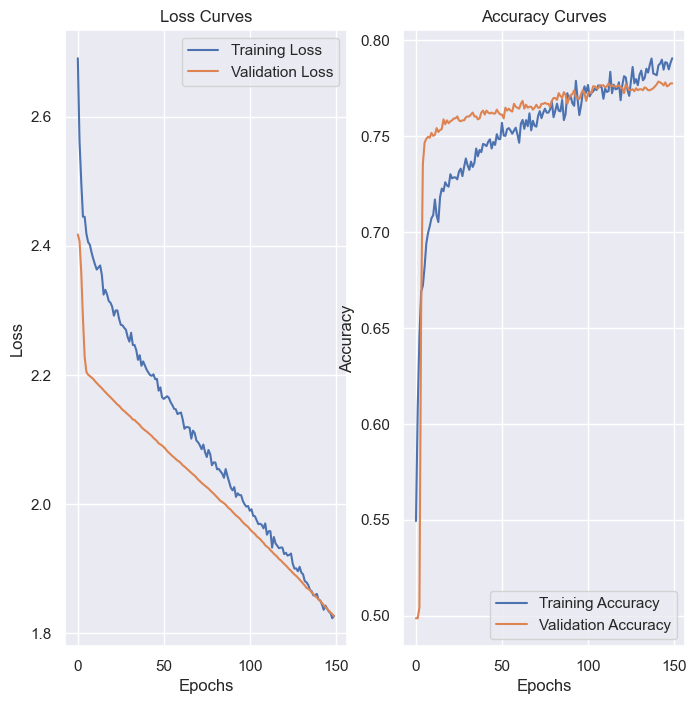

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_4c_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4c.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4c_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4c_accuracy = accuracy_score(cy_test, cy_pred)
m4c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4c_recall = recall_score(cy_test, cy_pred, average='weighted')
m4c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4c_accuracy:.2%}", f"{m4c_precision:.3f}", f"{m4c_recall:.3f}", f"{m4c_f1:.3f}", f"{m4c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Model Performance          Results
         accuracy           77.91%
        precision            0.779
           recall            0.779
         f1_score            0.779
    time/instance 0.000591 seconds


In [ ]:
#store_results('Model_4c', m4c_accuracy, m4c_precision, m4c_recall, m4c_f1, m4c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds
13  Model_1r   70.75%     0.715  0.708    0.705  0.000131 seconds
14  Model_

#### USE with raw data

In [ ]:
# Define the model
model_4r = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(rX_train_embeddings.shape[1],)),
    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Using an optimizer with adaptive learning rate
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model_4r.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])

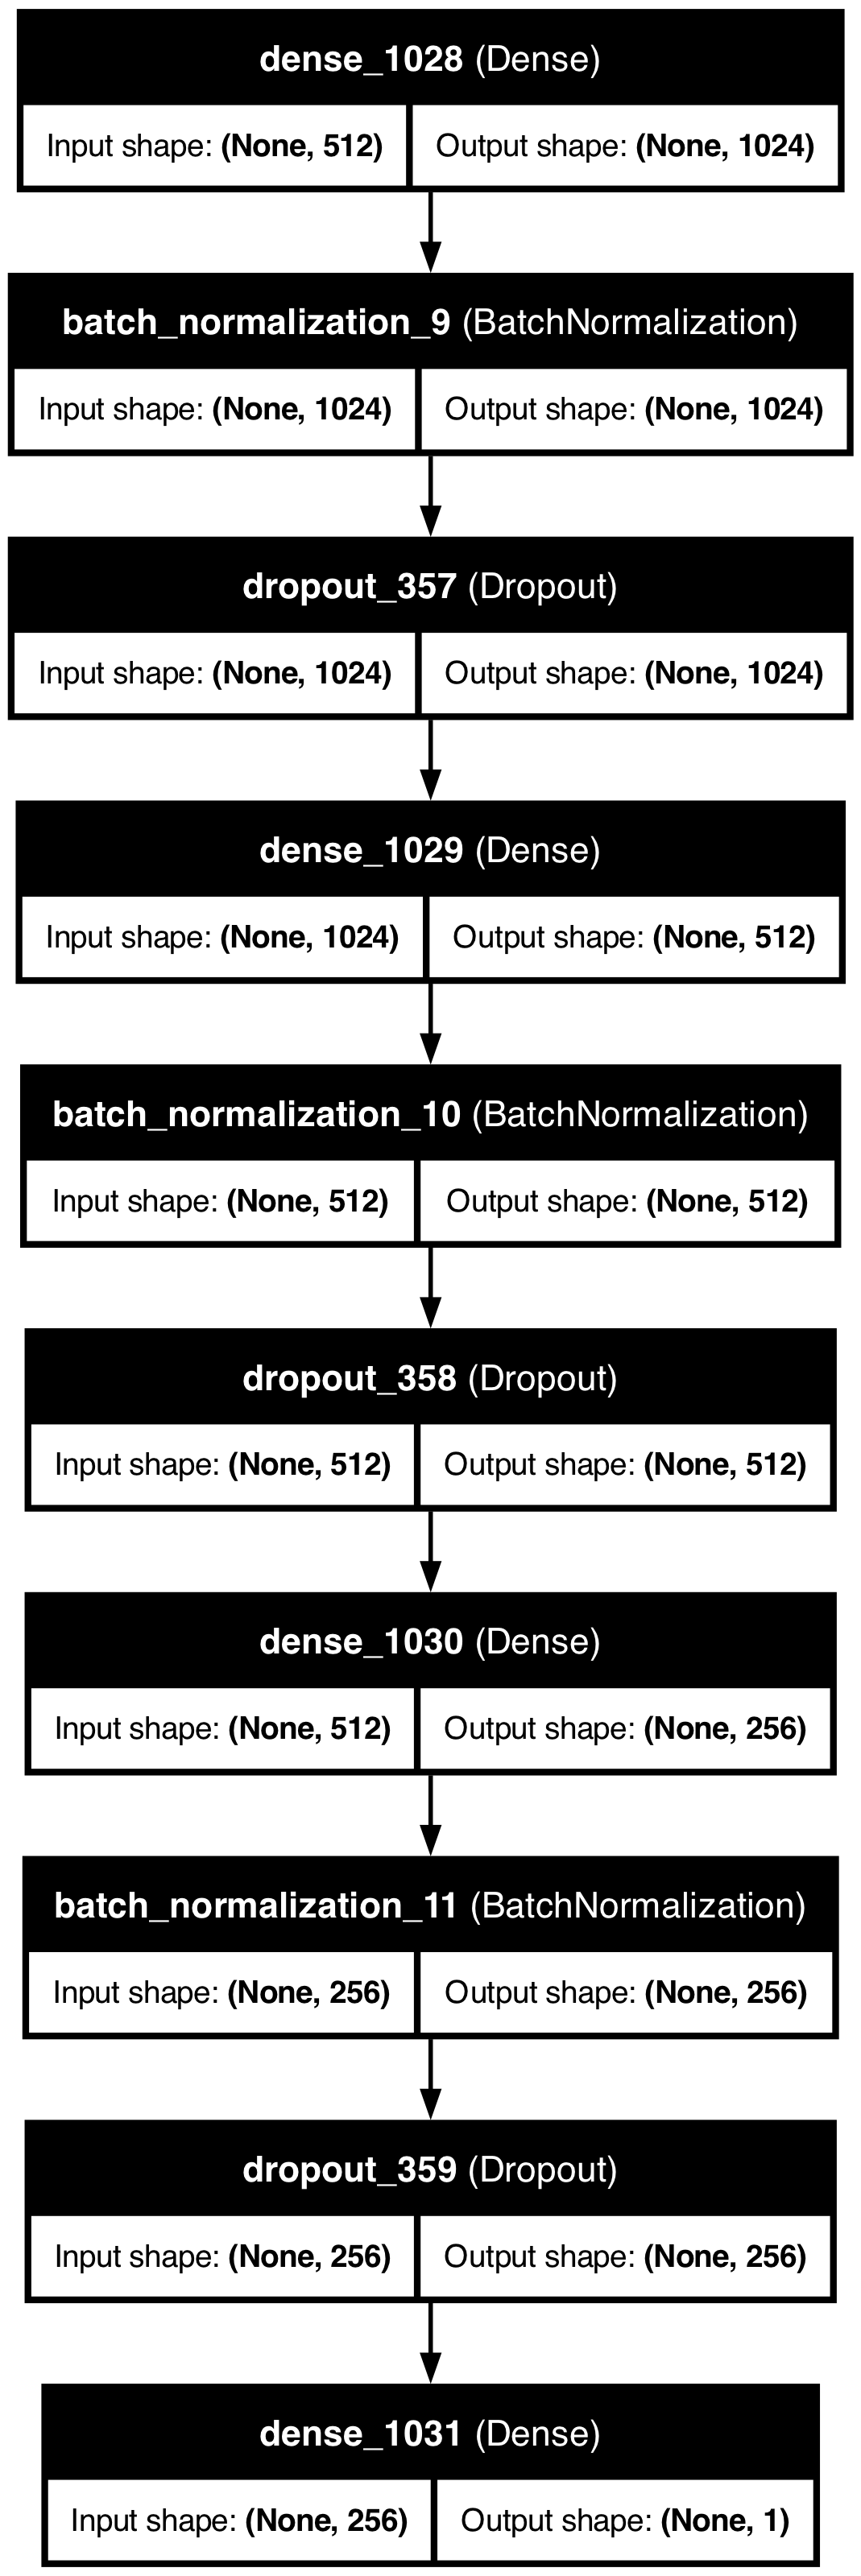

In [ ]:
# Generate the plot
plot_model(model_4r, show_shapes=True, show_layer_names=True)

In [ ]:
# Fit the model
model_4r_history = model_4r.fit(
    rX_train_embeddings, 
    ry_train, 
    batch_size=64, 
    epochs=epochs, 
    validation_split=0.2, 
    callbacks=[callback_es]
)

# Model Summary
print(model_4r.summary())

Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5303 - loss: 2.7131 - val_accuracy: 0.6889 - val_loss: 2.3888
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5912 - loss: 2.5780 - val_accuracy: 0.7329 - val_loss: 2.3604
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6432 - loss: 2.4692 - val_accuracy: 0.7461 - val_loss: 2.3098
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6734 - loss: 2.4288 - val_accuracy: 0.7582 - val_loss: 2.2425
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6663 - loss: 2.4359 - val_accuracy: 0.7658 - val_loss: 2.1859
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6874 - loss: 2.4056 - val_accuracy: 0.7719 - val_loss: 2.1627
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7024 - loss: 2.3699 - val_accuracy: 0.7754 - val_loss: 2.1576
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6986 - loss: 2.3776 -

Model: "sequential_347"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1028 (Dense)              │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_357 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1029 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_358 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_359 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1031 (Dense)              │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,559,429 (13.58 MB)

 Trainable params: 1,185,281 (4.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 2,370,564 (9.04 MB)

None


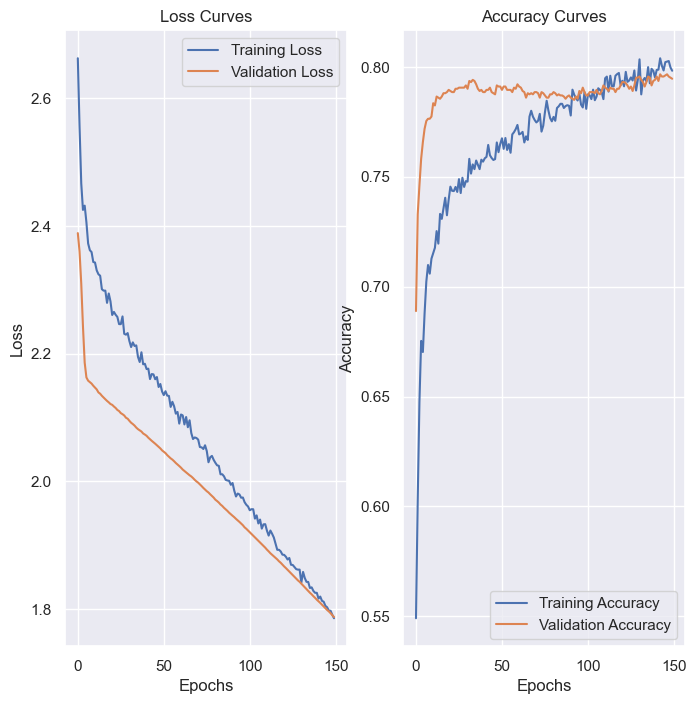

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_4r_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4r.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4r_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4r_accuracy = accuracy_score(ry_test, ry_pred)
m4r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4r_recall = recall_score(ry_test, ry_pred, average='weighted')
m4r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4r_accuracy:.2%}", f"{m4r_precision:.3f}", f"{m4r_recall:.3f}", f"{m4r_f1:.3f}", f"{m4r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Model Performance          Results
         accuracy           79.13%
        precision            0.793
           recall            0.791
         f1_score            0.791
    time/instance 0.000839 seconds


In [ ]:
#store_results('Model_4r', m4r_accuracy, m4r_precision, m4r_recall, m4r_f1, m4r_time_per_instance)

# View the consolidated results
print(results_df)

## Model not use

### DistilBERT

In [ ]:
# from transformers import DistilBertTokenizer, TFDistilBertModel

In [ ]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
#def get_distilbert_embeddings(texts):
#    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)
#    outputs = distilbert_model(encoded_inputs)
#    # Take the mean of the output embeddings to use as sentence embeddings
#    return tf.reduce_mean(outputs.last_hidden_state, axis=1)

In [ ]:
# Convert texts to embeddings
#cX_train_embeddingsDBert = get_distilbert_embeddings(cX_train.tolist())
#cX_test_embeddingsDBert = get_distilbert_embeddings(cX_test.tolist())
#rX_train_embeddingsDBert = get_distilbert_embeddings(rX_train.tolist())
#rX_test_embeddingsDBert = get_distilbert_embeddings(rX_test.tolist())

: 

In [ ]:
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsDBert.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerDB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerDB, loss='binary_crossentropy', metrics=['accuracy'])

# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Train the model
#model_history = model.fit(
#    cX_train_embeddingsDBert, 
#    ry_train, 
#    batch_size=32, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
# plot_loss_curves(model_history)

### RoBERTa

In [ ]:
#from transformers import RobertaTokenizer, TFRobertaModel
#from tensorflow.keras.models import Model

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
#def get_roberta_embeddings(texts):
#    # Tokenize the texts
#    encoded_input = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
#    # Get embeddings from RoBERTa model
#    outputs = roberta_model(encoded_input)
#    # Use the pooled output for classification tasks (similar to [CLS] in BERT)
#    return outputs.pooler_output

# Convert texts to embeddings
#cX_train_embeddingsBERT = get_roberta_embeddings(cX_train.tolist())
#cX_test_embeddingsBERT = get_roberta_embeddings(cX_test.tolist())
#rX_train_embeddingsBERT = get_roberta_embeddings(rX_train.tolist())
#rX_test_embeddingsBERT = get_roberta_embeddings(rX_test.tolist())

In [ ]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsBERT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerB, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
#plot_loss_curves(model_history)

### GPT2

In [ ]:
#from transformers import TFAutoModel, AutoTokenizer, GPT2Tokenizer

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('gpt2')
#model_gpt = TFAutoModel.from_pretrained('gpt2')

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
#if tokenizer.pad_token is None:
#    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Resize model embeddings
#model_gpt.resize_token_embeddings(len(tokenizer))

#def get_gpt_embeddings(texts):
#    # Ensure input is a list of strings
#    if isinstance(texts, pd.Series):
#        texts = texts.tolist()
#    elif not isinstance(texts, list):
#        raise ValueError("Input must be a list of strings.")
    
    # Tokenize and align to the maximum sequence length expected by GPT-2
#    inputs = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="tf")
    
    # Extract last hidden states
#    outputs = model_gpt(**inputs)
#    embeddings = outputs.last_hidden_state[:, 0, :]  # Extracting embeddings from the first token
#    return embeddings


In [ ]:
#cX_train_embeddingsGPT = get_gpt_embeddings(cX_train.astype(str))
#cX_test_embeddingsGPT = get_gpt_embeddings(cX_test.astype(str))

In [ ]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsGPT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerC = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerC, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
#plot_loss_curves(model_history)

## Summary of all models

In [ ]:
print(results_df)

          Model  Accuracy  Precision  Recall  F1 Score Time per Instance
0    Model_0cTI      0.79      0.793   0.788     0.787  0.000000 seconds
1    Model_0rTI      0.79      0.795   0.789     0.788  0.000000 seconds
2    Model_2cIT      0.78      0.785   0.782     0.782  0.000425 seconds
3    Model_2rIT      0.79      0.789   0.788     0.787  0.000363 seconds
4    Model_3cIT      0.79      0.792   0.790     0.790  0.000428 seconds
5    Model_3rIT      0.80      0.801   0.799     0.799  0.000468 seconds
6   Model_4cUST      0.76      0.762   0.761     0.760  0.000125 seconds
7   Model_4cUST      0.75      0.750   0.750     0.750  0.000091 seconds
8   Model_4cUSF      0.76      0.760   0.759     0.759  0.000176 seconds
9   Model_4rUSF      0.78      0.791   0.776     0.759  0.000096 seconds
10  Model_4rUSF      0.77      0.787   0.772     0.759  0.000110 seconds


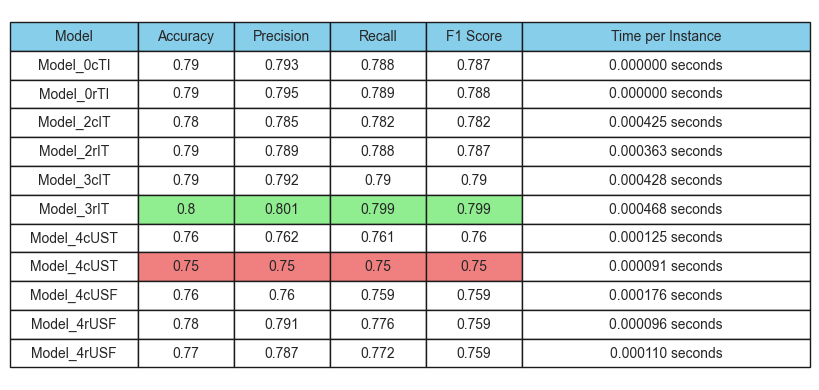

In [ ]:
# Convert relevant columns to float for comparison
results_df['Precision'] = results_df['Precision'].astype('float')
results_df['Recall'] = results_df['Recall'].astype('float')
results_df['F1 Score'] = results_df['F1 Score'].astype('float')
results_df['Accuracy'] = results_df['Accuracy'].str.rstrip('%').astype('float')

# Find the best and worst values
best_values = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].max()
worst_values = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].min()

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 0.6 + 0.3 * len(results_df)))  # Smaller height factor to reduce vertical space
ax.axis('off')  # Hide the axes

# Convert DataFrame to a list of lists for cellText
data = results_df.values.tolist()

# Table
table = ax.table(
    cellText=data,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=["skyblue"]*len(results_df.columns),  # Color for the column headers
    colWidths=[0.16, 0.12, 0.12, 0.12, 0.12, 0.36]  # Adjust column widths to fit your content
)

# Highlight best and worst values
for row in range(1, len(data) + 1):  # Skip the header row
    for col, col_name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
        if results_df.at[row-1, col_name] == best_values[col_name]:
            table[(row, col + 1)].set_facecolor('lightgreen')
        elif results_df.at[row-1, col_name] == worst_values[col_name]:
            table[(row, col + 1)].set_facecolor('lightcoral')

table.auto_set_font_size(False)
table.set_fontsize(10)  # Adjust font size if necessary
table.scale(1, 1.4)  # Scale table size, reduce x-scaling to minimize horizontal space

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.05)  # Minimize margins as much as possible

plt.show()

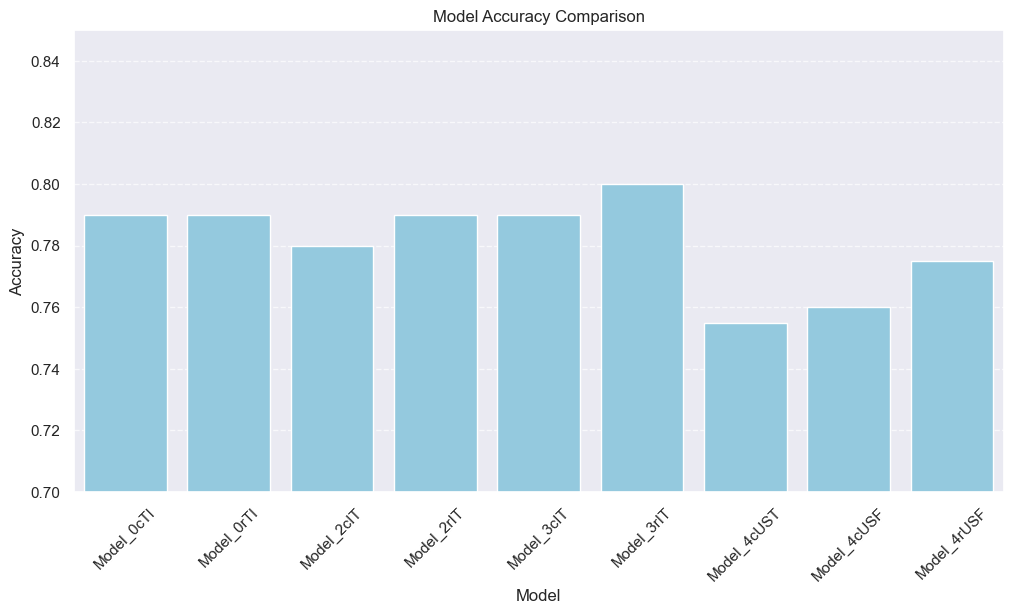

In [ ]:
# Creating a bar plot for model accuracy comparison with seaborn in sky blue, without error bars
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, color='skyblue', ci=None)

# Adjusting the aesthetics
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.70, 0.85)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()